In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from bosonStar import *
from util import *

from ctypes import *
file = "./testing.so"
my_func = CDLL(file)

#Middle
massInCU = 2e-77
aInCU = 1e-73
totalMassInCU = 0.1
#dtInCU = 1000.0
#bigT = 100000
dtInCU = 2500.0
bigT = 10000

/home/kklee/anaconda3/lib/python3.11/site-packages/scipy/integrate/_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


A2=  -0.3197640202007044  X= 20.65212130424261
A2=  -0.4847073570464445  X= 20.0997201994404
A2=  -0.4996237064856289  X= 40.0
A2=  -0.5019378672755319  X= 16.740033480066963
A2=  -0.5018381151828868  X= 18.401316802633605
A2=  -0.5018730652697496  X= 15.347950695901392
A2=  -0.5019295973148135  X= 22.058364116728235
A2=  -0.5019295973148135  X= 22.058364116728235
MU= 0.3181619365115217 MASS= 0.09999012221832808
FAR POINT: 156400 500000


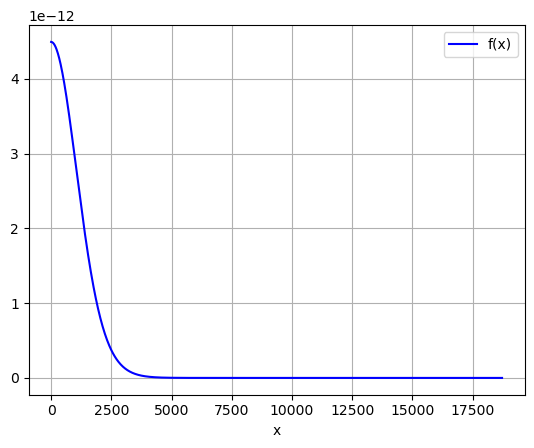

(1000,)


In [2]:
bosonStar = outputProfile(massInCU, aInCU, totalMassInCU, 500)
x = bosonStar["x"]
psi = bosonStar["profile"]

dx = x[1]-x[0]
for i in range(500):
    x = np.append(x, x[-1]+dx)
    psi = np.append(psi, psi[-1])

print(x.shape)

In [3]:
totalMass = massSIToPlanckUnit(massCodeUnitToSI(totalMassInCU))
m = massSIToPlanckUnit(massCodeUnitToSI(massInCU))
a = lengthSIToPlanckUnit(lengthCodeUnitToSI(aInCU))
N = totalMass/m
Ra = np.sqrt(a/m/m/m)
omegaA = m*m/np.abs(a)
epsilon = 1.0/omegaA/m/Ra/Ra
a0 = np.sqrt(1.0/omegaA/m)
delta = 4.0*np.pi*a*N/a0
GM = totalMass/Ra/Ra/Ra/omegaA/omegaA

print("R:", Ra)
print("Omega:" ,omegaA)
print("Epsilon (Should be 1):", epsilon)
print("Delta:", delta)
print("New G:", GM)

R: 3.8684718785837514e+40
Omega: 3.656129092998465e-43
Epsilon (Should be 1): 1.0000000000000002
Delta: 14.839459489461666
New G: 1.180886665279879


In [4]:
x = lengthSIToPlanckUnit(lengthCodeUnitToSI(x))/Ra
psi = np.sqrt(densitySIToPlanckUnit(densityCodeUnitToSI(psi))/totalMass)*np.power(Ra, 3.0/2.0)
normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
psi = psi/normalization
psi = psi.astype(complex)

size = len(psi)
dt = timeSIToPlanckUnit(timeCodeUnitToSI(dtInCU))*omegaA
dx = x[1]-x[0]

print(psi)
print("DT:", dt)
print("DX:", dx)

[5.83973278e-02+0.j 5.83608193e-02+0.j 5.82878809e-02+0.j
 5.81786701e-02+0.j 5.80334220e-02+0.j 5.78524489e-02+0.j
 5.76361390e-02+0.j 5.73849547e-02+0.j 5.70994308e-02+0.j
 5.67801731e-02+0.j 5.64278553e-02+0.j 5.60432170e-02+0.j
 5.56270607e-02+0.j 5.51802488e-02+0.j 5.47037006e-02+0.j
 5.41983885e-02+0.j 5.36653348e-02+0.j 5.31056077e-02+0.j
 5.25203178e-02+0.j 5.19106136e-02+0.j 5.12776778e-02+0.j
 5.06227230e-02+0.j 4.99469874e-02+0.j 4.92517308e-02+0.j
 4.85382301e-02+0.j 4.78077752e-02+0.j 4.70616646e-02+0.j
 4.63012016e-02+0.j 4.55276897e-02+0.j 4.47424291e-02+0.j
 4.39467125e-02+0.j 4.31418217e-02+0.j 4.23290234e-02+0.j
 4.15095664e-02+0.j 4.06846779e-02+0.j 3.98555608e-02+0.j
 3.90233903e-02+0.j 3.81893119e-02+0.j 3.73544384e-02+0.j
 3.65198479e-02+0.j 3.56865817e-02+0.j 3.48556428e-02+0.j
 3.40279940e-02+0.j 3.32045567e-02+0.j 3.23862100e-02+0.j
 3.15737893e-02+0.j 3.07680864e-02+0.j 2.99698484e-02+0.j
 2.91797778e-02+0.j 2.83985321e-02+0.j 2.76267244e-02+0.j
 2.68649234e-0

In [5]:
T = np.zeros((size,size)).astype(complex)
TSph = np.zeros((size,size)).astype(complex)
Q = np.zeros((size,size)).astype(complex)
V2Grav = np.zeros((size,size)).astype(complex)
I = np.identity(size).astype(complex)
phi = np.zeros((size))

In [6]:
def setupT():
    global T, TSph
    for i in range(size):
        if i==0:
            T[i][i] = (4.0/3.0-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0-1.0/12.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==1:
            T[i][i-1] = (-1.0/12.0+4.0/3.0)*3
            T[i][i] = (-5.0/2.0)*3
            T[i][i+1] = (4.0/3.0)*3
            T[i][i+2] = (-1.0/12.0)*3
        elif i==size-1:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0+4.0/3.0-1.0/12.0
            TSph[i][i-1] = -1.0/2.0/x[i]
            TSph[i][i] = 1.0/2.0/x[i]
        elif i==size-2:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0-1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]
        else:
            T[i][i-2] = -1.0/12.0
            T[i][i-1] = 4.0/3.0
            T[i][i] = -5.0/2.0
            T[i][i+1] = 4.0/3.0
            T[i][i+2] = -1.0/12.0
            TSph[i][i+1] = 1.0/2.0/x[i]
            TSph[i][i-1] = -1.0/2.0/x[i]

    T = -1.0/2.0/dx/dx*T
    TSph = -1.0/dx*TSph

def setupQ():
    global Q
    for i in range(size):
        Q[i][i] = delta*np.absolute(psi[i])*np.absolute(psi[i])

def setupV2Grav():
    global V2Grav, phi, psi

    rho = np.absolute(psi)*np.absolute(psi)
    rho_c = (c_double * size)(*rho)
    phi_c = (c_double * size)(*np.absolute(phi))
    my_func.findGravRho(rho_c, phi_c, c_int(size), c_double(dx))
    for i in range(size):
        phi[i] = phi_c[i] * GM

    for i in range(size):
        V2Grav[i][i] = phi[i]

def setupU1U2():
    global U1, U2
    U1 = I + 1.0j*dt/2.0*(T+TSph+Q+V2Grav)
    U2 = I - 1.0j*dt/2.0*(T+TSph+Q+V2Grav)

0 0.0 0.05839840443316344 1.0001279742974367


/tmp/ipykernel_103309/3173652264.py:55: RuntimeWarning: divide by zero encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_103309/3173652264.py:55: RuntimeWarning: invalid value encountered in divide
  quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)
/tmp/ipykernel_103309/3173652264.py:57: RuntimeWarning: invalid value encountered in divide
  plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)
/home/kklee/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home/kklee/anaconda3/lib/python3.11/site-packages/numpy/lib/function_base.py:1250: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f

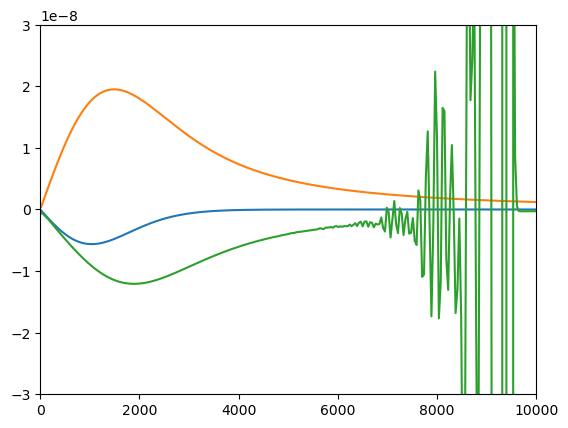

1 0.08351027137908527 0.05840151174152791 1.000127968260069
2 0.16702054275817055 0.05840663274471841 1.000127958862556
3 0.2505308141372558 0.05841385208748817 1.0001279451682636
4 0.3340410855163411 0.0584230583630201 1.0001279280431528
5 0.4175513568954264 0.058434322387262566 1.0001279067506117
6 0.5010616282745116 0.05844756159507869 1.0001278819395776
7 0.5845718996535969 0.0584628020260211 1.0001278531152504
8 0.6680821710326822 0.058479987999465445 1.0001278206886206
9 0.7515924424117675 0.058499116823745756 1.000127784415567
10 0.8351027137908528 0.058520142386529576 1.0001277444687848
11 0.9186129851699381 0.05854304958715617 1.0001277008458256
12 1.0021232565490232 0.0585677915841571 1.0001276534961907
13 1.0856335279281086 0.05859434852269776 1.0001276026375943
14 1.1691437993071938 0.05862267062368651 1.0001275480227856
15 1.2526540706862792 0.05865273525164369 1.0001274900554633
16 1.3361643420653644 0.05868448933873522 1.00012742833268
17 1.4196746134444496 0.05871790787

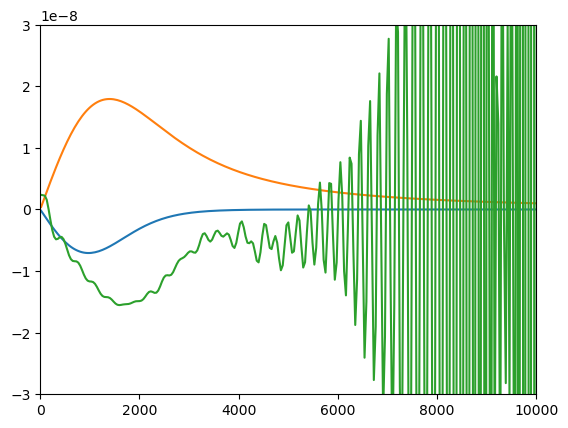

101 8.434537409287612 0.06336833292746923 1.0001161345020921
102 8.518047680666697 0.0633887050729007 1.0001160582684991
103 8.601557952045784 0.06339994070034075 1.000115986743364
104 8.685068223424869 0.06341899829553029 1.0001159163489624
105 8.768578494803954 0.06344018817085566 1.0001158484208381
106 8.852088766183039 0.06345164581243323 1.0001157849741311
107 8.935599037562124 0.06346887177279842 1.0001157231664741
108 9.019109308941209 0.06349011955091956 1.000115662969869
109 9.102619580320296 0.06350138648335432 1.000115607510098
110 9.18612985169938 0.0635162973403767 1.000115553605016
111 9.269640123078466 0.0635359850833984 1.0001155013059182
112 9.35315039445755 0.06354555337209508 1.0001154533327934
113 9.436660665836635 0.06355728869815491 1.0001154073532932
114 9.52017093721572 0.06357390199798846 1.000115362510173
115 9.603681208594807 0.06358050351650851 1.0001153221038745
116 9.687191479973892 0.06358858072077411 1.0001152834861438
117 9.770701751352977 0.06360147500

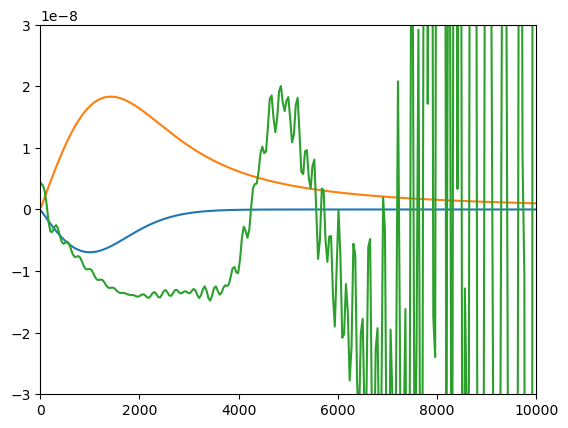

201 16.78556454719614 0.06336042030193872 1.0001165065809414
202 16.869074818575225 0.06335384555701408 1.0001165436053567
203 16.95258508995431 0.06334645799645636 1.0001165814290698
204 17.036095361333395 0.06334369295990556 1.0001166175778888
205 17.11960563271248 0.0633343937547786 1.0001166562372281
206 17.203115904091568 0.06333039274479965 1.000116693049043
207 17.28662617547065 0.06332440509870892 1.0001167309179329
208 17.370136446849738 0.06331597638112255 1.0001167693917437
209 17.45364671822882 0.06331302772166375 1.0001168065112156
210 17.537156989607908 0.06330363318798325 1.00011684560166
211 17.62066726098699 0.06329855711486423 1.0001168835372496
212 17.704177532366078 0.06329274999889538 1.0001169218321748
213 17.787687803745165 0.06328346011718448 1.0001169612296301
214 17.871198075124248 0.06327997425933475 1.0001169991048062
215 17.954708346503335 0.06327042635005994 1.0001170387369893
216 18.038218617882418 0.06326427474547883 1.0001170777415378
217 18.12172888926

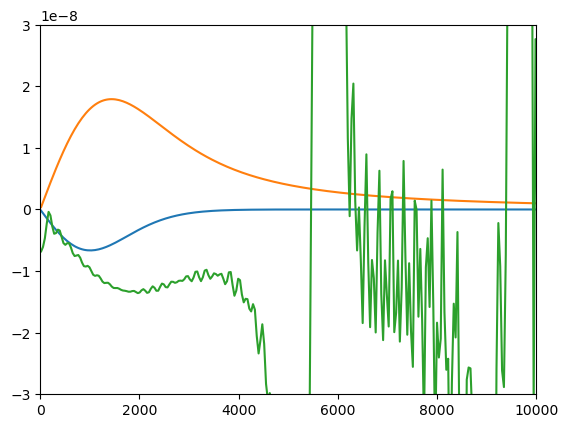

301 25.13659168510467 0.06232485209162471 1.0001206973376462
302 25.220101956483752 0.062312555503158944 1.000120740787726
303 25.30361222786284 0.06229885728315668 1.0001207838647639
304 25.387122499241922 0.06228416920309224 1.000120827848774
305 25.47063277062101 0.06227239542748185 1.0001208705132139
306 25.554143042000092 0.062256371238434804 1.0001209145935697
307 25.63765331337918 0.06224463301607754 1.0001209575776075
308 25.721163584758266 0.06222948232032861 1.000121000931044
309 25.80467385613735 0.06221581449716213 1.0001210449613058
310 25.888184127516435 0.06220274987341049 1.000121087157992
311 25.97169439889552 0.06218697777096266 1.0001211322631476
312 26.055204670274605 0.062175101869893314 1.0001211737113866
313 26.138714941653692 0.06215893755630931 1.0001212191639812
314 26.222225213032775 0.06214616094386622 1.0001212607564032
315 26.305735484411862 0.06213152968921123 1.0001213057145688
316 26.389245755790945 0.06211655958726622 1.0001213480890017
317 26.47275602

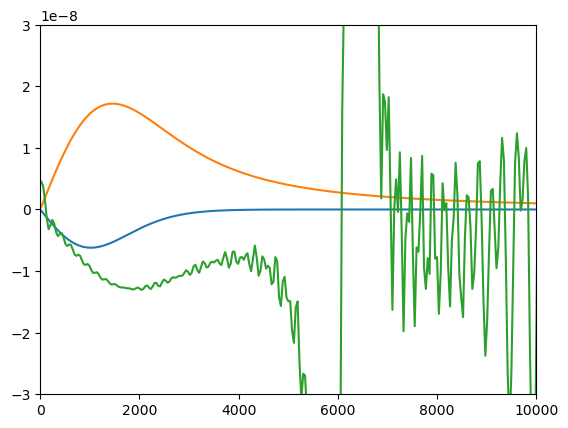

401 33.48761882301319 0.060647695539472996 1.000125229319557
402 33.57112909439228 0.06062649740588357 1.000125276283228
403 33.65463936577137 0.06060605379638007 1.0001253270555097
404 33.73814963715045 0.06058608932508255 1.0001253747777767
405 33.82165990852953 0.06056424897263123 1.0001254250153913
406 33.90517017990862 0.06054508045020643 1.0001254738078744
407 33.988680451287706 0.06052267408692998 1.0001255230908637
408 34.07219072266679 0.06050323791729662 1.0001255734137393
409 34.15570099404588 0.06048137662877906 1.000125621309176
410 34.23921126542496 0.060460719192574605 1.0001256734676836
411 34.322721536804046 0.060440039492096406 1.0001257198668907
412 34.406231808183136 0.06041795699199279 1.000125773733272
413 34.48974207956222 0.06039820695677301 1.0001258189911504
414 34.5732523509413 0.06037536468092145 1.000125874003883
415 34.656762622320386 0.06035559470415155 1.0001259188439218
416 34.740272893699476 0.060333065417740785 1.0001259741830006
417 34.82378316507856

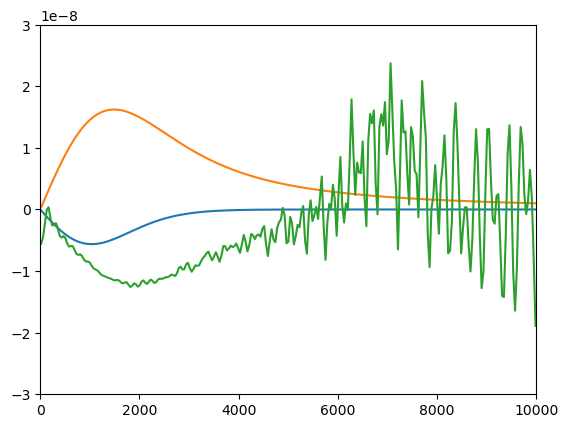

501 41.838645960921724 0.05835917941204487 1.0001304397616964
502 41.92215623230081 0.05833798494183291 1.0001304991282551
503 42.00566650367989 0.058310745154029855 1.0001305472200734
504 42.08917677505898 0.05828658467767098 1.0001306069600098
505 42.172687046438064 0.05826375243773469 1.000130654431888
506 42.25619731781715 0.05823738934797898 1.0001307140421931
507 42.33970758919624 0.058207793689529455 1.000130762888066
508 42.42321786057532 0.058179824317976005 1.00013082192107
509 42.506728131954404 0.05816061429005475 1.0001308706032577
510 42.59023840333349 0.05814024277963283 1.0001309273997012
511 42.67374867471258 0.05811723194945492 1.0001309781650947
512 42.75725894609166 0.05809114229091546 1.0001310338498106
513 42.84076921747074 0.05806925115215729 1.0001310862808002
514 42.924279488849834 0.05804667908295306 1.0001311393118637
515 43.00778976022892 0.05801796902440754 1.0001311945423266
516 43.091300031608 0.057988345614196156 1.000131246390893
517 43.17481030298708 0

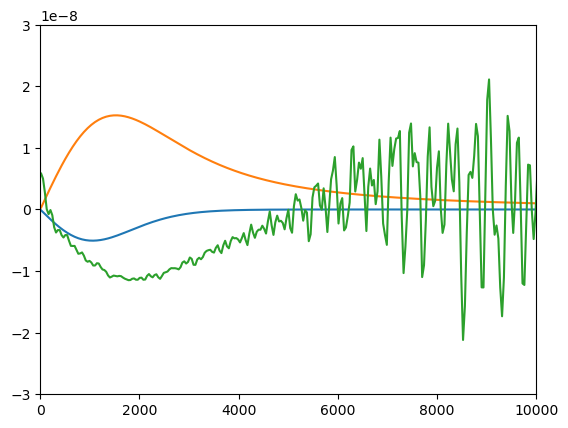

601 50.18967309883025 0.056011916328635454 1.0001355632914781
602 50.27318337020934 0.05599465534776355 1.0001356100120837
603 50.35669364158842 0.0559695926144977 1.000135657246781
604 50.440203912967505 0.055943468774697275 1.0001357026430493
605 50.52371418434659 0.05592424071377886 1.0001357509488016
606 50.60722445572568 0.05590963096925451 1.0001357928608763
607 50.69073472710476 0.05589323307215355 1.0001358427318985
608 50.774244998483844 0.05587720273770064 1.0001358827381674
609 50.857755269862935 0.05585137303602369 1.000135934483379
610 50.94126554124202 0.05581910032097492 1.0001359748788667
611 51.0247758126211 0.0557919071546442 1.000136027581505
612 51.108286084000184 0.05577871401007683 1.0001360649392153
613 51.191796355379275 0.055764858651072294 1.0001361162274562
614 51.27530662675836 0.05574176871353407 1.0001361546091232
615 51.35881689813744 0.05571655850629396 1.0001362064964865
616 51.44232716951653 0.05569157427344437 1.0001362450148228
617 51.525837440895614

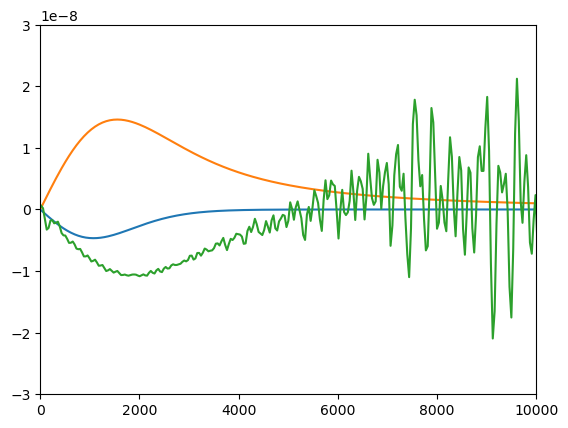

701 58.54070023673878 0.054246388013895835 1.0001393984244957
702 58.62421050811786 0.0542343952644795 1.0001394198547287
703 58.707720779496945 0.05422611317748337 1.0001394542793944
704 58.791231050876036 0.0542135190532895 1.0001394752421824
705 58.87474132225512 0.054201671057893246 1.0001395098468877
706 58.9582515936342 0.05419493877251205 1.00013952970095
707 59.04176186501329 0.05418528751597173 1.0001395631829983
708 59.125272136392375 0.05417489361858121 1.000139583823972
709 59.20878240777146 0.054161666676686114 1.0001396160489635
710 59.29229267915054 0.05414887703125451 1.0001396378550018
711 59.37580295052963 0.05413757737603235 1.000139667899924
712 59.459313221908715 0.054125486029802425 1.0001396907251079
713 59.5428234932878 0.05410916616154592 1.0001397192014863
714 59.62633376466689 0.05409770670894721 1.0001397436353898
715 59.70984403604597 0.05409166768011 1.000139768269285
716 59.793354307425055 0.05407801498696488 1.0001397946052832
717 59.87686457880414 0.054

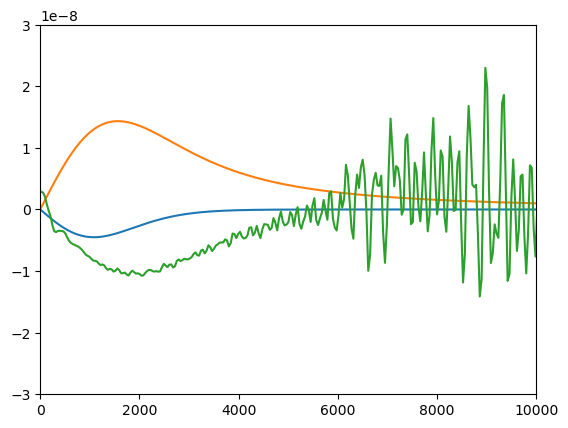

801 66.8917273746473 0.053579214675266336 1.0001409894574425
802 66.97523764602639 0.0535820404641137 1.0001409879222183
803 67.05874791740547 0.05357850804346343 1.0001409932169516
804 67.14225818878457 0.053578972818340634 1.0001409931103293
805 67.22576846016365 0.053582644262788734 1.0001409949389541
806 67.30927873154273 0.05357739076601637 1.0001409969237658
807 67.39278900292182 0.053575799246800525 1.0001409972736608
808 67.4762992743009 0.05357823091334954 1.0001409991894668
809 67.55980954567998 0.05357599541761511 1.000140997551075
810 67.64331981705907 0.053573599051361866 1.0001410012592695
811 67.72683008843816 0.05357637435270413 1.0001409968735995
812 67.81034035981725 0.05357755992812285 1.0001410009604141
813 67.89385063119633 0.05357694172543942 1.0001409954666158
814 67.97736090257541 0.05357975370476722 1.0001409996823194
815 68.0608711739545 0.05358186658905206 1.0001409925603373
816 68.14438144533358 0.05358441355298795 1.0001409969026367
817 68.22789171671266 0.

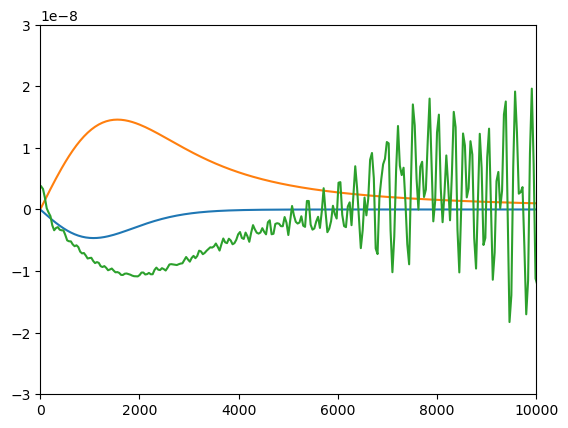

901 75.24275451255583 0.05421469019047663 1.0001397761207724
902 75.32626478393492 0.054227980467208975 1.0001397523088065
903 75.409775055314 0.05423812039526967 1.000139721718188
904 75.49328532669308 0.05425480167260414 1.0001396979071142
905 75.57679559807217 0.05426936500680104 1.0001396650328225
906 75.66030586945126 0.05428000148039897 1.0001396424953803
907 75.74381614083035 0.05429641416848844 1.0001396081206433
908 75.82732641220943 0.05431227848852707 1.000139584484305
909 75.91083668358851 0.05432199785246946 1.0001395504512716
910 75.9943469549676 0.0543387009928131 1.0001395260724648
911 76.07785722634668 0.05435364266336151 1.0001394908363912
912 76.16136749772576 0.054364374371759186 1.0001394665992402
913 76.24487776910486 0.054379605231349125 1.0001394312126735
914 76.32838804048394 0.05439510178611118 1.0001394047724335
915 76.41189831186303 0.054406575533535194 1.0001393704712571
916 76.49540858324211 0.054421730801937254 1.000139342443809
917 76.5789188546212 0.054

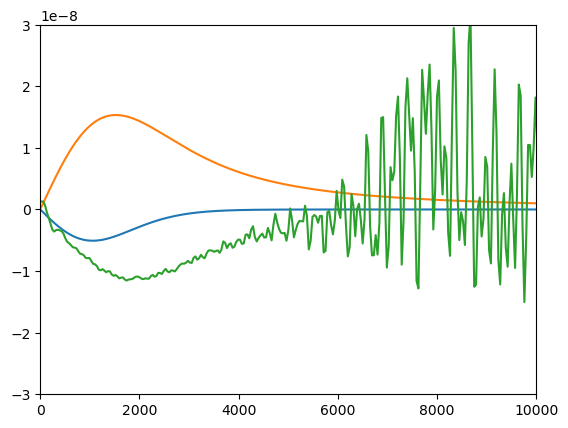

1001 83.59378165046436 0.05614105706002222 1.0001356491915365
1002 83.67729192184345 0.05616173677302158 1.0001355998650505
1003 83.76080219322253 0.05618667799904045 1.0001355401563117
1004 83.84431246460161 0.05621719520755834 1.0001354885934222
1005 83.9278227359807 0.056241384102742605 1.000135429360054
1006 84.01133300735978 0.056263805914451445 1.0001353775136446
1007 84.09484327873886 0.05628392394978365 1.0001353189870954
1008 84.17835355011796 0.056303684611648475 1.000135266190846
1009 84.26186382149704 0.05632979555195758 1.000135207859864
1010 84.34537409287613 0.056361348475920926 1.000135151971293
1011 84.42888436425521 0.05638848596603065 1.000135094371197
1012 84.5123946356343 0.05640974799033334 1.0001350377403597
1013 84.59590490701338 0.056427383442550605 1.000134981949548
1014 84.67941517839247 0.05644907442987876 1.0001349234196282
1015 84.76292544977156 0.05647750796650309 1.0001348672434762
1016 84.84643572115064 0.056510550271534676 1.0001348059821147
1017 84.92

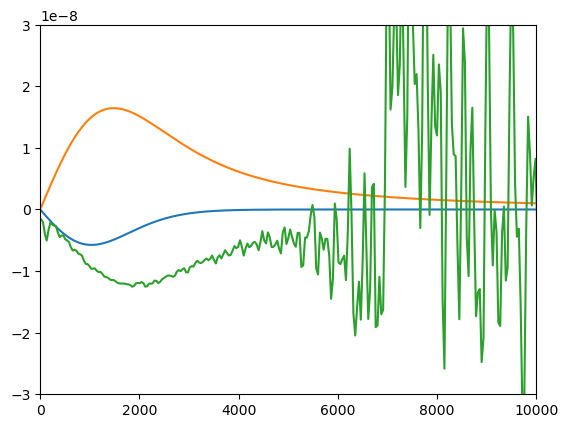

1101 91.94480878837288 0.05892080611157914 1.0001292030994027
1102 92.02831905975198 0.058949287608308434 1.0001291326776724
1103 92.11182933113106 0.05898142969900225 1.0001290599960757
1104 92.19533960251015 0.05900895429878379 1.0001289886832212
1105 92.27884987388923 0.059038689051915456 1.000128917795584
1106 92.36236014526831 0.05906890368220441 1.0001288447238368
1107 92.4458704166474 0.059100862632404605 1.0001287747052476
1108 92.52938068802648 0.05913562369582782 1.0001286998950725
1109 92.61289095940558 0.05916328625058718 1.0001286315855817
1110 92.69640123078466 0.05918987922429744 1.0001285565842086
1111 92.77991150216374 0.0592198913735068 1.0001284884359276
1112 92.86342177354283 0.059249404651587914 1.0001284124684942
1113 92.94693204492191 0.059275002134947206 1.0001283453186738
1114 93.03044231630099 0.05930173503125794 1.0001282690289004
1115 93.11395258768007 0.05933248414022592 1.0001282013690802
1116 93.19746285905917 0.05936527585295595 1.000128124540463
1117 93

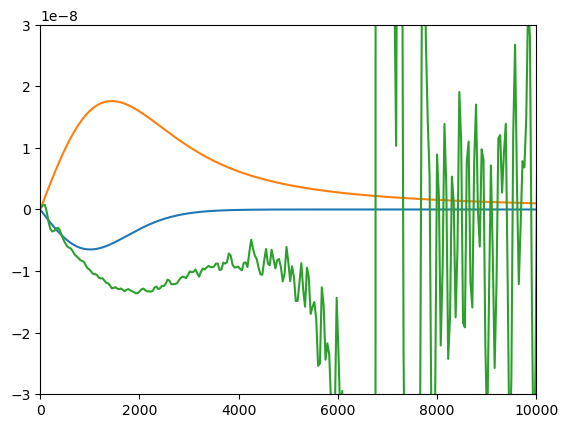

1201 100.29583592628141 0.06174127972891343 1.000122188027365
1202 100.3793461976605 0.06176272288553742 1.0001221219788758
1203 100.46285646903958 0.061787570630068664 1.0001220619696316
1204 100.54636674041868 0.061818216560611844 1.0001219946231026
1205 100.62987701179776 0.06184480057688589 1.0001219357997266
1206 100.71338728317684 0.06187172020123493 1.0001218690571458
1207 100.79689755455593 0.06189692922629831 1.0001218103092593
1208 100.88040782593501 0.06191421669969929 1.0001217463008887
1209 100.96391809731409 0.06193906030276373 1.0001216877605628
1210 101.04742836869318 0.06196162203849804 1.0001216231518988
1211 101.13093864007227 0.06197686630348647 1.0001215669856107
1212 101.21444891145136 0.06199810355850158 1.0001215037238762
1213 101.29795918283044 0.06202360304837194 1.0001214457588536
1214 101.38146945420952 0.062049553491315045 1.000121383663661
1215 101.4649797255886 0.06207192894152605 1.0001213259733794
1216 101.54848999696769 0.06208809282760096 1.0001212663

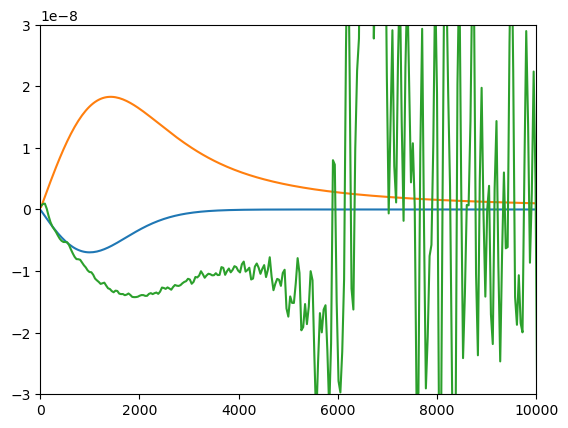

1301 108.64686306418994 0.06339197986662157 1.0001177023614485
1302 108.73037333556903 0.06339983224511402 1.0001176797001654
1303 108.81388360694811 0.06340029073503205 1.000117663703969
1304 108.8973938783272 0.06340601697928039 1.0001176415851325
1305 108.98090414970628 0.06341183165004782 1.0001176243553993
1306 109.06441442108537 0.06341287020907418 1.0001176046662719
1307 109.14792469246446 0.0634137226346443 1.000117589145335
1308 109.23143496384354 0.06341945303886011 1.0001175711174137
1309 109.31494523522262 0.06342572551532398 1.0001175553100734
1310 109.3984555066017 0.06343159051221788 1.0001175389748769
1311 109.48196577798079 0.06343891717279586 1.0001175226441545
1312 109.56547604935987 0.06344658173980566 1.00011750875657
1313 109.64898632073897 0.06345396424244194 1.000117492698111
1314 109.73249659211805 0.06346156735024697 1.0001174799095913
1315 109.81600686349714 0.06346455706610334 1.000117465114862
1316 109.89951713487622 0.0634676494721804 1.0001174554722445
13

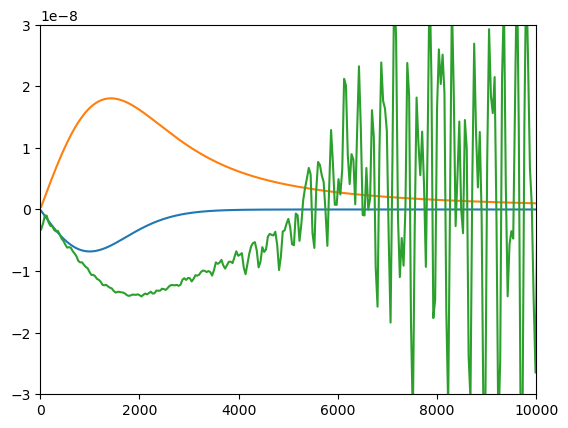

1401 116.99789020209847 0.06282548045615573 1.000118815668586
1402 117.08140047347756 0.06280051416698469 1.0001188614963452
1403 117.16491074485664 0.06277792497144703 1.0001189060765037
1404 117.24842101623572 0.06276276350760916 1.0001189522412481
1405 117.33193128761481 0.06274102819595836 1.0001189966410369
1406 117.41544155899389 0.06271923874019986 1.0001190447277208
1407 117.49895183037297 0.0627053843883943 1.0001190883483553
1408 117.58246210175207 0.06268666495271379 1.000119139665834
1409 117.66597237313115 0.06266777595704867 1.000119185494491
1410 117.74948264451024 0.0626490709014913 1.0001192364059002
1411 117.83299291588932 0.06262996134191247 1.00011928281526
1412 117.9165031872684 0.06261129457907615 1.0001193337886942
1413 118.00001345864749 0.06258721222532695 1.0001193821705974
1414 118.08352373002658 0.06256552847652133 1.000119436259917
1415 118.16703400140567 0.0625456738198658 1.0001194842561807
1416 118.25054427278475 0.06251981405684844 1.0001195399942966
14

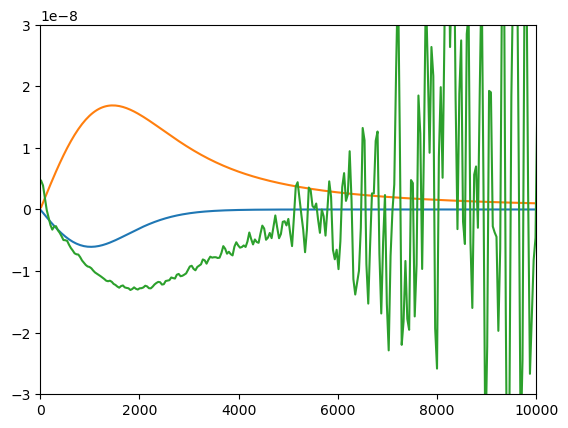

1501 125.34891734000699 0.060028939819546656 1.0001257140425186
1502 125.43242761138607 0.05999138033432073 1.000125804465583
1503 125.51593788276517 0.059955696457258255 1.0001258904709482
1504 125.59944815414426 0.059923315489327764 1.0001259807449678
1505 125.68295842552334 0.0598879671899792 1.000126065634731
1506 125.76646869690242 0.05985359608783199 1.000126156085309
1507 125.8499789682815 0.059818340120716185 1.0001262412561442
1508 125.93348923966059 0.05978505583146656 1.0001263315929663
1509 126.01699951103969 0.05975015171527683 1.0001264184238086
1510 126.10050978241877 0.059709448172551055 1.0001265108460886
1511 126.18402005379785 0.05967700419736735 1.0001265979329383
1512 126.26753032517693 0.059639446975497716 1.0001266892134208
1513 126.35104059655602 0.059595874835503104 1.0001267810152383
1514 126.4345508679351 0.059561907870807264 1.0001268706367277
1515 126.51806113931418 0.059523003097406754 1.0001269612452743
1516 126.60157141069328 0.059481482029933204 1.00012

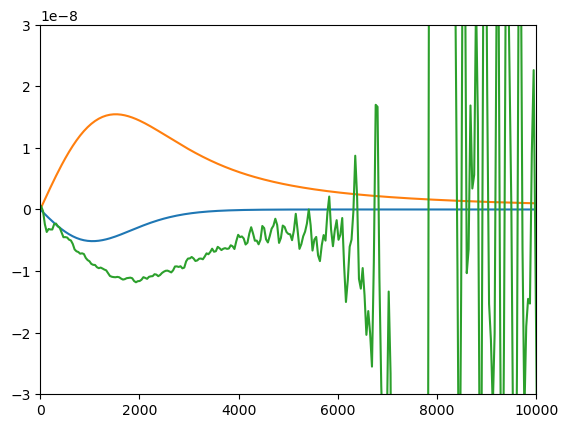

1601 133.69994447791552 0.056348757433189955 1.0001346432164233
1602 133.7834547492946 0.05631126955797488 1.0001347263993676
1603 133.8669650206737 0.05627626282169229 1.0001348072754987
1604 133.95047529205277 0.05624482299286634 1.0001348881114418
1605 134.03398556343186 0.05621333822666811 1.0001349686028576
1606 134.11749583481094 0.056183815379848914 1.0001350486553533
1607 134.20100610619002 0.05615144451523766 1.0001351288166884
1608 134.28451637756913 0.05611653065711688 1.0001352084369075
1609 134.36802664894822 0.0560910350467131 1.0001352874065936
1610 134.4515369203273 0.05605693376693359 1.000135364970606
1611 134.53504719170638 0.056017185327889865 1.0001354474867752
1612 134.61855746308547 0.05598994118315576 1.0001355226362978
1613 134.70206773446455 0.05595982717718223 1.0001356030029545
1614 134.78557800584363 0.05592968290133016 1.000135678511596
1615 134.86908827722272 0.05589963865795415 1.0001357594388978
1616 134.9525985486018 0.05586522537880431 1.0001358335281

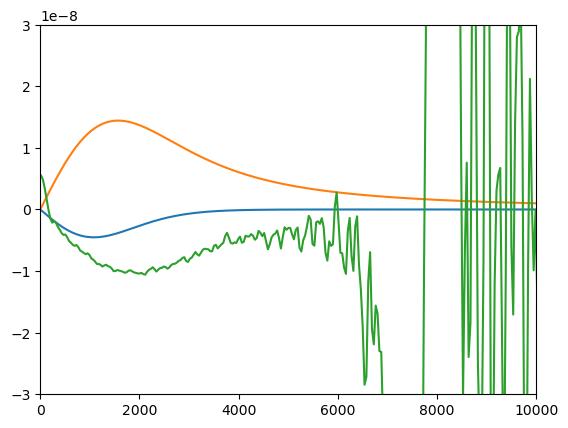

1701 142.05097161582404 0.053691933871759606 1.000140872340573
1702 142.13448188720312 0.05367257671000326 1.0001409092461822
1703 142.21799215858223 0.05365517514643687 1.000140949928287
1704 142.30150242996132 0.053645047648833245 1.0001409844440003
1705 142.3850127013404 0.05363071812860658 1.00014102434226
1706 142.46852297271948 0.053616528256505105 1.0001410569427656
1707 142.55203324409857 0.053595175994777984 1.0001410952825949
1708 142.63554351547765 0.053570548526307535 1.0001411293387108
1709 142.71905378685673 0.05355330913488955 1.0001411661361785
1710 142.80256405823582 0.05354300253905423 1.0001411955490311
1711 142.8860743296149 0.05353094345294231 1.0001412322636791
1712 142.96958460099398 0.05351055276505771 1.0001412630685802
1713 143.05309487237307 0.05349540817398602 1.0001412976955746
1714 143.13660514375215 0.05348070517839236 1.0001413269377883
1715 143.22011541513123 0.05345939514052316 1.0001413623497863
1716 143.30362568651034 0.05344862542292694 1.0001413908

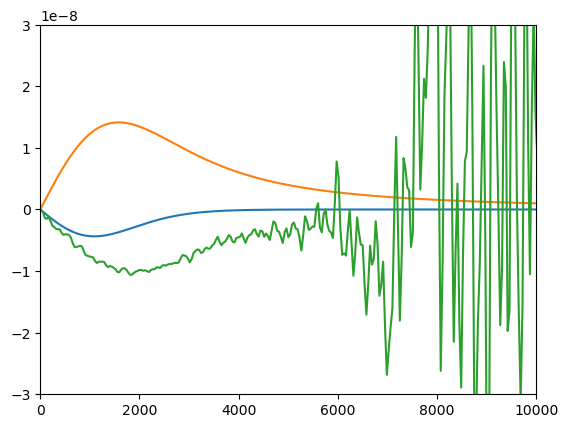

1801 150.40199875373258 0.05297083814697361 1.0001421990922
1802 150.48550902511167 0.052973446734489976 1.0001421836242594
1803 150.56901929649075 0.052971430425641494 1.0001421770274055
1804 150.65252956786983 0.052968167208514466 1.0001421641005843
1805 150.73603983924892 0.05296821824252083 1.0001421542152593
1806 150.819550110628 0.05296792527288802 1.0001421405286257
1807 150.90306038200708 0.05296916920928607 1.000142129459633
1808 150.98657065338617 0.052975927014722674 1.000142113844676
1809 151.07008092476525 0.05298334666955034 1.0001420997954664
1810 151.15359119614433 0.05298443750620318 1.0001420862338521
1811 151.23710146752344 0.0529888659313386 1.0001420731316408
1812 151.32061173890253 0.05299632966368267 1.0001420590709726
1813 151.4041220102816 0.05299564204685868 1.0001420439698026
1814 151.4876322816607 0.05299867992399908 1.000142028777838
1815 151.57114255303978 0.052999573109630736 1.0001420122555327
1816 151.65465282441886 0.05300266205653541 1.000141997595091

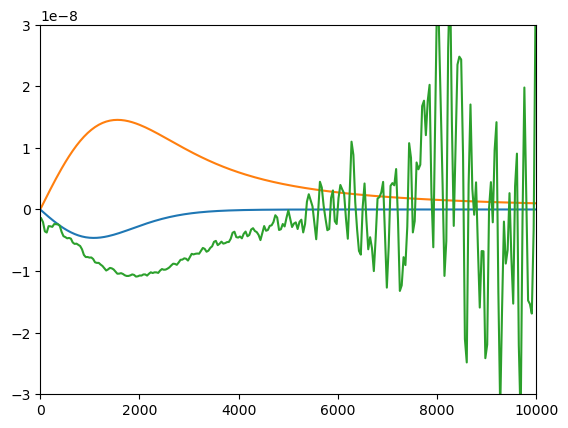

1901 158.7530258916411 0.054084983680400565 1.0001392157816757
1902 158.83653616302018 0.054096234552919994 1.0001391714901497
1903 158.92004643439927 0.054116085648052044 1.0001391261579902
1904 159.00355670577835 0.05413178421560699 1.0001390796261442
1905 159.08706697715743 0.054145746034713324 1.000139031873854
1906 159.17057724853655 0.054165237573139735 1.0001389855123042
1907 159.25408751991563 0.05418920714012393 1.0001389361796584
1908 159.3375977912947 0.05421026242652803 1.0001388906246165
1909 159.4211080626738 0.054226995316529004 1.0001388418594233
1910 159.50461833405288 0.054248747223416535 1.0001387963971284
1911 159.58812860543196 0.054270702276238175 1.0001387438594
1912 159.67163887681104 0.05428738051722627 1.000138699994703
1913 159.75514914819013 0.054304264765071615 1.0001386479486554
1914 159.8386594195692 0.05432403808343376 1.0001386028110495
1915 159.9221696909483 0.05434383229222641 1.0001385484247958
1916 160.00567996232738 0.054365239913505954 1.000138504

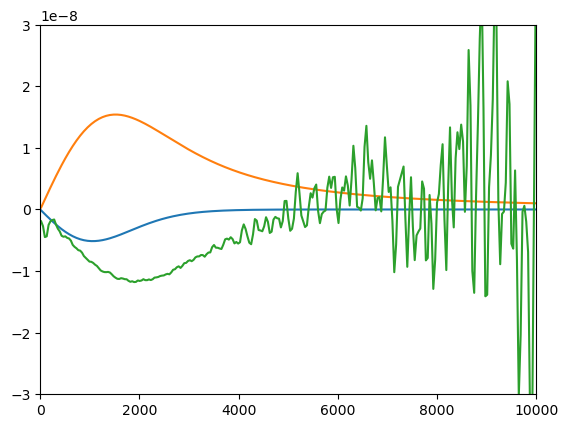

2001 167.10405302954965 0.05634306817100813 1.000133819234996
2002 167.18756330092873 0.056361622403050114 1.000133766538246
2003 167.2710735723078 0.056382597913100324 1.0001337042185512
2004 167.3545838436869 0.05640610978169732 1.000133651494002
2005 167.43809411506598 0.056427766061022684 1.0001335903898807
2006 167.52160438644506 0.05645027199492621 1.0001335365134123
2007 167.60511465782415 0.056476084866377035 1.0001334731711027
2008 167.68862492920323 0.0565023626499921 1.0001334207441694
2009 167.7721352005823 0.05653028384670024 1.0001333562356305
2010 167.8556454719614 0.056553157490001144 1.0001333005892599
2011 167.93915574334048 0.05658184061981519 1.0001332355942019
2012 168.02266601471956 0.05661027695274071 1.000133178944104
2013 168.10617628609864 0.05663075465804349 1.00013311871383
2014 168.18968655747773 0.056658552655181486 1.0001330598541538
2015 168.27319682885684 0.05668345686687755 1.0001329990208208
2016 168.35670710023592 0.05670698236332704 1.00013293727827

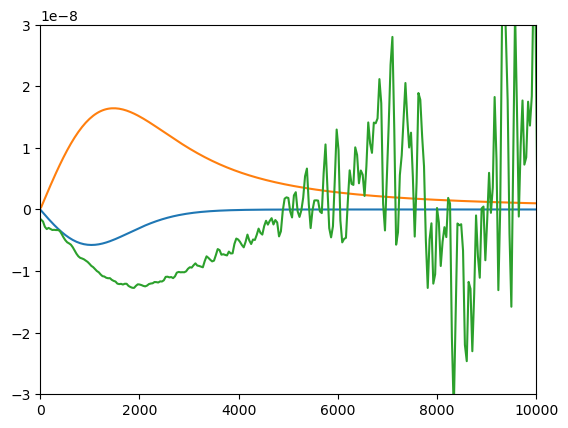

2101 175.45508016745816 0.058924689452240275 1.0001279949354442
2102 175.53859043883725 0.05893720337394096 1.0001279519801969
2103 175.62210071021633 0.05895575602602527 1.000127900442421
2104 175.7056109815954 0.05897785060856471 1.000127855738327
2105 175.7891212529745 0.058992673573239104 1.0001278043626376
2106 175.87263152435358 0.05900547302199082 1.0001277595617966
2107 175.95614179573266 0.05902574396396722 1.000127708051657
2108 176.03965206711175 0.059041522620830664 1.000127661322588
2109 176.12316233849083 0.05905637642697311 1.000127613537196
2110 176.20667260986994 0.05907255395089358 1.000127566182512
2111 176.29018288124902 0.05908590761433457 1.000127520779814
2112 176.3736931526281 0.059104240312624165 1.00012747148709
2113 176.4572034240072 0.05912444078923847 1.0001274261976583
2114 176.54071369538627 0.05914976610899594 1.00012737599746
2115 176.62422396676536 0.05917487691370021 1.0001273290488393
2116 176.70773423814444 0.05918817136732928 1.0001272758418414
211

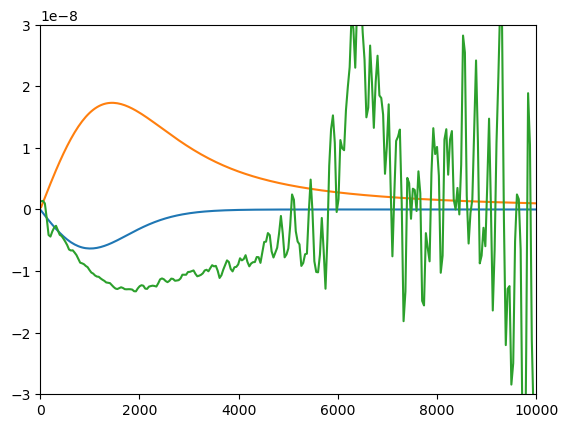

2201 183.80610730536668 0.06112920285094833 1.0001231987965498
2202 183.88961757674576 0.061135608519195125 1.0001231697634874
2203 183.97312784812485 0.06114530301991534 1.0001231455407802
2204 184.05663811950396 0.0611605258087861 1.0001231124791332
2205 184.14014839088304 0.06116821805897858 1.0001230882073089
2206 184.22365866226212 0.06117462724043405 1.0001230583111238
2207 184.3071689336412 0.06118456691126223 1.0001230335117341
2208 184.3906792050203 0.06119300108601153 1.0001230001236698
2209 184.47418947639937 0.061198543884575664 1.0001229780153282
2210 184.55769974777846 0.06121025373501683 1.000122945822619
2211 184.64121001915754 0.061217094241700666 1.0001229237130231
2212 184.72472029053662 0.061216478452711214 1.0001228936064253
2213 184.8082305619157 0.061225407828011634 1.0001228726560076
2214 184.8917408332948 0.06123059969389667 1.000122844055155
2215 184.97525110467387 0.06123398632386205 1.0001228243617017
2216 185.05876137605296 0.06124665778234089 1.00012279455

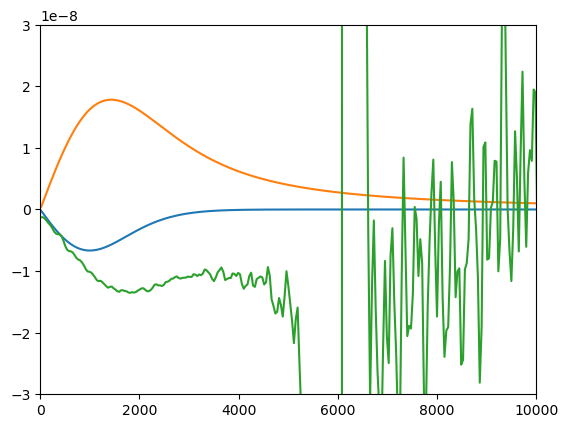

2301 192.15713444327523 0.06235235286673091 1.0001204319060264
2302 192.2406447146543 0.0623669617671141 1.0001204069129854
2303 192.3241549860334 0.062380434389907764 1.0001203915579018
2304 192.40766525741248 0.06238649086766122 1.0001203675128099
2305 192.49117552879156 0.0623888040133165 1.0001203560947087
2306 192.57468580017064 0.062391138297075446 1.00012033401715
2307 192.65819607154972 0.06240008291253766 1.0001203231363387
2308 192.7417063429288 0.06241118483768873 1.0001203016249989
2309 192.8252166143079 0.0624170911869808 1.0001202936630542
2310 192.90872688568697 0.06242311790146086 1.0001202755381526
2311 192.99223715706606 0.06242927303133532 1.0001202664327937
2312 193.07574742844514 0.06243649518160833 1.0001202512643022
2313 193.15925769982425 0.06243817492765642 1.0001202437645695
2314 193.24276797120334 0.06243676162129694 1.000120232370408
2315 193.32627824258242 0.06243706028572099 1.0001202228857262
2316 193.4097885139615 0.06244078308293777 1.0001202160169524
2

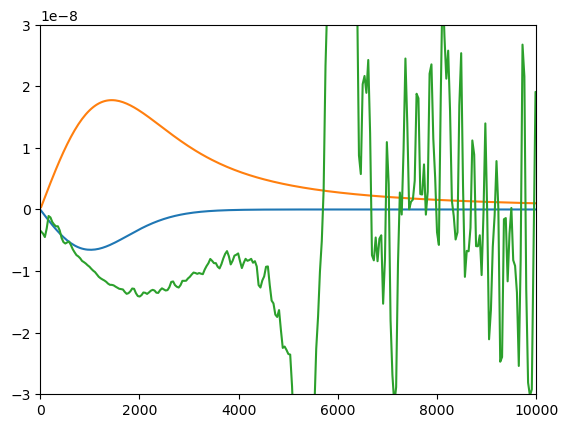

2401 200.50816158118374 0.061933113829984746 1.0001208031319688
2402 200.59167185256283 0.06193545589728406 1.0001208012387988
2403 200.6751821239419 0.06194439173017674 1.0001208040044602
2404 200.758692395321 0.06194742726981323 1.0001208028220898
2405 200.84220266670008 0.061953328993691915 1.0001208048340167
2406 200.92571293807916 0.06196150345869947 1.000120803195494
2407 201.00922320945824 0.06196371249318755 1.0001208021234143
2408 201.09273348083735 0.06196151624260524 1.0001208051850763
2409 201.17624375221644 0.06196494384552399 1.0001208030796696
2410 201.25975402359552 0.06196418029828593 1.0001208069054628
2411 201.3432642949746 0.06196261680435002 1.0001208065382405
2412 201.42677456635369 0.061968140134111 1.0001208096915117
2413 201.51028483773277 0.06196760124139645 1.000120810160458
2414 201.59379510911185 0.06197168219853495 1.000120815844047
2415 201.67730538049094 0.06197898143786366 1.0001208118612122
2416 201.76081565187002 0.061981818633313854 1.000120817524880

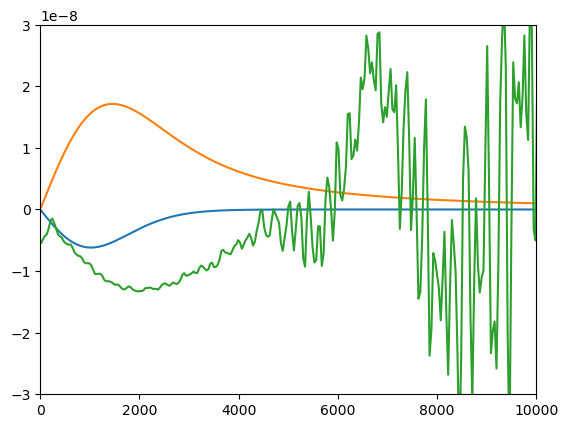

2501 208.85918871909226 0.060536236247748496 1.000123797725347
2502 208.94269899047134 0.06050332887009719 1.0001238594061297
2503 209.02620926185045 0.06047605062862513 1.0001239135398794
2504 209.10971953322954 0.06044255191267683 1.0001239784814564
2505 209.19322980460862 0.06040963011974566 1.0001240357733419
2506 209.2767400759877 0.06038052057072662 1.000124098056064
2507 209.3602503473668 0.06034560741139914 1.0001241541724057
2508 209.44376061874587 0.06031298006165597 1.000124216002049
2509 209.52727089012495 0.060283921144932404 1.0001242696463166
2510 209.61078116150404 0.06025318302738579 1.0001243318317754
2511 209.69429143288312 0.0602244504095277 1.000124385945127
2512 209.7778017042622 0.06019598552960574 1.000124450089115
2513 209.86131197564129 0.060169093474304276 1.0001245038886644
2514 209.94482224702037 0.06014359063106619 1.000124564432881
2515 210.02833251839945 0.060115105966939794 1.0001246193335278
2516 210.11184278977856 0.06008635223608357 1.000124680106554

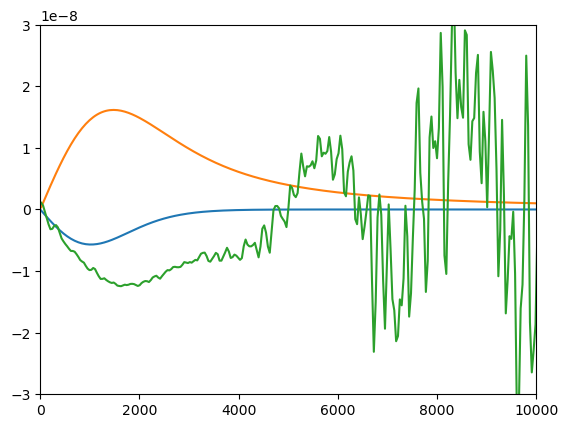

2601 217.2102158570008 0.05849394835539881 1.0001288727182862
2602 217.2937261283799 0.05846912329853428 1.000128942227015
2603 217.37723639975897 0.0584427703509328 1.0001290027963121
2604 217.46074667113805 0.05841615540402051 1.0001290724326706
2605 217.54425694251714 0.058380618314834265 1.0001291358164957
2606 217.62776721389622 0.05834882344817037 1.000129208387279
2607 217.7112774852753 0.05831944037603785 1.0001292745495018
2608 217.7947877566544 0.058283923199483334 1.0001293496138746
2609 217.87829802803347 0.05824810922572204 1.0001294177832571
2610 217.96180829941255 0.058211963544171234 1.0001294932783926
2611 218.04531857079166 0.058177901999311825 1.0001295631524485
2612 218.12882884217075 0.05814289062255067 1.0001296377922058
2613 218.21233911354983 0.05811038181445812 1.0001297113091872
2614 218.2958493849289 0.05808138288548381 1.0001297862071
2615 218.379359656308 0.058050073753932965 1.0001298620905354
2616 218.46286992768708 0.058012959649328226 1.0001299375399146

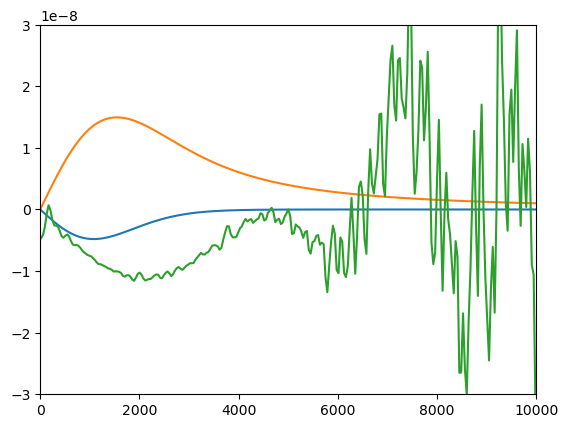

2701 225.56124299490932 0.05494930747507377 1.0001365831919644
2702 225.6447532662884 0.054938588847501406 1.0001366354201808
2703 225.7282635376675 0.05492106332081357 1.0001366869992565
2704 225.81177380904657 0.054898136230001025 1.0001367395292282
2705 225.89528408042565 0.05488000825805605 1.000136791320389
2706 225.97879435180477 0.054859013562883356 1.0001368422834975
2707 226.06230462318385 0.054838092872159135 1.0001368951276515
2708 226.14581489456293 0.05481801318724424 1.0001369428799152
2709 226.22932516594202 0.05480137495100844 1.0001369936425657
2710 226.3128354373211 0.054783248248600584 1.000137038559963
2711 226.39634570870018 0.054769866833175744 1.000137088301609
2712 226.47985598007926 0.05476005451272733 1.0001371300719113
2713 226.56336625145835 0.05474644129857791 1.0001371791336633
2714 226.64687652283743 0.054732296448211704 1.0001372212589366
2715 226.7303867942165 0.0547138097996675 1.0001372702628946
2716 226.8138970655956 0.05470268431083397 1.00013731315

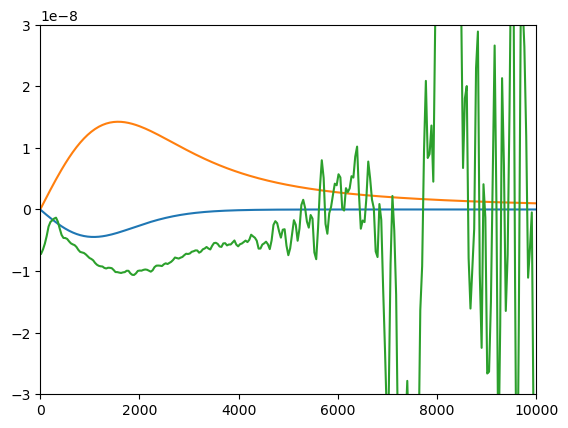

2801 233.91227013281787 0.053345062790522146 1.0001409875957954
2802 233.99578040419695 0.05331851337681317 1.0001410290337691
2803 234.07929067557603 0.05330358565257193 1.0001410756077065
2804 234.16280094695512 0.053278301200507555 1.0001411151409778
2805 234.2463112183342 0.05324599681110204 1.0001411617160618
2806 234.32982148971328 0.053220802373310165 1.0001412022633571
2807 234.41333176109237 0.05320120036120871 1.0001412493705135
2808 234.49684203247145 0.053180586607438414 1.000141286948812
2809 234.58035230385053 0.05315920691947872 1.000141334022205
2810 234.66386257522962 0.05313696857078754 1.0001413733365137
2811 234.7473728466087 0.05311138863485584 1.0001414198359175
2812 234.83088311798778 0.05308733151707593 1.0001414581268264
2813 234.91439338936686 0.053064408560509216 1.000141503166536
2814 234.99790366074595 0.053039910178833416 1.0001415427284726
2815 235.08141393212506 0.0530153980187827 1.000141584997082
2816 235.16492420350414 0.052988913474481335 1.000141625

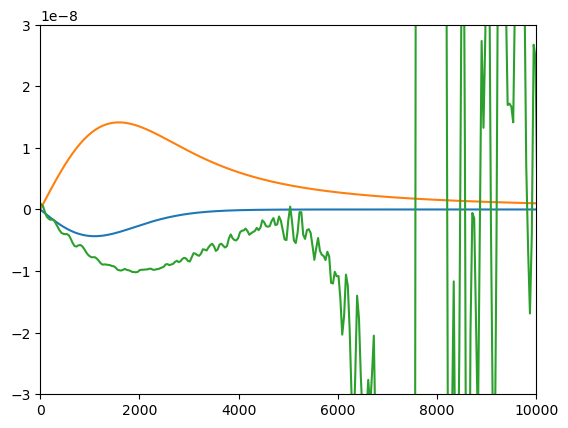

2901 242.26329727072638 0.052900275052882896 1.0001419497305273
2902 242.34680754210547 0.052922736546235985 1.000141909593336
2903 242.43031781348455 0.05294608902876678 1.00014187546489
2904 242.51382808486363 0.052967813639594505 1.0001418362358958
2905 242.59733835624272 0.052992905257186265 1.0001417980066891
2906 242.6808486276218 0.053018090868823156 1.000141754550867
2907 242.76435889900088 0.05303936885377008 1.0001417158304762
2908 242.84786917037997 0.05306764527963695 1.0001416742379599
2909 242.93137944175905 0.053097438686236224 1.0001416327695145
2910 243.01488971313816 0.053119648863733875 1.0001415930223936
2911 243.09839998451724 0.053146116841637434 1.0001415508488674
2912 243.18191025589633 0.05317536373746447 1.0001415078134646
2913 243.2654205272754 0.05320005263310259 1.0001414605565888
2914 243.3489307986545 0.05322571990217639 1.0001414196182448
2915 243.43244107003358 0.053247605681676885 1.000141372430028
2916 243.51595134141266 0.053268859971369285 1.0001413

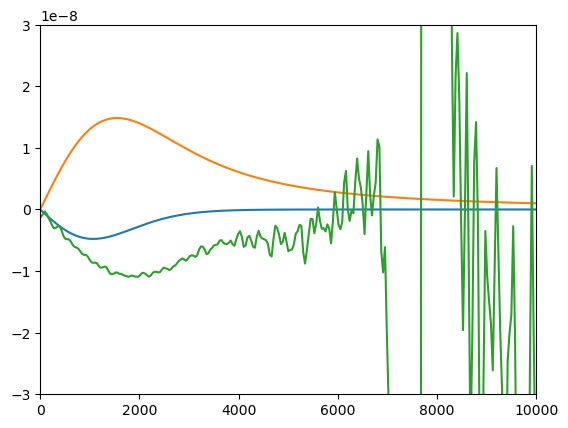

3001 250.6143244086349 0.05485923914453544 1.000137438600403
3002 250.69783468001398 0.054874421365915756 1.0001373983083497
3003 250.78134495139307 0.05489100447533886 1.0001373530472935
3004 250.86485522277215 0.0549062199913362 1.0001373129124855
3005 250.94836549415126 0.05491610274886767 1.0001372674319877
3006 251.03187576553034 0.05492882608277544 1.0001372277735028
3007 251.11538603690943 0.05494493327295077 1.0001371797160608
3008 251.1988963082885 0.054954296150125224 1.000137142586441
3009 251.2824065796676 0.054971977621031835 1.0001370939808192
3010 251.36591685104668 0.05499073370358462 1.0001370568073407
3011 251.44942712242576 0.05499976769009274 1.0001370082982906
3012 251.53293739380484 0.05501911650668027 1.0001369651268104
3013 251.61644766518393 0.055034459411214404 1.0001369174603865
3014 251.699957936563 0.05504599579523867 1.0001368737614043
3015 251.7834682079421 0.05505898625409874 1.0001368232316994
3016 251.86697847932118 0.055072332095249574 1.0001367797480

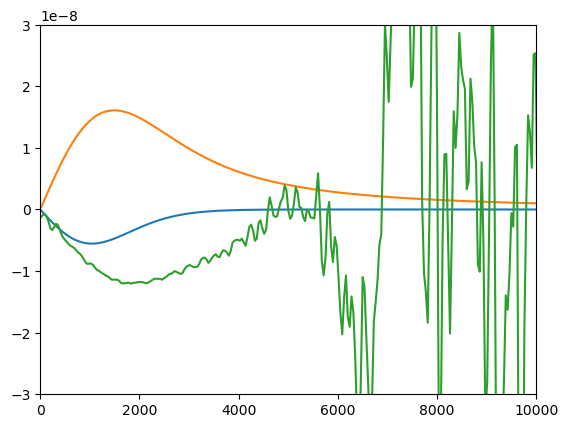

3101 258.96535154654345 0.058092417498619195 1.0001294912486047
3102 259.0488618179225 0.05814039960893051 1.0001293772294437
3103 259.1323720893016 0.058193590947106126 1.0001292561735007
3104 259.21588236068067 0.058247907433327056 1.000129138838556
3105 259.2993926320598 0.05828782759119599 1.0001290218288998
3106 259.3829029034389 0.05833923846554943 1.0001289041522634
3107 259.46641317481794 0.058394858071248085 1.0001287837106096
3108 259.54992344619706 0.058438995529773094 1.0001286692940508
3109 259.6334337175761 0.05848895800253553 1.0001285480483166
3110 259.7169439889552 0.0585401341999765 1.0001284282683687
3111 259.8004542603343 0.05859401007224327 1.0001283093733713
3112 259.8839645317134 0.058643331683613416 1.0001281900604517
3113 259.96747480309244 0.05869071322949157 1.0001280766777505
3114 260.05098507447155 0.05874393382070108 1.00012795910786
3115 260.1344953458506 0.058794201408028816 1.00012784471782
3116 260.2180056172297 0.05884162354595304 1.0001277286188037
3

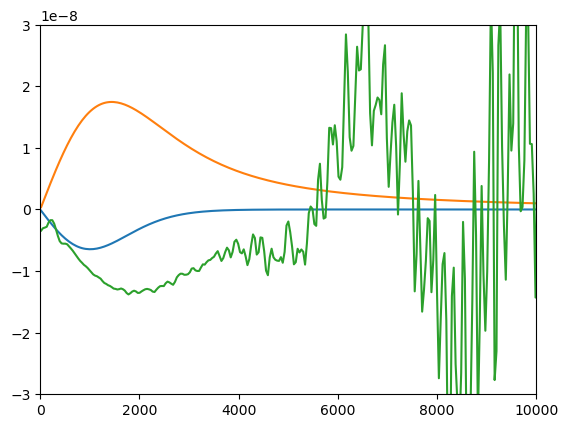

3201 267.316378684452 0.061523885522262754 1.0001213589794835
3202 267.39988895583105 0.06153903976153545 1.0001213260322255
3203 267.48339922721016 0.061554714855160925 1.0001212883581592
3204 267.5669094985892 0.06155850189057931 1.0001212564704214
3205 267.6504197699683 0.06157156183710236 1.0001212218641244
3206 267.7339300413474 0.06158341211968119 1.0001211872826137
3207 267.8174403127265 0.06159015412393617 1.0001211565474264
3208 267.90095058410554 0.0616006764614962 1.000121122916961
3209 267.98446085548466 0.061607258576522196 1.0001210895307917
3210 268.0679711268637 0.061617881921407644 1.000121056349588
3211 268.1514813982428 0.06163198363122401 1.0001210264158902
3212 268.2349916696219 0.061645703342717045 1.0001209921546514
3213 268.318501941001 0.06165718373066368 1.0001209628211587
3214 268.40201221238004 0.06166414695429517 1.000120928556495
3215 268.48552248375915 0.06167216437957702 1.0001209034066165
3216 268.56903275513827 0.06168623862837974 1.0001208683055114
32

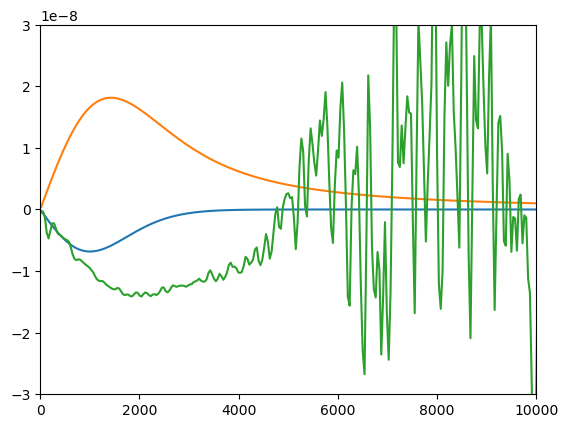

3301 275.6674058223605 0.0629550173013995 1.000117437441913
3302 275.7509160937396 0.06296857159662324 1.0001173909670455
3303 275.83442636511865 0.06298927603025682 1.0001173521904274
3304 275.91793663649776 0.06300852415896811 1.0001173030801125
3305 276.0014469078768 0.06303104690268665 1.000117265835412
3306 276.0849571792559 0.06305976452801391 1.0001172173871198
3307 276.168467450635 0.06307246408289761 1.0001171837389182
3308 276.2519777220141 0.06308403642662001 1.0001171368947337
3309 276.33548799339314 0.06310507233933395 1.0001171041354582
3310 276.41899826477226 0.06312377552904469 1.0001170574406935
3311 276.50250853615137 0.06314554668981934 1.000117022747033
3312 276.5860188075304 0.06317196161551651 1.000116977216497
3313 276.66952907890953 0.06319354901891007 1.000116941047805
3314 276.7530393502886 0.06320635707641045 1.0001168990597085
3315 276.8365496216677 0.06321690129909972 1.0001168635335422
3316 276.92005989304675 0.06323788425463335 1.0001168244356677
3317 277

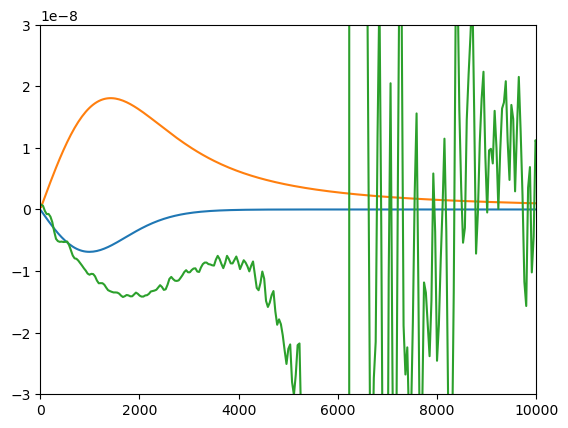

3401 284.018432960269 0.06300536270607664 1.000118282496498
3402 284.1019432316481 0.06298547940759351 1.000118348925629
3403 284.1854535030272 0.0629489104300049 1.0001184275357373
3404 284.26896377440625 0.06291508976297018 1.0001184974882942
3405 284.35247404578536 0.06289724079325024 1.000118570996773
3406 284.43598431716447 0.06287585154914482 1.0001186423780632
3407 284.5194945885435 0.06284502069614469 1.0001187181652273
3408 284.60300485992263 0.06281752319956234 1.0001187932536826
3409 284.6865151313017 0.06278864046986357 1.000118867909132
3410 284.7700254026808 0.062755208528293 1.0001189465509261
3411 284.85353567405986 0.06272480376062685 1.0001190215528326
3412 284.93704594543897 0.06269067851688237 1.0001191038260222
3413 285.020556216818 0.06265533434055218 1.000119179931928
3414 285.10406648819713 0.0626260094249264 1.000119262659116
3415 285.1875767595762 0.06259643115522756 1.000119339973754
3416 285.2710870309553 0.06256629320510224 1.0001194255071642
3417 285.35459

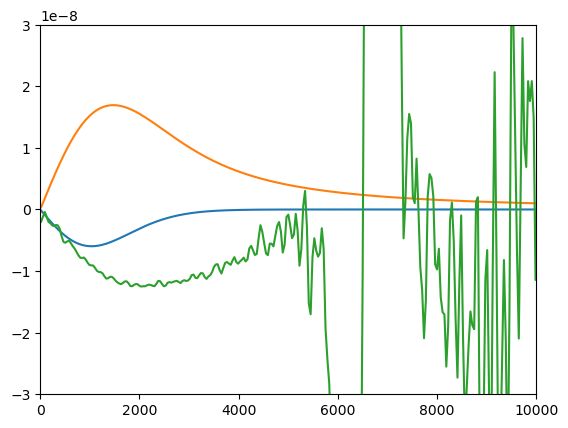

3501 292.36946009817757 0.05982815826176924 1.0001258060252898
3502 292.4529703695566 0.05981349425288066 1.000125859523897
3503 292.53648064093574 0.05979836000121866 1.000125911179239
3504 292.6199909123148 0.05977623599004569 1.0001259655514192
3505 292.7035011836939 0.05975075113328888 1.0001260137934964
3506 292.78701145507296 0.05973670987297197 1.000126065292563
3507 292.87052172645207 0.05971710448186956 1.0001261153686485
3508 292.9540319978311 0.05968808599611167 1.0001261681428795
3509 293.03754226921023 0.05966613495990725 1.0001262142545861
3510 293.1210525405893 0.05964296545478133 1.0001262688055903
3511 293.2045628119684 0.05962222317926876 1.000126317529674
3512 293.28807308334746 0.05960664291886897 1.000126368103147
3513 293.37158335472657 0.05958493579042162 1.0001264145294586
3514 293.4550936261057 0.05956667332126407 1.0001264659426818
3515 293.53860389748473 0.059553846357195496 1.0001265091064075
3516 293.62211416886385 0.059535136212302296 1.0001265617419175
35

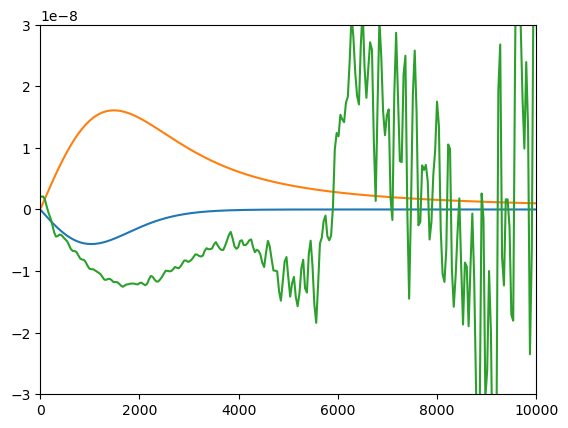

3601 300.72048723608606 0.05821885475517208 1.0001303989872796
3602 300.80399750746517 0.05819611793836906 1.0001304587967113
3603 300.8875077788442 0.05816399741824369 1.0001305126754654
3604 300.97101805022334 0.05814029862875282 1.0001305736864325
3605 301.0545283216024 0.058119956630892554 1.0001306251806599
3606 301.1380385929815 0.05809138475219226 1.0001306874322033
3607 301.22154886436056 0.0580648767672962 1.0001307436603295
3608 301.30505913573967 0.05804156576032241 1.0001308063353995
3609 301.3885694071188 0.05801079135403591 1.0001308632717139
3610 301.47207967849783 0.05797959020009547 1.00013092714048
3611 301.55558994987695 0.057951771057644784 1.0001309848489375
3612 301.639100221256 0.05792136869114235 1.0001310476999055
3613 301.7226104926351 0.05789151365896463 1.0001311064575105
3614 301.80612076401417 0.057863429588746726 1.0001311687573138
3615 301.8896310353933 0.05784070750187926 1.0001312251615828
3616 301.97314130677233 0.05781622344321994 1.000131287382785
3

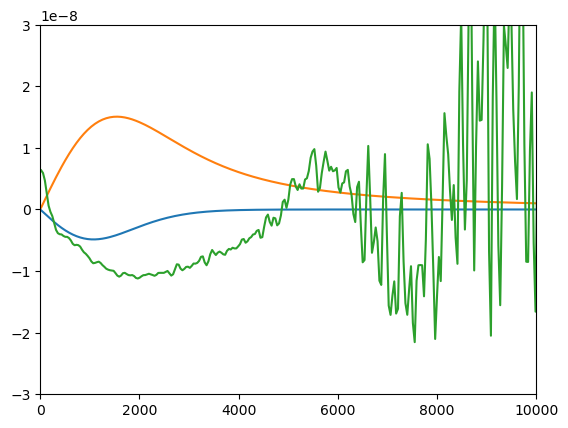

3701 309.0715143739946 0.05521687232761917 1.0001361610490849
3702 309.15502464537366 0.05519434078882993 1.0001362088060652
3703 309.23853491675277 0.0551655686120461 1.0001362475063535
3704 309.3220451881319 0.05513651239762776 1.0001362940525391
3705 309.40555545951094 0.05511001336140407 1.0001363332048103
3706 309.48906573089005 0.0550820205259299 1.0001363763412054
3707 309.5725760022691 0.05505394447133746 1.000136416930071
3708 309.6560862736482 0.0550368511091186 1.0001364562128054
3709 309.73959654502727 0.05502197102647808 1.000136495651106
3710 309.8231068164064 0.054995901532509626 1.0001365344023174
3711 309.90661708778543 0.05496377730095188 1.0001365780800946
3712 309.99012735916455 0.05493922862771906 1.0001366129195899
3713 310.0736376305436 0.054919359478650995 1.0001366533520866
3714 310.1571479019227 0.054901972362858154 1.0001366870776942
3715 310.24065817330177 0.0548876235090507 1.0001367241042534
3716 310.3241684446809 0.0548671195824745 1.0001367549179367
3717

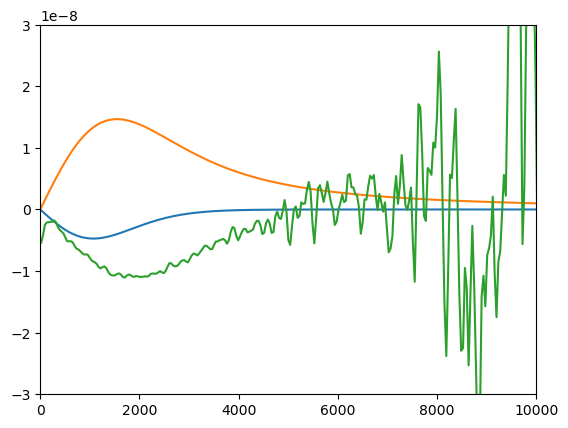

3801 317.42254151190315 0.05450620887886711 1.0001378887264438
3802 317.5060517832822 0.05450511087573373 1.000137893557172
3803 317.5895620546613 0.054504470904659374 1.0001379010014424
3804 317.67307232604037 0.054510860890266306 1.0001379046460521
3805 317.7565825974195 0.05451343475592718 1.0001379112094682
3806 317.84009286879854 0.05451182600338263 1.0001379148617913
3807 317.92360314017765 0.05451557526480693 1.0001379230535345
3808 318.0071134115567 0.05451792664115868 1.0001379244856619
3809 318.0906236829358 0.05452212668893143 1.0001379315277037
3810 318.17413395431487 0.05452564642597529 1.0001379302570241
3811 318.257644225694 0.05452556128493464 1.0001379386792866
3812 318.3411544970731 0.05452774058890686 1.0001379387681244
3813 318.42466476845215 0.05453136202913687 1.0001379465616098
3814 318.50817503983126 0.05453813660272963 1.0001379457158
3815 318.5916853112103 0.05454478284239104 1.0001379537277992
3816 318.6751955825894 0.054552494714395716 1.0001379540793367
381

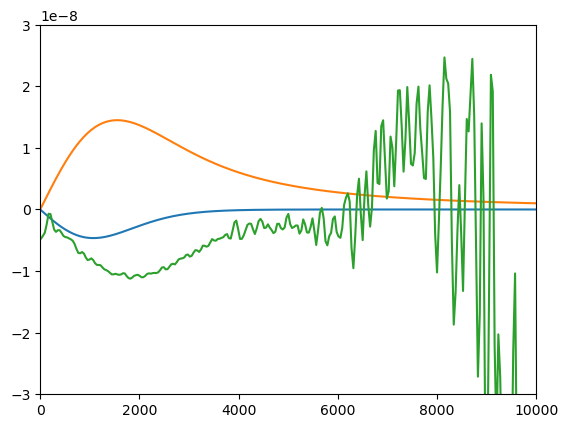

3901 325.77356864981164 0.05412243199661979 1.00013914024797
3902 325.85707892119075 0.0540994229179582 1.0001391607758747
3903 325.9405891925698 0.05408216443064952 1.000139187465271
3904 326.0240994639489 0.05407001685286417 1.0001392049975113
3905 326.10760973532797 0.05405486408744894 1.0001392317155204
3906 326.1911200067071 0.05404468293456532 1.0001392495899295
3907 326.2746302780862 0.054037887837280356 1.0001392753557938
3908 326.35814054946525 0.05402198887679893 1.0001392944781264
3909 326.44165082084436 0.054002661482991154 1.0001393209207219
3910 326.5251610922234 0.053983108408210925 1.00013934180525
3911 326.6086713636025 0.0539677713174635 1.000139365495051
3912 326.6921816349816 0.05395773600926605 1.0001393856669265
3913 326.7756919063607 0.05394278494529926 1.0001394075639383
3914 326.85920217773975 0.053925202034254986 1.000139427653749
3915 326.94271244911886 0.05391121456299699 1.0001394477975112
3916 327.0262227204979 0.0539012641185075 1.000139467606539
3917 327

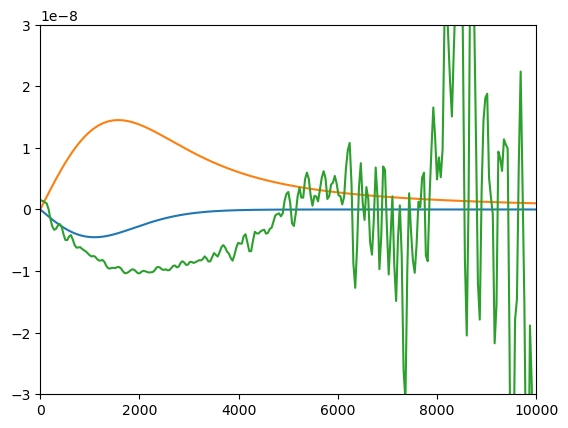

4001 334.1245957877202 0.05373371114175661 1.0001395639222797
4002 334.2081060590993 0.05374797451694322 1.0001395396178197
4003 334.29161633047835 0.05375731988189579 1.0001395161418167
4004 334.37512660185746 0.053766402887863676 1.000139492500668
4005 334.4586368732365 0.053779207362808217 1.0001394676459041
4006 334.5421471446156 0.05379270542108641 1.000139444672865
4007 334.6256574159947 0.053807022721065356 1.0001394172660312
4008 334.7091676873738 0.05381599059114806 1.0001393929198024
4009 334.79267795875285 0.053830442796563974 1.0001393622669636
4010 334.87618823013196 0.05384178129586292 1.000139334471767
4011 334.959698501511 0.053850051213187006 1.0001393069940547
4012 335.0432087728901 0.05387171657897208 1.0001392802364872
4013 335.1267190442692 0.05388755226115246 1.0001392471464192
4014 335.2102293156483 0.053901776592326985 1.0001392187840987
4015 335.2937395870274 0.05392012045938439 1.0001391841575789
4016 335.37724985840646 0.05394091832812542 1.0001391534298012
4

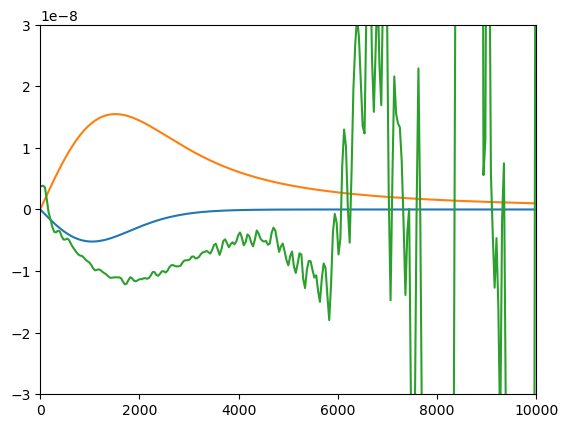

4101 342.4756229256287 0.056668115738197126 1.0001341357482065
4102 342.5591331970078 0.056699691683949685 1.0001340692488816
4103 342.6426434683869 0.056722395028052576 1.0001340026964427
4104 342.72615373976595 0.05675517532634726 1.000133937826885
4105 342.80966401114506 0.056785759755742404 1.0001338717202832
4106 342.8931742825241 0.05681524149137744 1.0001338041623944
4107 342.9766845539032 0.05684141246396304 1.0001337360768843
4108 343.0601948252823 0.056871116951513354 1.0001336699492336
4109 343.1437050966614 0.056909273751267433 1.0001336001822767
4110 343.2272153680405 0.056940070383978234 1.0001335360860677
4111 343.31072563941956 0.056967200481396515 1.0001334712025922
4112 343.39423591079867 0.05699825742707592 1.0001334053245556
4113 343.4777461821777 0.05702725116772459 1.0001333371722656
4114 343.56125645355684 0.05705322205487139 1.0001332703073285
4115 343.6447667249359 0.05707937073811077 1.000133203779875
4116 343.728276996315 0.05710887386938909 1.000133138427152

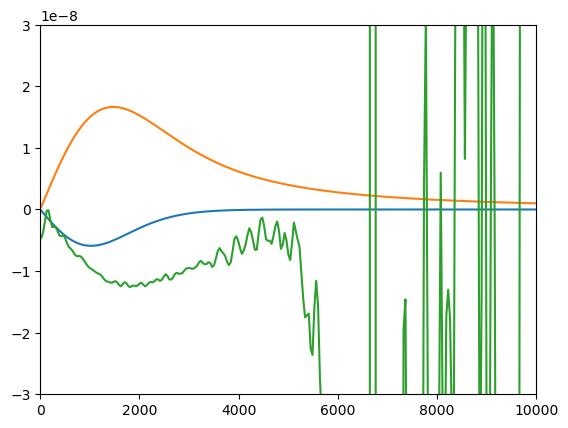

4201 350.8266500635372 0.059472068071142165 1.0001272797645326
4202 350.9101603349163 0.05949421127002043 1.000127218317284
4203 350.9936706062954 0.05951397532494659 1.0001271556422584
4204 351.0771808776745 0.05953217878738195 1.0001270936948696
4205 351.1606911490536 0.05955316605410658 1.0001270299254523
4206 351.24420142043266 0.05957411306359074 1.0001269678551534
4207 351.32771169181177 0.059590809138827826 1.0001269020212409
4208 351.4112219631908 0.059609071042458876 1.000126841364628
4209 351.49473223456994 0.05963243950411163 1.0001267784932901
4210 351.578242505949 0.05965146632807849 1.0001267160626348
4211 351.6617527773281 0.059672336574922186 1.0001266513676534
4212 351.74526304870716 0.059696146395295906 1.0001265906175651
4213 351.82877332008627 0.059719237460159474 1.000126527937988
4214 351.9122835914653 0.05973521697132991 1.0001264668639709
4215 351.99579386284444 0.05975173043279467 1.0001264035410087
4216 352.0793041342235 0.059770735962753355 1.0001263426216234

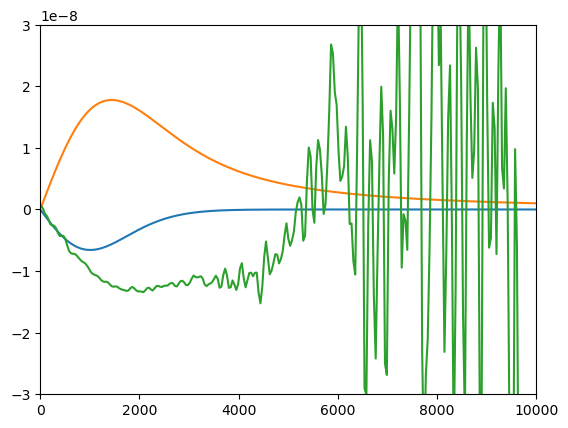

4301 359.17767720144576 0.06210023105866053 1.0001197278327796
4302 359.2611874728249 0.06213353073872131 1.0001196420156946
4303 359.3446977442039 0.062170298384911345 1.0001195518764248
4304 359.42820801558304 0.06220704470138631 1.0001194700979468
4305 359.5117182869621 0.06224284933758126 1.0001193820547074
4306 359.5952285583412 0.062271902759895574 1.0001192996889872
4307 359.67873882972026 0.06230223073644823 1.0001192133304082
4308 359.76224910109937 0.0623413457730876 1.0001191292898768
4309 359.8457593724784 0.062375748466399136 1.0001190447607724
4310 359.92926964385754 0.062407552362668185 1.000118960331581
4311 360.0127799152366 0.062448266315156355 1.0001188723505376
4312 360.0962901866157 0.06248117696170311 1.0001187874771993
4313 360.17980045799476 0.0625079829824565 1.0001187063753312
4314 360.26331072937387 0.06254561934146215 1.000118621282635
4315 360.346821000753 0.06258455068009579 1.0001185401392156
4316 360.43033127213204 0.06261590892527602 1.000118455679189
4

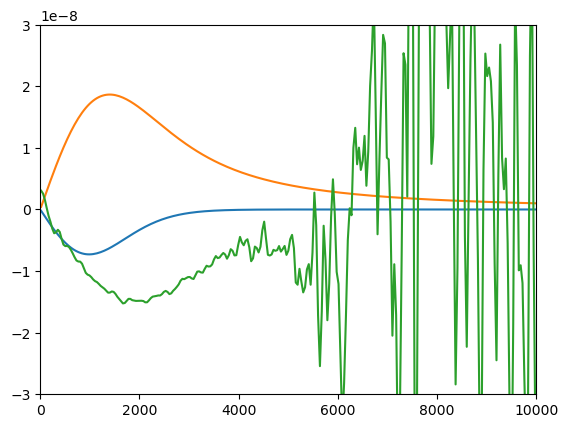

4401 367.5287043393543 0.06442469332696649 1.0001137767160841
4402 367.61221461073336 0.06443868629039402 1.0001137570977732
4403 367.6957248821125 0.06444974641318264 1.0001137447056057
4404 367.7792351534915 0.064461101515827 1.0001137259360222
4405 367.86274542487064 0.06446961668097606 1.0001137164548495
4406 367.9462556962497 0.06447978832487426 1.0001136996958304
4407 368.0297659676288 0.0644930572332921 1.000113691457657
4408 368.1132762390079 0.06450845644426903 1.0001136760018556
4409 368.19678651038697 0.06452712462032198 1.000113668249178
4410 368.2802967817661 0.06453356985315559 1.000113656679091
4411 368.36380705314514 0.06454292744256807 1.0001136523222338
4412 368.44731732452425 0.06455096034955794 1.0001136437942109
4413 368.5308275959033 0.06454063192552195 1.000113647032149
4414 368.6143378672824 0.06454967054035451 1.000113641380206
4415 368.69784813866147 0.06456399895466576 1.0001136418633965
4416 368.7813584100406 0.06456624716882317 1.0001136439575022
4417 368.8

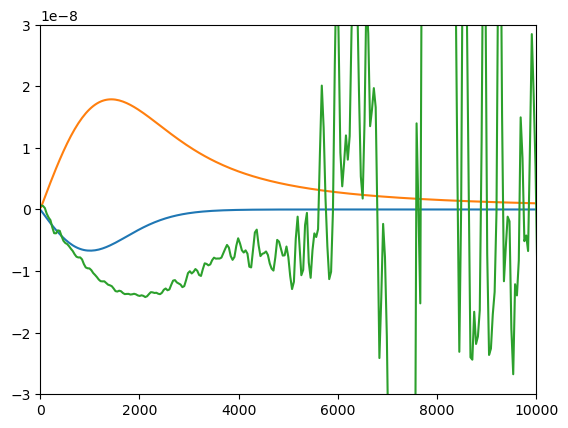

4501 375.8797314772628 0.06235175509479746 1.0001192122930398
4502 375.9632417486419 0.062307172108477187 1.0001193149163048
4503 376.046752020021 0.06226464631058849 1.0001194212854092
4504 376.1302622914001 0.06222502358675612 1.00011952342428
4505 376.2137725627792 0.062181475606297804 1.0001196292288235
4506 376.29728283415824 0.06213398315029782 1.000119735979991
4507 376.38079310553735 0.0620915680234758 1.0001198424900564
4508 376.4643033769164 0.06204938992957481 1.000119949116493
4509 376.5478136482955 0.062008062249746636 1.0001200531927388
4510 376.63132391967457 0.06196779324353318 1.0001201600519583
4511 376.7148341910537 0.06192682022842371 1.0001202640336662
4512 376.79834446243274 0.061888528603652786 1.0001203730144785
4513 376.88185473381185 0.06184234594137164 1.0001204756790985
4514 376.9653650051909 0.06180298496281268 1.000120584327952
4515 377.04887527657 0.06176260197096691 1.0001206832923721
4516 377.13238554794907 0.06171842723196982 1.0001207909556982
4517 37

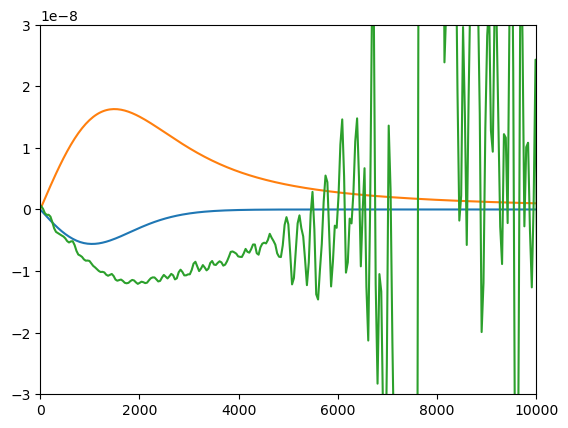

4601 384.23075861517134 0.058305620323632644 1.0001291042918639
4602 384.31426888655045 0.05826675538461505 1.0001291993137962
4603 384.3977791579295 0.058225931471121366 1.0001292873547427
4604 384.4812894293086 0.058181557542465706 1.0001293809277976
4605 384.5647997006877 0.05813854548509388 1.000129465795802
4606 384.6483099720668 0.058102307977259994 1.0001295572640856
4607 384.73182024344584 0.0580702979288789 1.0001296414974736
4608 384.81533051482495 0.05803144838213142 1.0001297301916643
4609 384.898840786204 0.05799178256992838 1.000129815282901
4610 384.9823510575831 0.05796071550720146 1.0001299021069623
4611 385.06586132896217 0.05792558651641148 1.000129987550729
4612 385.1493716003413 0.05788228217829392 1.0001300777336262
4613 385.2328818717204 0.05783822014248708 1.0001301636334459
4614 385.31639214309945 0.057799728580215044 1.0001302480473586
4615 385.39990241447856 0.057763543908654374 1.0001303316503607
4616 385.4834126858576 0.05772498266364955 1.0001304135674465


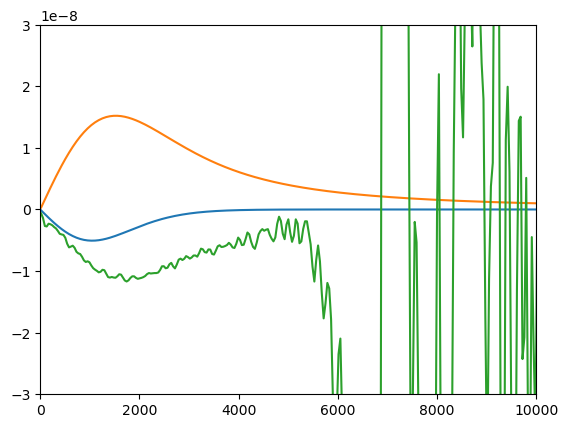

4701 392.5817857530799 0.0559775066920172 1.0001351583701832
4702 392.66529602445894 0.05595672335203527 1.000135208418231
4703 392.74880629583805 0.055932977206233456 1.0001352605798748
4704 392.8323165672171 0.055914905914473456 1.0001353116726244
4705 392.9158268385962 0.05589292791801045 1.0001353671908662
4706 392.9993371099753 0.055869845843077755 1.000135420633007
4707 393.0828473813544 0.055856216598135264 1.0001354725352782
4708 393.1663576527335 0.05583379510767946 1.0001355306312472
4709 393.24986792411255 0.0558076248282619 1.0001355892733825
4710 393.33337819549166 0.05578804755222446 1.0001356438436606
4711 393.4168884668707 0.05576392686967513 1.000135701664166
4712 393.5003987382498 0.05573726873499634 1.0001357598521188
4713 393.5839090096289 0.055716990883058405 1.0001358185407547
4714 393.667419281008 0.055691640735577044 1.0001358770826794
4715 393.75092955238705 0.055662696456187405 1.0001359368669502
4716 393.83443982376616 0.055640012859190666 1.0001359939464032


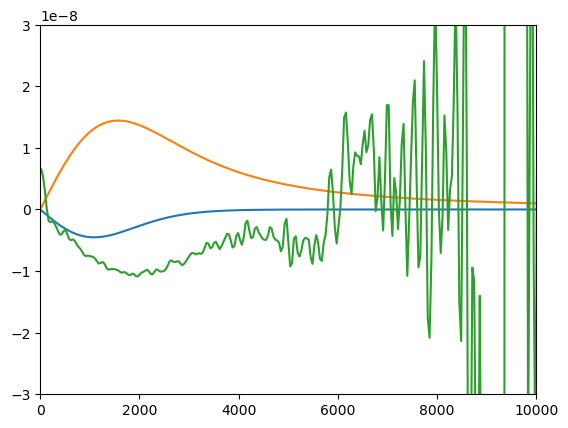

4801 400.9328128909884 0.05368550220907244 1.00014068518962
4802 401.0163231623675 0.053673992432122196 1.000140716751217
4803 401.0998334337466 0.05366187787162794 1.000140746428262
4804 401.18334370512565 0.053653727654221404 1.000140776412692
4805 401.26685397650476 0.053646045058804485 1.0001408040421256
4806 401.3503642478838 0.05364360332872783 1.0001408309788462
4807 401.43387451926293 0.0536365570762248 1.000140857430364
4808 401.517384790642 0.053635341452394465 1.0001408827073581
4809 401.6008950620211 0.05362746192426304 1.000140907733898
4810 401.68440533340015 0.053615975600284166 1.0001409344723369
4811 401.76791560477926 0.0536167156226917 1.0001409564753108
4812 401.8514258761583 0.05361224763789388 1.0001409815681568
4813 401.9349361475374 0.05360531570670861 1.0001410064308296
4814 402.0184464189165 0.05359489663646609 1.0001410300888267
4815 402.1019566902956 0.05358355051657097 1.0001410517471603
4816 402.1854669616747 0.053576106564443546 1.0001410741095855
4817 40

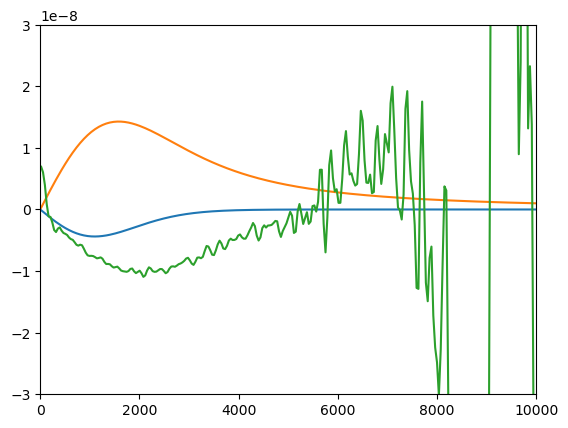

4901 409.2838400288969 0.053147942219686134 1.000141404164943
4902 409.36735030027603 0.053152245887386526 1.0001413781194202
4903 409.4508605716551 0.053159547024520776 1.0001413468687732
4904 409.5343708430342 0.05316816832133715 1.0001413174133167
4905 409.61788111441325 0.05317258889139096 1.0001412869972182
4906 409.70139138579236 0.05317253555199899 1.0001412539593046
4907 409.7849016571714 0.05317782142187203 1.0001412199901338
4908 409.86841192855053 0.05319282201325474 1.000141182645164
4909 409.9519221999296 0.05320253845134404 1.0001411487451444
4910 410.0354324713087 0.05320669485772486 1.0001411087299394
4911 410.1189427426878 0.053208364692285404 1.0001410744344783
4912 410.20245301406686 0.05321517235127863 1.0001410328961007
4913 410.285963285446 0.053223587686959964 1.000140997114069
4914 410.369473556825 0.05323581644452856 1.000140952757955
4915 410.45298382820414 0.053253872110859364 1.0001409135709889
4916 410.5364940995832 0.05326566037238568 1.0001408653717698
49

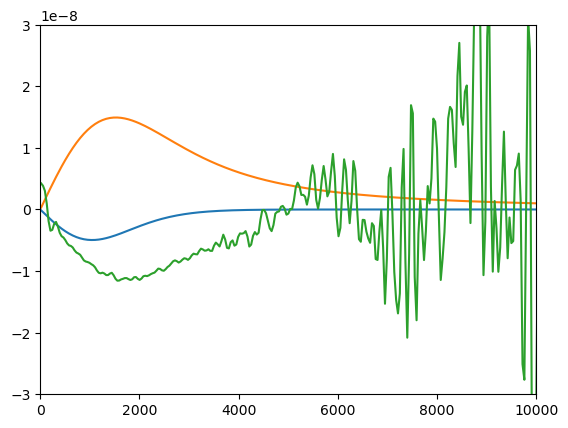

5001 417.63486716680546 0.05547427945966565 1.0001353454563962
5002 417.7183774381845 0.05548823613915426 1.0001352924421125
5003 417.80188770956363 0.05550764454303922 1.0001352479382009
5004 417.8853979809427 0.05553246627140546 1.0001351928408788
5005 417.9689082523218 0.05554403034182012 1.0001351496749096
5006 418.0524185237009 0.0555560784537724 1.0001350969567233
5007 418.13592879507996 0.05557344872738149 1.0001350537621831
5008 418.2194390664591 0.05558654554377778 1.0001350010247227
5009 418.30294933783813 0.05560043811939704 1.0001349561369288
5010 418.38645960921724 0.05561723560259036 1.0001349075368855
5011 418.4699698805963 0.05563738604083179 1.0001348647829202
5012 418.5534801519754 0.055646445189463004 1.0001348175716238
5013 418.63699042335446 0.055656835891792926 1.0001347774633025
5014 418.7205006947336 0.05567678584859265 1.0001347335839306
5015 418.8040109661126 0.05568462363639366 1.0001346925489953
5016 418.88752123749174 0.05569690845244354 1.00013465130414
50

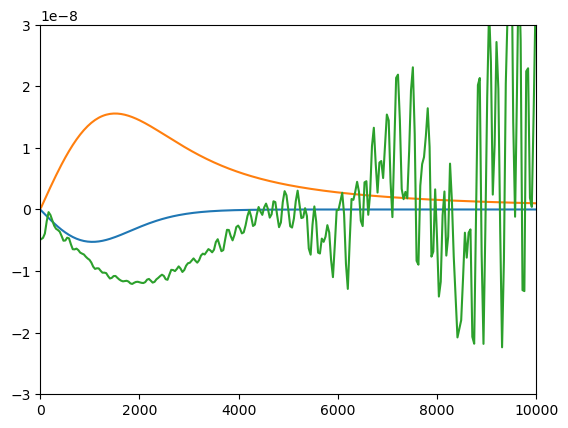

5101 425.985894304714 0.05682997279582828 1.000131789875317
5102 426.06940457609306 0.056851745469668216 1.0001317589387189
5103 426.1529148474722 0.056866280838658544 1.0001317327166666
5104 426.23642511885123 0.05688202804908608 1.0001316982963175
5105 426.31993539023034 0.056907675144274285 1.0001316678596783
5106 426.4034456616094 0.056926846504290037 1.000131638172247
5107 426.4869559329885 0.056939947071874095 1.0001316114573255
5108 426.57046620436756 0.05695467094347204 1.0001315830544237
5109 426.6539764757467 0.056977886159098455 1.000131552559224
5110 426.73748674712573 0.0570012544450531 1.0001315257646108
5111 426.82099701850484 0.05702223924763493 1.00013149596449
5112 426.9045072898839 0.05704314340447567 1.0001314702626967
5113 426.988017561263 0.05706361310302287 1.0001314404916015
5114 427.0715278326421 0.05708904617019616 1.0001314152793042
5115 427.1550381040212 0.057110049300803954 1.0001313834665877
5116 427.2385483754003 0.057125465576344986 1.000131361849856
511

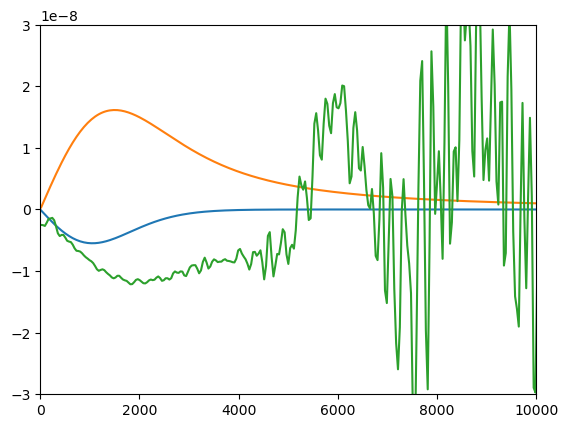

5201 434.3369214426225 0.05792577815672402 1.0001307222044569
5202 434.4204317140016 0.057938446583876 1.0001307136198503
5203 434.50394198538066 0.057949679446739205 1.0001306942425938
5204 434.5874522567598 0.057954619627486215 1.0001306815222484
5205 434.67096252813883 0.057968837789731185 1.000130659975732
5206 434.75447279951794 0.057981821942737516 1.000130646023442
5207 434.837983070897 0.057984624326675255 1.0001306221712807
5208 434.9214933422761 0.057992278793495305 1.0001306060440887
5209 435.0050036136552 0.05800626523417702 1.00013057944174
5210 435.0885138850343 0.058021724564860586 1.0001305603990676
5211 435.1720241564134 0.05803111542819027 1.0001305344801614
5212 435.25553442779244 0.05804512358116661 1.0001305183970677
5213 435.33904469917155 0.058067168472029224 1.0001304889112341
5214 435.4225549705506 0.058079652216833325 1.0001304678724943
5215 435.5060652419297 0.05809193944965729 1.000130437403767
5216 435.5895755133088 0.05810622354566868 1.0001304140759226
52

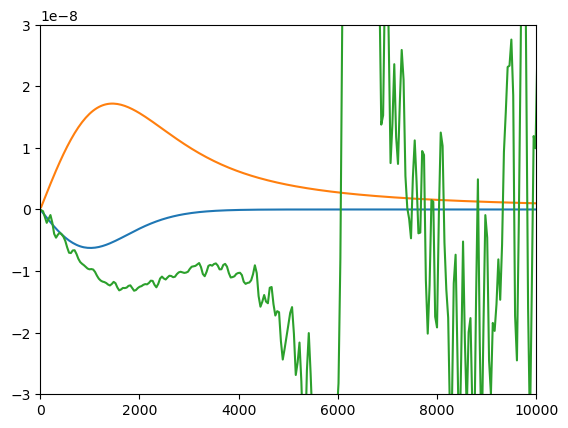

5301 442.68794858053104 0.06083726536873324 1.0001246968371862
5302 442.7714588519101 0.06087370100544214 1.0001246202191238
5303 442.8549691232892 0.06090299335722085 1.0001245382160586
5304 442.9384793946683 0.06093452738078622 1.0001244633295006
5305 443.0219896660474 0.06097360711680988 1.0001243819274737
5306 443.1054999374265 0.06100085373173097 1.0001243090764147
5307 443.18901020880554 0.06103754437809831 1.000124227515104
5308 443.27252048018465 0.061075197792953236 1.000124152116636
5309 443.3560307515637 0.0610938682354328 1.0001240755590322
5310 443.4395410229428 0.061129516747508286 1.00012400145056
5311 443.5230512943219 0.061171644218428196 1.0001239245139912
5312 443.606561565701 0.061204430169595356 1.0001238504915002
5313 443.69007183708004 0.06123539570095739 1.0001237765454607
5314 443.77358210845915 0.06126536072963309 1.000123703852571
5315 443.8570923798382 0.06128968110200264 1.0001236323699731
5316 443.9406026512173 0.06130945365131285 1.0001235604195815
5317 4

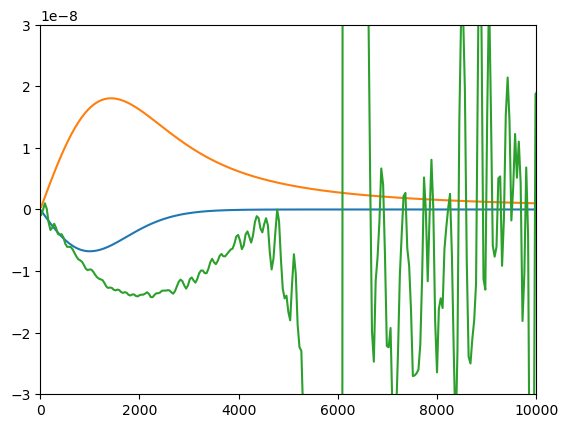

5401 451.0389757184396 0.06278117246817598 1.000118806863249
5402 451.12248598981864 0.06279415805707778 1.0001187605633703
5403 451.20599626119775 0.06280987231616053 1.0001187113542367
5404 451.2895065325768 0.06282604684963342 1.0001186628449288
5405 451.3730168039559 0.06283605247292866 1.000118617383914
5406 451.456527075335 0.06285188607745687 1.000118568720969
5407 451.5400373467141 0.06286929652584916 1.000118521481562
5408 451.62354761809314 0.06288096797027158 1.0001184732768802
5409 451.70705788947225 0.06288600383065736 1.0001184315145644
5410 451.7905681608513 0.06289296416972014 1.0001183824461963
5411 451.8740784322304 0.06290329498937475 1.0001183394520485
5412 451.95758870360953 0.0629146951049904 1.000118290616742
5413 452.0410989749886 0.06293320802690254 1.0001182492401324
5414 452.1246092463677 0.06294865365133025 1.000118201331526
5415 452.20811951774675 0.06296402492559611 1.000118160011442
5416 452.29162978912586 0.06297739670919501 1.000118112925962
5417 452.37

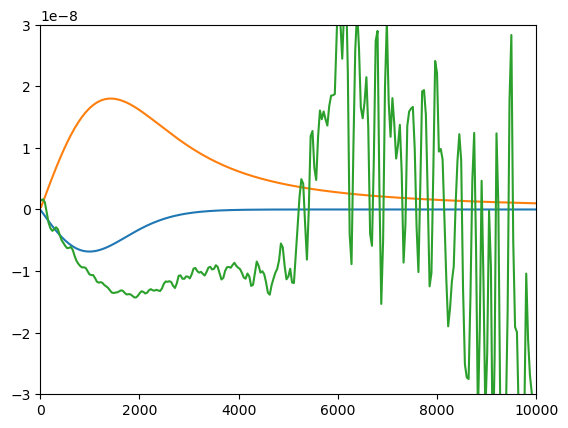

5501 459.3900028563481 0.06284113060033548 1.000118016476697
5502 459.4735131277272 0.06281281526375225 1.0001180679210404
5503 459.55702339910624 0.06278500603127282 1.0001181223531526
5504 459.64053367048535 0.06276270882580597 1.0001181732497018
5505 459.7240439418644 0.06273371993081442 1.0001182322532711
5506 459.8075542132435 0.0627117126814149 1.0001182835405145
5507 459.89106448462263 0.06268990506954945 1.0001183440829728
5508 459.9745747560017 0.06265284562975094 1.0001183998823662
5509 460.0580850273808 0.0626216570125904 1.0001184625029282
5510 460.14159529875985 0.06259032585853426 1.000118520549656
5511 460.22510557013896 0.06255387525297616 1.0001185873055327
5512 460.308615841518 0.06252540824118046 1.0001186446346133
5513 460.39212611289713 0.06250069502931982 1.0001187088411763
5514 460.4756363842762 0.062472121430219345 1.00011876968995
5515 460.5591466556553 0.06243701863692846 1.0001188347532401
5516 460.64265692703435 0.062402466080299174 1.000118894668353
5517 46

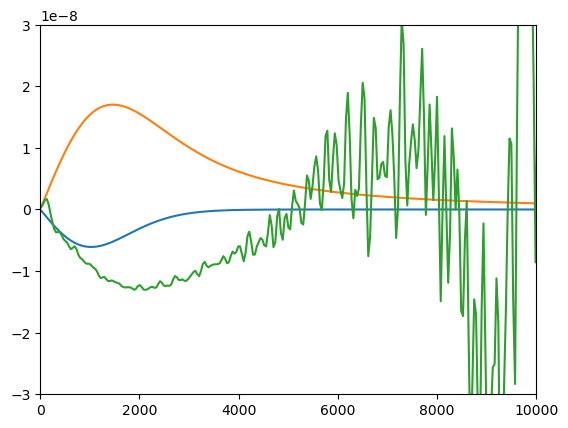

5601 467.7410299942566 0.06020047937297779 1.0001236091180854
5602 467.82454026563573 0.06018561468933254 1.0001236487856817
5603 467.9080505370148 0.060166321407960334 1.000123697399443
5604 467.9915608083939 0.060144779521454035 1.0001237373740715
5605 468.07507107977295 0.06012387041732222 1.0001237868009234
5606 468.15858135115207 0.06010203654583635 1.0001238280130313
5607 468.2420916225311 0.06009076808532715 1.0001238708850533
5608 468.32560189391023 0.0600731861862063 1.000123911214659
5609 468.4091121652893 0.060046990213156445 1.0001239588967759
5610 468.4926224366684 0.06003642889484016 1.0001239976259149
5611 468.57613270804745 0.060027500588734524 1.000124043277041
5612 468.65964297942656 0.06000736864252186 1.0001240862668308
5613 468.7431532508056 0.05998580734569937 1.0001241339760465
5614 468.82666352218473 0.05997042517165776 1.000124181337862
5615 468.9101737935638 0.059956517959545076 1.0001242220187634
5616 468.9936840649429 0.05993730378569055 1.0001242700712765
5

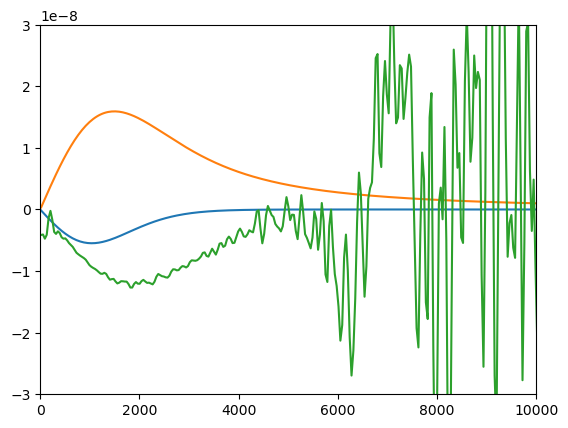

5701 476.09205713216517 0.057699550824435286 1.0001303007695186
5702 476.1755674035442 0.05765932469466625 1.00013039684561
5703 476.25907767492333 0.057618219324546624 1.0001304948872796
5704 476.3425879463024 0.05757402332691305 1.0001305932251856
5705 476.4260982176815 0.05753792648768197 1.0001306891286057
5706 476.50960848906055 0.057493830614086555 1.0001307903983572
5707 476.59311876043967 0.05744898388929874 1.0001308867154621
5708 476.6766290318187 0.0574086097318374 1.0001309849285016
5709 476.76013930319783 0.05736728855611476 1.000131079922644
5710 476.84364957457694 0.05733043685655745 1.0001311772391017
5711 476.927159845956 0.05728763005196955 1.0001312696269005
5712 477.0106701173351 0.05724780572833213 1.000131372982226
5713 477.09418038871416 0.057213293947379576 1.0001314663909875
5714 477.1776906600933 0.05717299078224529 1.0001315653064977
5715 477.26120093147233 0.057126620757566846 1.0001316571502077
5716 477.34471120285144 0.0570901340334664 1.0001317566643184
5

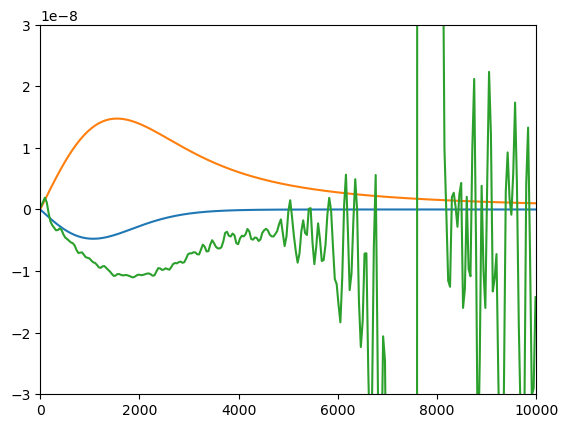

5801 484.44308427007365 0.05466883217037396 1.0001381761870713
5802 484.52659454145277 0.05464627336141476 1.0001382411983197
5803 484.6101048128318 0.054621340922579614 1.0001382991383938
5804 484.69361508421093 0.05459866396714513 1.0001383643031405
5805 484.77712535559004 0.05457514178690716 1.000138424624695
5806 484.8606356269691 0.054553006809162974 1.0001384893488288
5807 484.9441458983482 0.05452860315229505 1.0001385464588624
5808 485.02765616972727 0.05450144734325294 1.000138612008426
5809 485.1111664411064 0.054477192296498146 1.0001386723965071
5810 485.19467671248543 0.05445670958008467 1.000138736019223
5811 485.27818698386454 0.05442680406176582 1.0001387949060445
5812 485.3616972552436 0.054397300794292995 1.0001388589501896
5813 485.4452075266227 0.05437875633953153 1.0001389179519038
5814 485.52871779800176 0.05435632385545145 1.0001389817963133
5815 485.6122280693809 0.05432910412360432 1.0001390430702388
5816 485.69573834075993 0.05430692159764478 1.000139105739376

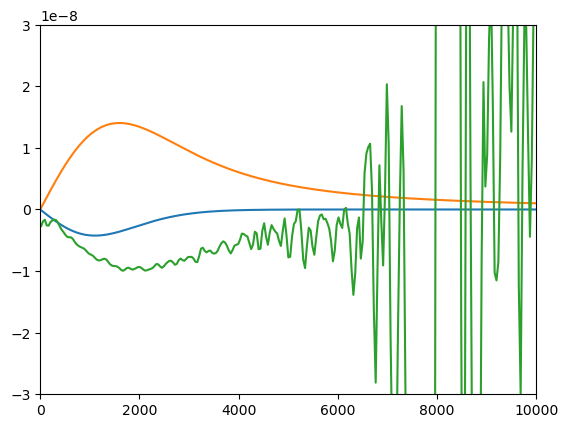

5901 492.7941114079822 0.052470453294068804 1.0001436776402584
5902 492.8776216793613 0.05245073276445931 1.0001437136055407
5903 492.96113195074037 0.052438053533705516 1.0001437430269633
5904 493.0446422221195 0.052418293136190196 1.0001437757062979
5905 493.12815249349853 0.05240151589767655 1.0001438042945598
5906 493.21166276487764 0.05239126627979434 1.0001438317489217
5907 493.2951730362567 0.05237122439823759 1.0001438601853592
5908 493.3786833076358 0.05235257065110963 1.0001438852362123
5909 493.46219357901487 0.05234307870642861 1.0001439100743363
5910 493.545703850394 0.05233072610985061 1.000143931674994
5911 493.62921412177303 0.05231464073598023 1.0001439566324921
5912 493.71272439315214 0.052299528693730925 1.000143974383955
5913 493.7962346645312 0.052283286662057823 1.0001439977219009
5914 493.8797449359103 0.052272518524457294 1.0001440124870313
5915 493.9632552072894 0.052264443978495445 1.0001440327275215
5916 494.0467654786685 0.05226064771595449 1.000144043512625

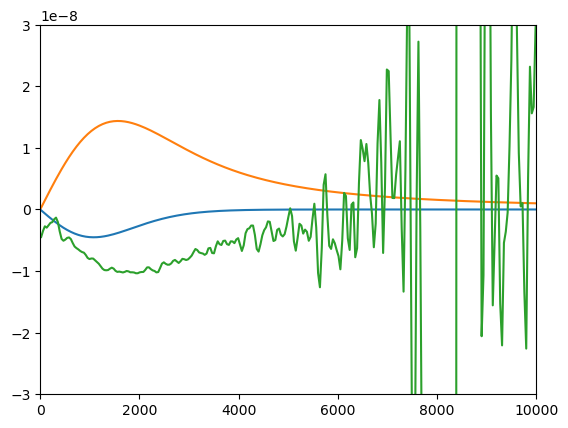

6001 501.14513854589075 0.053672245476610855 1.0001407369689381
6002 501.2286488172698 0.053703305258817224 1.0001406638564154
6003 501.3121590886489 0.05373758265508424 1.0001405964646413
6004 501.39566936002797 0.053769689381126015 1.0001405213848467
6005 501.4791796314071 0.05379536755203333 1.0001404557285853
6006 501.56268990278613 0.053821884653846915 1.0001403803181412
6007 501.64620017416524 0.053841434839366965 1.0001403149268262
6008 501.7297104455443 0.05386520410157388 1.0001402400360548
6009 501.8132207169234 0.05389937269033002 1.000140172954438
6010 501.8967309883025 0.053928579570050275 1.0001400979414434
6011 501.9802412596816 0.05396766524442223 1.0001400307136927
6012 502.0637515310607 0.0540024567856173 1.0001399530529977
6013 502.14726180243974 0.05402454947559042 1.000139888342423
6014 502.23077207381886 0.054060706887080805 1.0001398102995127
6015 502.3142823451979 0.05409230150133266 1.0001397402908974
6016 502.397792616577 0.05411562597929528 1.0001396662605004

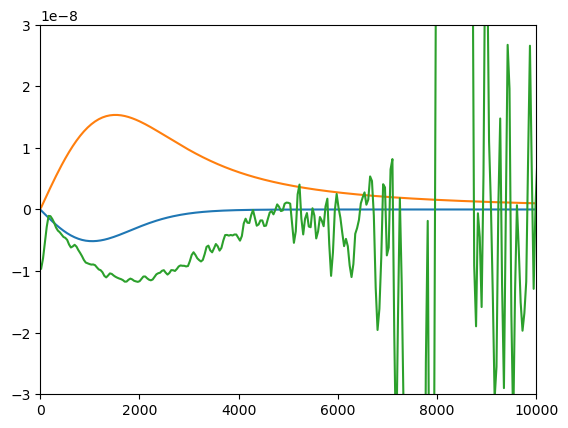

6101 509.49616568379923 0.0563345126111452 1.0001341933604757
6102 509.57967595517835 0.05635776248231725 1.000134132551474
6103 509.6631862265574 0.056376766425707936 1.0001340817591011
6104 509.7466964979365 0.05639328729774251 1.0001340233441203
6105 509.8302067693156 0.056415442694885604 1.0001339701027148
6106 509.9137170406947 0.056434442563533686 1.0001339118696524
6107 509.9972273120738 0.05645708018981315 1.0001338594896032
6108 510.08073758345284 0.05647929813010273 1.0001338034905423
6109 510.16424785483196 0.05649624224448676 1.0001337479241
6110 510.247758126211 0.056516741166388156 1.000133692085659
6111 510.3312683975901 0.056536359563655755 1.0001336360181825
6112 510.4147786689692 0.056553421911470884 1.0001335816380283
6113 510.4982889403483 0.056568692559563594 1.000133523369088
6114 510.58179921172734 0.05658379934587834 1.0001334720350266
6115 510.66530948310645 0.05660112312948389 1.0001334133074773
6116 510.7488197544855 0.05661533148955179 1.0001333603879166
611

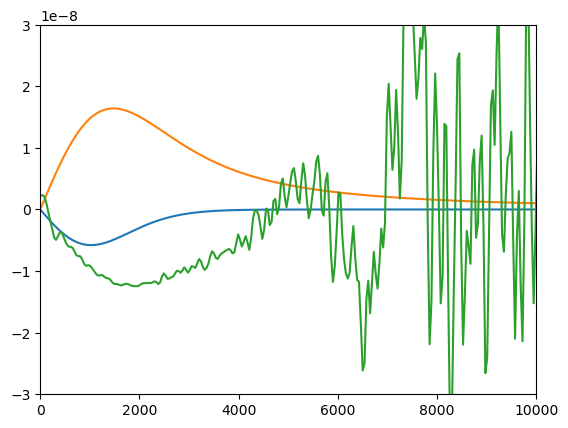

6201 517.8471928217078 0.05900528301574322 1.0001271028084144
6202 517.9307030930869 0.05903702359168605 1.0001270295257827
6203 518.014213364466 0.05905671305181028 1.0001269556676045
6204 518.097723635845 0.05909187132943926 1.0001268817560045
6205 518.1812339072242 0.05912499612150497 1.0001268086383683
6206 518.2647441786032 0.059150367165115146 1.0001267401197136
6207 518.3482544499823 0.05918118814976904 1.0001266695933508
6208 518.4317647213613 0.05921145037094791 1.0001266041779737
6209 518.5152749927405 0.059244663286885046 1.0001265320444688
6210 518.5987852641196 0.05927126047239181 1.000126468427618
6211 518.6822955354986 0.05928937767772792 1.0001263994277285
6212 518.7658058068778 0.059315945847845275 1.0001263389093302
6213 518.8493160782568 0.0593440283866578 1.0001262687899082
6214 518.9328263496359 0.05936922595023566 1.000126210517956
6215 519.016336621015 0.05939609209309301 1.000126140238591
6216 519.0998468923941 0.059419620275825924 1.0001260848487772
6217 519.18

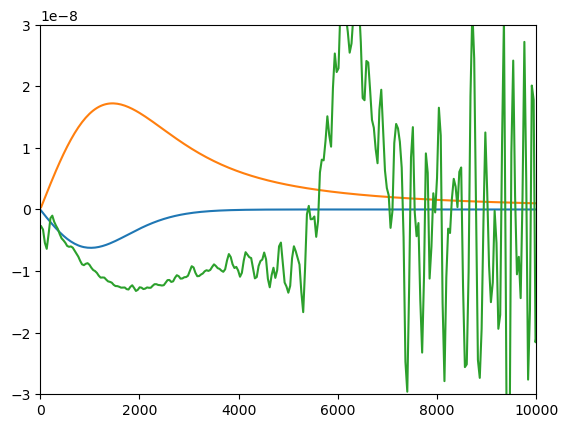

6301 526.1982199596163 0.060768901663017405 1.0001230650827577
6302 526.2817302309954 0.06078062570287883 1.0001230518187323
6303 526.3652405023745 0.060798831860862775 1.0001230295073298
6304 526.4487507737535 0.06081204348803284 1.0001230172144542
6305 526.5322610451326 0.060827046418264426 1.000122993103096
6306 526.6157713165118 0.06084346405748682 1.0001229806519216
6307 526.6992815878908 0.06085636195092086 1.000122958407997
6308 526.7827918592699 0.060862669409790855 1.0001229501136315
6309 526.866302130649 0.06086773743991524 1.0001229285938178
6310 526.9498124020281 0.060878323720230845 1.0001229152124391
6311 527.0333226734072 0.06088352180563439 1.0001228952851189
6312 527.1168329447862 0.06088927728886045 1.0001228863925766
6313 527.2003432161654 0.060899621195783266 1.0001228640278215
6314 527.2838534875444 0.060911260866095676 1.0001228477389157
6315 527.3673637589235 0.06092777485458761 1.0001228265716047
6316 527.4508740303025 0.06094227903291014 1.000122810311194
6317 

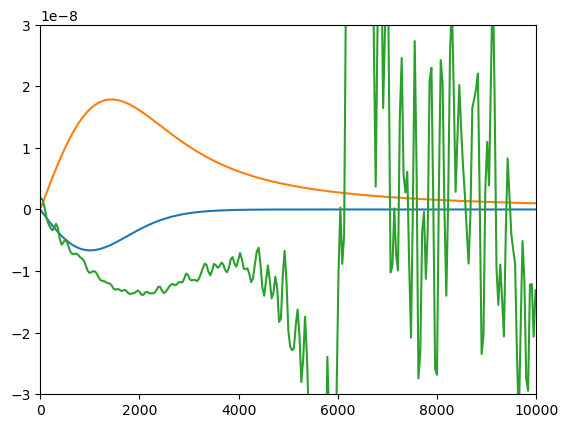

6401 534.5492470975248 0.0623165416519338 1.0001196375500254
6402 534.632757368904 0.06233982061611094 1.0001195858483045
6403 534.716267640283 0.0623627531677556 1.0001195228971789
6404 534.7997779116621 0.06238363853778491 1.0001194697783864
6405 534.8832881830411 0.062401547556816324 1.0001194132225972
6406 534.9667984544203 0.0624285680609174 1.0001193547050562
6407 535.0503087257994 0.06245466471315275 1.0001192957145337
6408 535.1338189971784 0.0624798898062535 1.0001192370783893
6409 535.2173292685575 0.06250516903416907 1.0001191799618592
6410 535.3008395399366 0.06251936748907379 1.0001191194643393
6411 535.3843498113157 0.06254426418996303 1.0001190685496526
6412 535.4678600826948 0.06257308772728502 1.0001190079842
6413 535.5513703540738 0.06259569843384252 1.0001189593415603
6414 535.634880625453 0.06262024025157524 1.0001188976707802
6415 535.718390896832 0.06263620459045269 1.000118854856314
6416 535.8019011682111 0.06266288673217854 1.000118792916998
6417 535.88541143959

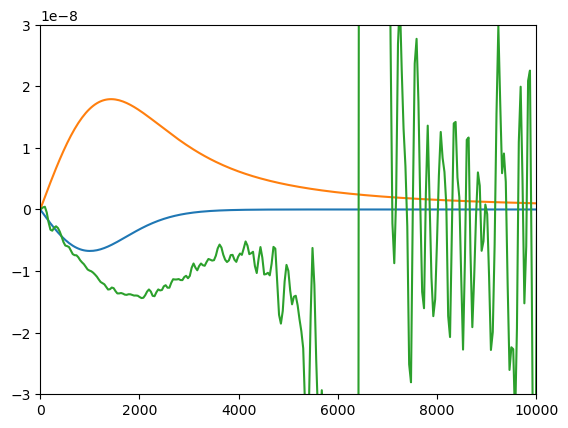

6501 542.9002742354334 0.06251360055206164 1.0001190200542986
6502 542.9837845068124 0.06248752191467092 1.0001190752965812
6503 543.0672947781916 0.06246767159758059 1.0001191353817451
6504 543.1508050495706 0.062445245173734606 1.0001191839531918
6505 543.2343153209497 0.06241823227046904 1.0001192455799943
6506 543.3178255923287 0.06240075150493751 1.0001192987407488
6507 543.4013358637079 0.06237584726004879 1.0001193639416501
6508 543.484846135087 0.06234127172267932 1.0001194190806797
6509 543.568356406466 0.062312819457156714 1.0001194856722597
6510 543.6518666778451 0.062287644611424504 1.0001195412075699
6511 543.7353769492242 0.062265373760444415 1.0001196106206616
6512 543.8188872206033 0.0622442031278389 1.0001196657407572
6513 543.9023974919824 0.06222146658695114 1.0001197320318733
6514 543.9859077633615 0.062197566626362014 1.0001197903599395
6515 544.0694180347406 0.06217037439878122 1.0001198586571445
6516 544.1529283061196 0.06214737418397234 1.0001199190248553
6517 5

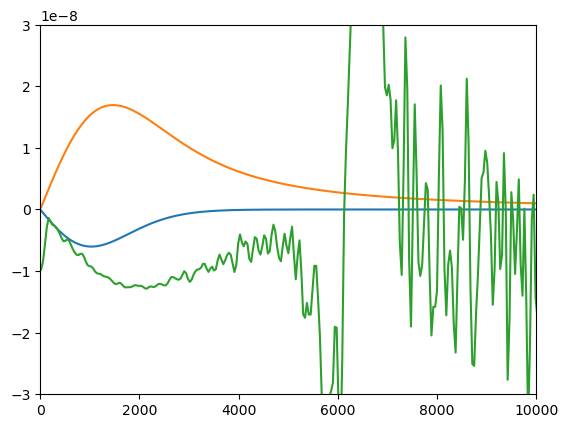

6601 551.2513013733419 0.05997479765095568 1.0001261635682939
6602 551.334811644721 0.05995162120881662 1.0001262248611853
6603 551.4183219161 0.05992578328404521 1.0001262990247406
6604 551.5018321874792 0.059901082377850856 1.0001263610185749
6605 551.5853424588582 0.05987827513814877 1.0001264316685898
6606 551.6688527302373 0.05985276320932527 1.0001264938441226
6607 551.7523630016165 0.0598305738985973 1.000126561711596
6608 551.8358732729955 0.05980688232806204 1.000126623331616
6609 551.9193835443746 0.0597902932560602 1.000126690042338
6610 552.0028938157536 0.05977064528590089 1.0001267524791173
6611 552.0864040871328 0.05974887913562822 1.0001268169743234
6612 552.1699143585118 0.05973068783643571 1.0001268790161042
6613 552.2534246298909 0.059701986570366176 1.0001269433219435
6614 552.33693490127 0.059673356910052176 1.0001270064826093
6615 552.4204451726491 0.05964730032130878 1.0001270674488483
6616 552.5039554440282 0.059631895643661864 1.0001271301167085
6617 552.587465

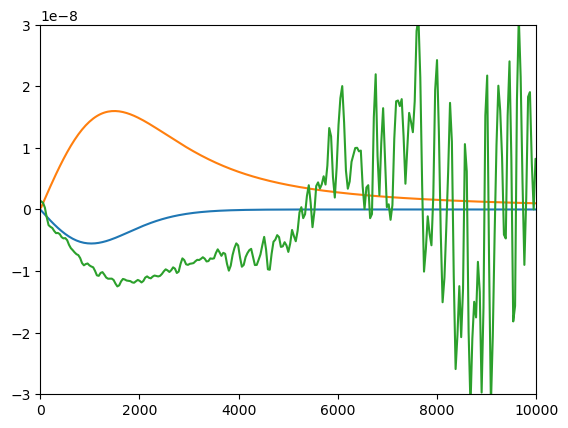

6701 559.6023285112504 0.05790619473898355 1.000131742102369
6702 559.6858387826295 0.05786926963259322 1.00013180545703
6703 559.7693490540086 0.05783365240402136 1.000131872230298
6704 559.8528593253877 0.05780138781476688 1.0001319374915671
6705 559.9363695967668 0.05777358473136589 1.0001320025769458
6706 560.0198798681458 0.05774703212198532 1.0001320693855948
6707 560.1033901395249 0.057713387947704496 1.0001321338157232
6708 560.1869004109041 0.05767827572746434 1.0001322036611844
6709 560.2704106822831 0.05764101709472909 1.0001322673608557
6710 560.3539209536622 0.057607917153518706 1.0001323395337642
6711 560.4374312250412 0.05757103519620767 1.000132401284789
6712 560.5209414964204 0.0575212530479544 1.000132477049922
6713 560.6044517677994 0.05748334876148664 1.0001325390805804
6714 560.6879620391785 0.057458695144846486 1.000132612299792
6715 560.7714723105577 0.057421052574477036 1.0001326741448036
6716 560.8549825819367 0.057381327064422845 1.0001327498648132
6717 560.93

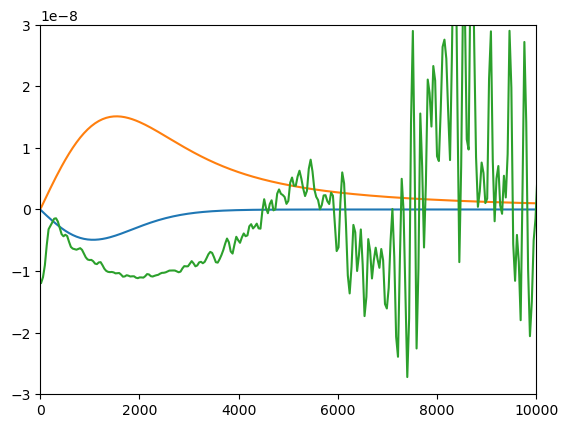

6801 567.953355649159 0.05547354420749872 1.0001366138754182
6802 568.036865920538 0.055473308484941024 1.000136633150619
6803 568.1203761919171 0.05547606078436174 1.0001366404062808
6804 568.2038864632962 0.05546726561098496 1.0001366591588248
6805 568.2873967346753 0.05546159151619826 1.0001366664333788
6806 568.3709070060544 0.055459089786673244 1.0001366839730006
6807 568.4544172774334 0.05544910188985273 1.000136691545551
6808 568.5379275488125 0.055444952587833836 1.0001367085754571
6809 568.6214378201917 0.055450136949216716 1.000136713484544
6810 568.7049480915707 0.05543872427232604 1.0001367299441444
6811 568.7884583629498 0.05543285116923386 1.0001367365082985
6812 568.8719686343289 0.055430581869901054 1.0001367494051334
6813 568.955478905708 0.05542453775464094 1.000136757518729
6814 569.038989177087 0.055422843922942305 1.0001367674360362
6815 569.1224994484661 0.055416165943409555 1.0001367763780185
6816 569.2060097198453 0.055416370226324195 1.000136783568172
6817 569.

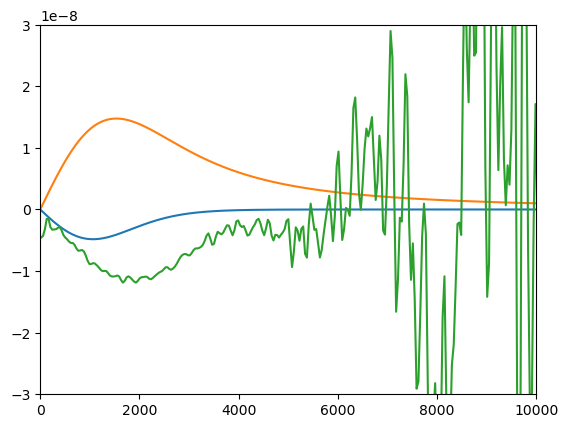

6901 576.3043827870674 0.054880930649891115 1.0001373706112113
6902 576.3878930584466 0.054869788123629984 1.0001373870800836
6903 576.4714033298256 0.05486032097815533 1.0001373993345888
6904 576.5549136012047 0.054852286595194366 1.0001374152517541
6905 576.6384238725839 0.054843329419895566 1.0001374302270305
6906 576.7219341439629 0.05483148505293511 1.0001374469637219
6907 576.805444415342 0.05481977513606347 1.0001374631851319
6908 576.888954686721 0.054816250033622484 1.0001374794001896
6909 576.9724649581002 0.054818976157538495 1.0001374958640012
6910 577.0559752294793 0.05481525812513273 1.0001375091980673
6911 577.1394855008583 0.054808931574828204 1.0001375260926497
6912 577.2229957722374 0.054801979786071243 1.0001375414086668
6913 577.3065060436165 0.054791695159240775 1.0001375622866957
6914 577.3900163149956 0.05478594459702324 1.000137578579621
6915 577.4735265863746 0.05478098950239911 1.0001375983242902
6916 577.5570368577537 0.05477022439327987 1.0001376139041156
69

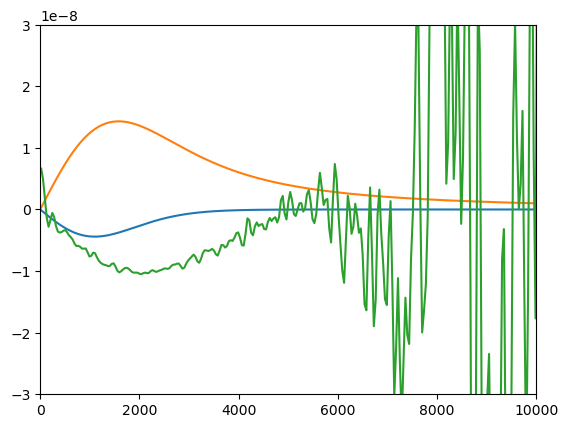

7001 584.655409924976 0.053207297859563865 1.000140369974426
7002 584.7389201963551 0.053198005534943936 1.0001403980155426
7003 584.8224304677342 0.05318611248089918 1.0001404226831727
7004 584.9059407391132 0.053163371724091496 1.0001404459540955
7005 584.9894510104923 0.05315043805573446 1.000140468412119
7006 585.0729612818715 0.053146349795750794 1.0001404893824835
7007 585.1564715532505 0.0531314930765241 1.0001405156043863
7008 585.2399818246296 0.05311810930761196 1.0001405315094904
7009 585.3234920960086 0.05310599019634049 1.000140552396655
7010 585.4070023673878 0.05309520624022735 1.000140568938993
7011 585.4905126387669 0.053083158988317086 1.0001405871387454
7012 585.5740229101459 0.05307172030180254 1.0001406020839876
7013 585.6575331815251 0.05306670086562649 1.0001406207740446
7014 585.7410434529041 0.053065642114790174 1.0001406327089266
7015 585.8245537242832 0.05306732406258039 1.0001406456013056
7016 585.9080639956622 0.053053026295640286 1.0001406592775812
7017 58

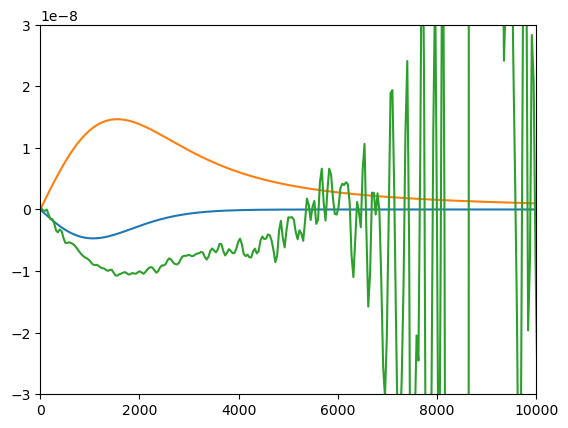

7101 593.0064370628845 0.054477791453892 1.000138777127536
7102 593.0899473342636 0.05450654596826938 1.0001387305838427
7103 593.1734576056427 0.05453459498866784 1.0001386875273015
7104 593.2569678770218 0.05455181313998044 1.0001386398380836
7105 593.3404781484008 0.05457078838142805 1.0001385974307613
7106 593.4239884197799 0.05459868267598542 1.0001385487135501
7107 593.5074986911591 0.05462599930441075 1.0001385057801524
7108 593.5910089625381 0.05465674435526852 1.000138454888709
7109 593.6745192339172 0.054683189083996483 1.0001384129945798
7110 593.7580295052963 0.05470816286953501 1.000138364374682
7111 593.8415397766754 0.0547263331192107 1.000138320806085
7112 593.9250500480545 0.054743041921354596 1.0001382759050175
7113 594.0085603194335 0.054772252136305544 1.000138230825679
7114 594.0920705908127 0.05479640125212179 1.00013818365612
7115 594.1755808621917 0.05481757082923371 1.0001381373329297
7116 594.2590911335708 0.05483587486363062 1.0001380913670235
7117 594.342601

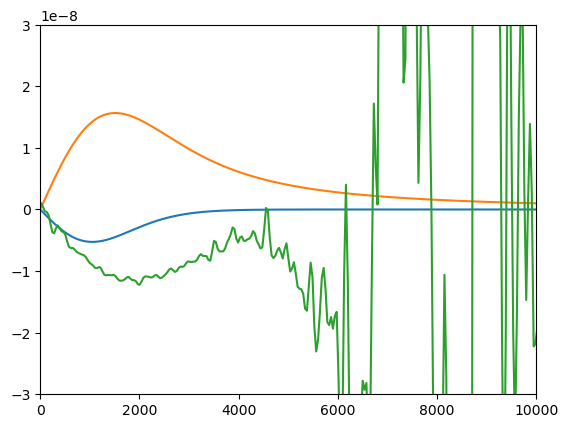

7201 601.3574642007931 0.05695303593184487 1.0001327544670142
7202 601.4409744721721 0.0569821906500108 1.0001326700473923
7203 601.5244847435513 0.057008895725094606 1.000132592347872
7204 601.6079950149303 0.05705056443008851 1.0001325143508428
7205 601.6915052863094 0.057087819924165804 1.0001324340135658
7206 601.7750155576884 0.0571169189901578 1.000132356245073
7207 601.8585258290676 0.05715065376881108 1.0001322766141614
7208 601.9420361004467 0.05718508756306727 1.0001321947814723
7209 602.0255463718257 0.057219814553086536 1.000132110160548
7210 602.1090566432048 0.05725127899352281 1.0001320297557499
7211 602.192566914584 0.057280203902218774 1.0001319484762408
7212 602.276077185963 0.05731048909128321 1.0001318684650695
7213 602.3595874573421 0.05734541850302295 1.000131784178354
7214 602.4430977287211 0.05737849796610567 1.0001317033433177
7215 602.5266080001003 0.057411184497876064 1.0001316191111682
7216 602.6101182714793 0.05744420556903379 1.0001315395522357
7217 602.69

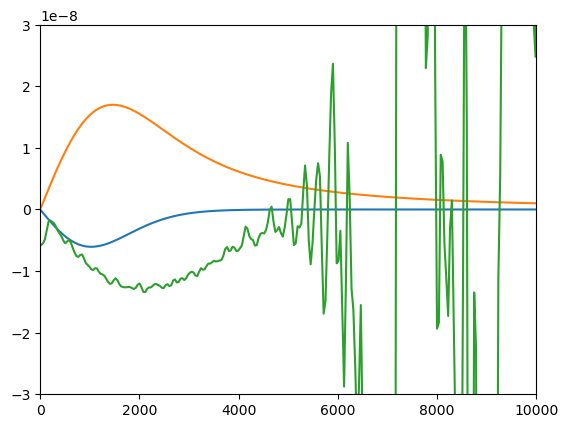

7301 609.7084913387016 0.060172846695390934 1.0001239980058079
7302 609.7920016100807 0.060205969649294 1.0001239013534697
7303 609.8755118814597 0.06024276856806621 1.0001237962152767
7304 609.9590221528389 0.06028035430316578 1.0001236916743286
7305 610.0425324242179 0.0603189838767967 1.0001235866251008
7306 610.126042695597 0.06035687987591196 1.0001234838354596
7307 610.209552966976 0.06038845908833584 1.0001233776873397
7308 610.2930632383552 0.06042676298214308 1.000123273035378
7309 610.3765735097343 0.0604675072795987 1.0001231603027063
7310 610.4600837811133 0.06049714530511075 1.0001230584458423
7311 610.5435940524925 0.06053434986864278 1.0001229515346206
7312 610.6271043238715 0.06058075409178802 1.0001228462507357
7313 610.7106145952506 0.06061684701095194 1.0001227405067068
7314 610.7941248666297 0.060651105582118704 1.0001226393177702
7315 610.8776351380088 0.06069439950829928 1.000122533736767
7316 610.9611454093879 0.060738903332774506 1.0001224301258105
7317 611.0446

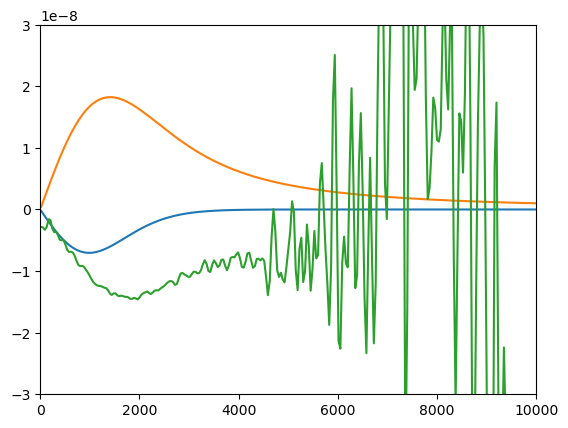

7401 618.0595184766102 0.06354523093677768 1.0001159891806923
7402 618.1430287479892 0.06354748071454219 1.0001159814983906
7403 618.2265390193683 0.06355486564703111 1.0001159677992537
7404 618.3100492907473 0.06356127092802366 1.0001159613503892
7405 618.3935595621265 0.06356027945734578 1.0001159526581207
7406 618.4770698335055 0.063561040785895 1.000115948421945
7407 618.5605801048846 0.0635648111359171 1.000115944120629
7408 618.6440903762638 0.06356450404066243 1.0001159473333916
7409 618.7276006476428 0.06356995084024017 1.0001159434978986
7410 618.8111109190219 0.06357616750188173 1.0001159468383662
7411 618.8946211904009 0.06357709304889958 1.0001159500435457
7412 618.9781314617801 0.06357809042476671 1.0001159579791075
7413 619.0616417331591 0.06358386812336317 1.000115962930059
7414 619.1451520045382 0.0635830165897653 1.0001159698853956
7415 619.2286622759173 0.06357387561950119 1.000115982242623
7416 619.3121725472964 0.06357136669404616 1.0001159906030967
7417 619.3956828

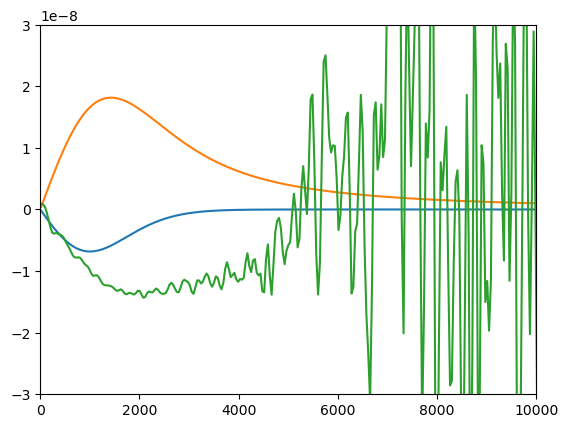

7501 626.4105456145187 0.0629462674106631 1.0001183269524259
7502 626.4940558858978 0.06293293683578266 1.000118358318614
7503 626.5775661572768 0.06292543359918203 1.0001183874537716
7504 626.6610764286559 0.06291896662461754 1.000118416432813
7505 626.744586700035 0.06291196429446663 1.000118446772128
7506 626.8280969714141 0.06290565492427927 1.000118474764513
7507 626.9116072427931 0.06288811884117311 1.0001185089216826
7508 626.9951175141722 0.0628776303020886 1.0001185369992398
7509 627.0786277855514 0.06286947477328371 1.0001185691028667
7510 627.1621380569304 0.0628563738988081 1.0001185997407454
7511 627.2456483283095 0.0628568413058204 1.0001186319136877
7512 627.3291585996885 0.06285335030949833 1.0001186598022591
7513 627.4126688710677 0.06284201343238967 1.0001186947931406
7514 627.4961791424467 0.06283175920810921 1.000118722598202
7515 627.5796894138258 0.06282466945672169 1.0001187579099073
7516 627.663199685205 0.06282125849045057 1.0001187837307455
7517 627.7467099565

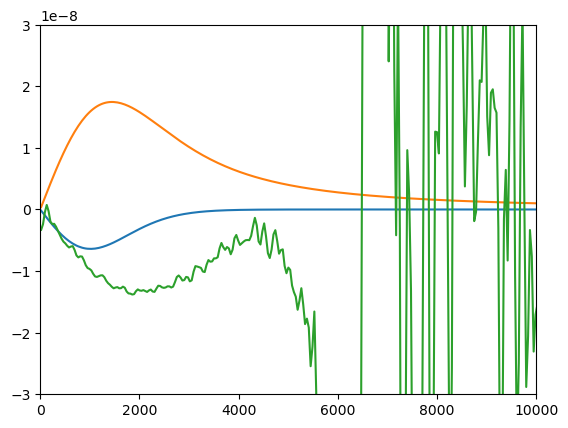

7601 634.7615727524271 0.06131719633925092 1.0001227340973557
7602 634.8450830238063 0.06130072940776124 1.0001227890209863
7603 634.9285932951854 0.06127594762734952 1.0001228516735237
7604 635.0121035665644 0.06124439409335518 1.0001229082185599
7605 635.0956138379435 0.06121435459765235 1.0001229717669302
7606 635.1791241093226 0.061188874974688355 1.00012302810336
7607 635.2626343807017 0.06116694145166433 1.0001230906916967
7608 635.3461446520807 0.061146731306178266 1.000123147658841
7609 635.4296549234599 0.061131144149482584 1.0001232085217309
7610 635.513165194839 0.06110154823946961 1.0001232658517254
7611 635.596675466218 0.06106045190809265 1.0001233307832658
7612 635.6801857375971 0.06104001897765394 1.0001233882018774
7613 635.7636960089762 0.06102768056260908 1.0001234470564604
7614 635.8472062803553 0.06099576610383053 1.0001235079473503
7615 635.9307165517343 0.06096232747549169 1.000123569164189
7616 636.0142268231134 0.06093265596901211 1.0001236300842111
7617 636.09

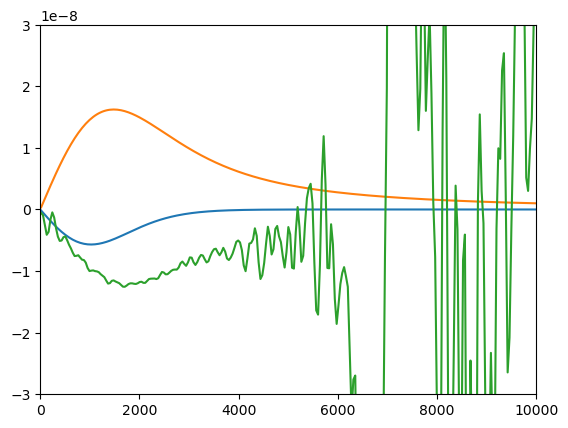

7701 643.1125998903357 0.05851311912646442 1.0001298391802276
7702 643.1961101617147 0.05846679250089905 1.0001299383559512
7703 643.2796204330939 0.058426910691377565 1.0001300432561586
7704 643.363130704473 0.058373099609423336 1.000130144640861
7705 643.446640975852 0.05832645597682351 1.000130252612618
7706 643.5301512472312 0.05828597130878846 1.0001303530586605
7707 643.6136615186102 0.058235562886040884 1.0001304608130515
7708 643.6971717899893 0.05819598613373613 1.0001305646838967
7709 643.7806820613683 0.05815155513653603 1.000130672222203
7710 643.8641923327475 0.05809631885160404 1.0001307802308015
7711 643.9477026041266 0.05804452450833031 1.0001308850263109
7712 644.0312128755056 0.05799696731358927 1.0001309949350077
7713 644.1147231468847 0.05794516025405116 1.000131099276791
7714 644.1982334182638 0.05789372260711764 1.0001312097222963
7715 644.2817436896429 0.05785308275982066 1.0001313140701749
7716 644.365253961022 0.05780658605098392 1.0001314258554548
7717 644.448

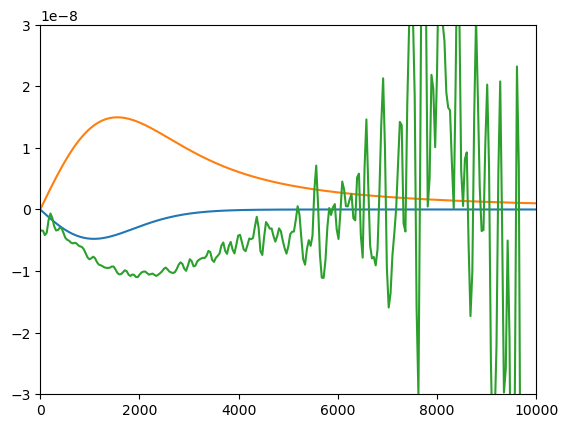

7801 651.4636270282442 0.054871151380019974 1.0001384131729276
7802 651.5471372996233 0.05485907871837664 1.0001384545324505
7803 651.6306475710024 0.05484466332030348 1.0001384902791017
7804 651.7141578423815 0.05483505458896306 1.0001385313641697
7805 651.7976681137606 0.05481821357368535 1.0001385646871026
7806 651.8811783851396 0.05479351254345815 1.0001386070677811
7807 651.9646886565188 0.054783830938436896 1.0001386369903724
7808 652.0481989278978 0.05477690143373454 1.0001386757682567
7809 652.1317091992769 0.05476296178914416 1.0001387047112706
7810 652.2152194706559 0.05475545787574573 1.00013874163956
7811 652.2987297420351 0.054752062668798264 1.000138767032389
7812 652.3822400134142 0.054749302295944 1.0001388019165893
7813 652.4657502847932 0.05473696594653758 1.0001388270934648
7814 652.5492605561724 0.05472381573516238 1.0001388609381374
7815 652.6327708275514 0.054713264976547576 1.0001388842754384
7816 652.7162810989305 0.05469147126390627 1.000138917155745
7817 652.7

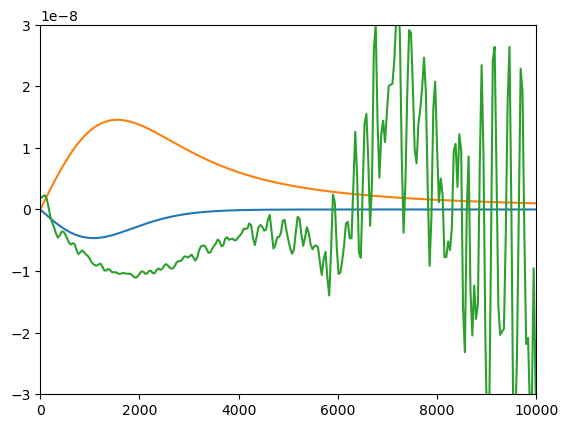

7901 659.8146541661528 0.05419426380482974 1.0001398558555807
7902 659.8981644375318 0.05418612611948976 1.0001398651273627
7903 659.9816747089109 0.05417087616590915 1.0001398682844147
7904 660.06518498029 0.054157502818761534 1.0001398777062058
7905 660.1486952516691 0.05414810650898271 1.0001398797059238
7906 660.2322055230482 0.05413550798025613 1.0001398886928978
7907 660.3157157944272 0.05412039783392634 1.0001398922749882
7908 660.3992260658064 0.054109163914633836 1.0001398995223711
7909 660.4827363371854 0.05409854159085122 1.0001399025300306
7910 660.5662466085645 0.05408524986027387 1.0001399089744378
7911 660.6497568799437 0.054077486300534834 1.000139910489312
7912 660.7332671513227 0.05407127155744221 1.0001399151957937
7913 660.8167774227018 0.05406496179249719 1.0001399183481228
7914 660.9002876940808 0.054057315497338984 1.0001399204224437
7915 660.98379796546 0.05404665830907936 1.0001399225538221
7916 661.067308236839 0.05402974586685934 1.0001399233024386
7917 661.1

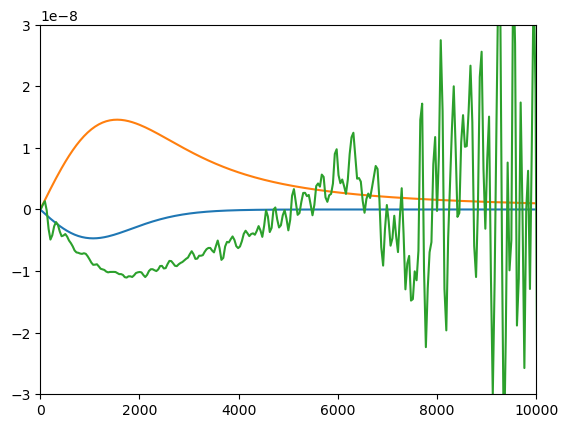

8001 668.1656813040613 0.054358516591303314 1.0001383517859237
8002 668.2491915754404 0.054352426445272314 1.0001383296901725
8003 668.3327018468194 0.05435870347097191 1.0001383055650572
8004 668.4162121181986 0.0543793046194238 1.0001382790033617
8005 668.4997223895776 0.05438668871358038 1.0001382577274016
8006 668.5832326609567 0.054392015560769454 1.0001382338452078
8007 668.6667429323358 0.05439856385462087 1.0001382119190059
8008 668.7502532037149 0.054398236713785075 1.0001381900215687
8009 668.833763475094 0.05441022385539713 1.0001381698525151
8010 668.917273746473 0.0544217272470633 1.0001381455448763
8011 669.0007840178521 0.054428397136100946 1.0001381204368782
8012 669.0842942892313 0.05443731359412067 1.000138098056605
8013 669.1678045606103 0.0544368477258733 1.0001380826730832
8014 669.2513148319894 0.05443111101839632 1.0001380595289349
8015 669.3348251033684 0.05443863567707243 1.000138041256066
8016 669.4183353747476 0.054449993553694606 1.0001380164937996
8017 669.

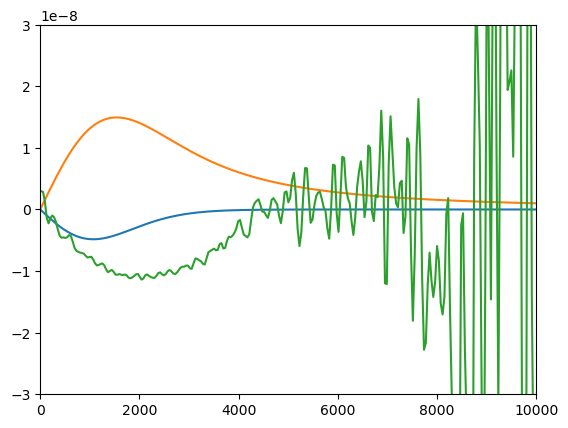

8101 676.5167084419699 0.05509787354908971 1.000136210666733
8102 676.6002187133489 0.05511567929563634 1.0001361769806023
8103 676.683728984728 0.05513422055777682 1.0001361464098792
8104 676.767239256107 0.05515260320613971 1.0001361146818168
8105 676.8507495274862 0.055171234283420335 1.0001360846240415
8106 676.9342597988652 0.05519842311047175 1.0001360499929088
8107 677.0177700702443 0.05521724801548439 1.0001360217581117
8108 677.1012803416234 0.055233875080819325 1.0001359905297875
8109 677.1847906130025 0.05525441195524957 1.0001359578043574
8110 677.2683008843816 0.05527605132304942 1.00013592203224
8111 677.3518111557606 0.05530217300334669 1.0001358894873933
8112 677.4353214271398 0.055319891076290255 1.0001358542805345
8113 677.5188316985189 0.05533339784707658 1.0001358238355293
8114 677.6023419698979 0.05535378440730413 1.0001357887879303
8115 677.685852241277 0.05537043492507637 1.0001357573548173
8116 677.7693625126561 0.05539175031025404 1.0001357211220085
8117 677.85

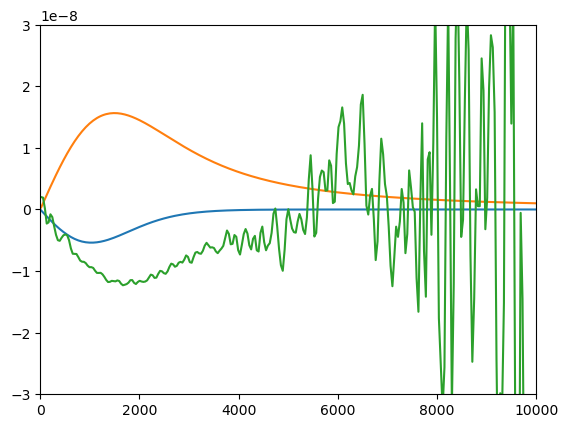

8201 684.8677355798783 0.05728036143313448 1.0001326237758539
8202 684.9512458512575 0.05729109098227137 1.0001326046915073
8203 685.0347561226365 0.05729684612492685 1.0001325924570694
8204 685.1182663940156 0.05730401886974821 1.0001325744881393
8205 685.2017766653946 0.05732640743745849 1.000132563138847
8206 685.2852869367738 0.057340318029787465 1.000132543820029
8207 685.3687972081528 0.05734324595618202 1.0001325358371609
8208 685.4523074795319 0.057353627978807886 1.0001325208753655
8209 685.5358177509111 0.057348498139715647 1.0001325158244392
8210 685.6193280222901 0.05734557261541548 1.0001325047034488
8211 685.7028382936692 0.05736157048828876 1.0001324964948943
8212 685.7863485650482 0.057370148052055446 1.000132485712025
8213 685.8698588364274 0.057368573486866525 1.0001324822099393
8214 685.9533691078065 0.0573723320996242 1.0001324734272965
8215 686.0368793791855 0.05738112331456677 1.0001324666370555
8216 686.1203896505646 0.057395348281169455 1.0001324589726481
8217 6

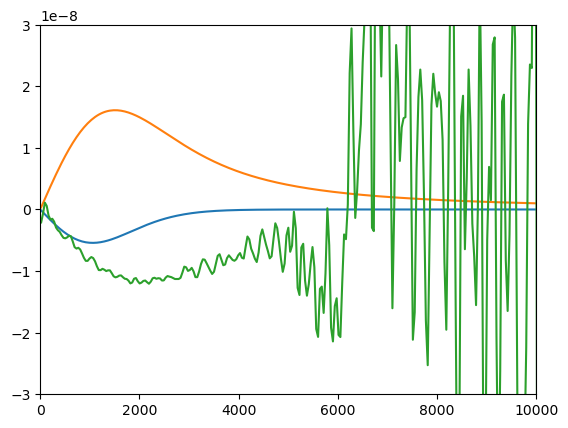

8301 693.2187627177868 0.057715910621020154 1.0001317411281898
8302 693.302272989166 0.057738577122461825 1.0001316926125148
8303 693.385783260545 0.057759420808276674 1.000131646068685
8304 693.4692935319241 0.05778230421431723 1.0001315948594418
8305 693.5528038033032 0.05780470822838603 1.00013154739614
8306 693.6363140746823 0.05783403318043192 1.000131494952532
8307 693.7198243460614 0.05786433783468535 1.0001314416234097
8308 693.8033346174404 0.05789064044959215 1.0001313882673855
8309 693.8868448888195 0.057919503449329876 1.0001313333049775
8310 693.9703551601987 0.05794738006203012 1.000131278897061
8311 694.0538654315777 0.057976944167961335 1.00013122399056
8312 694.1373757029568 0.05800810989839282 1.0001311664237424
8313 694.2208859743358 0.05803680953015479 1.0001311066411298
8314 694.304396245715 0.058067702618835294 1.0001310478446905
8315 694.387906517094 0.05808717821861816 1.0001309868615371
8316 694.4714167884731 0.058112243084427015 1.0001309290643439
8317 694.554

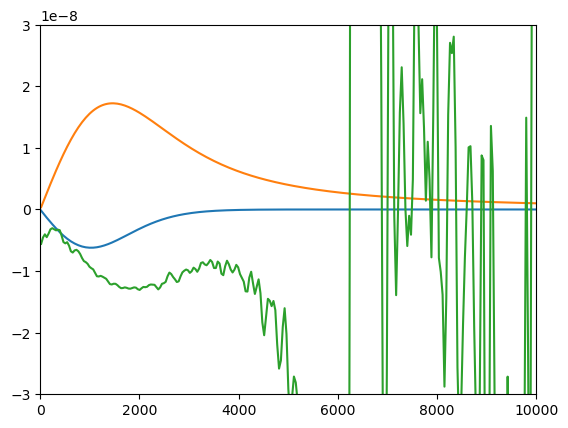

8401 701.5697898556954 0.0607564478640546 1.0001234667253058
8402 701.6533001270744 0.06078413904138845 1.000123362696635
8403 701.7368103984536 0.06081551599875632 1.0001232560256472
8404 701.8203206698327 0.06085265006484924 1.0001231478372552
8405 701.9038309412117 0.060888001349559163 1.0001230347852146
8406 701.9873412125908 0.06091225080843773 1.0001229249580275
8407 702.0708514839699 0.06093846290834422 1.0001228196313592
8408 702.154361755349 0.06098025824994209 1.00012270892897
8409 702.237872026728 0.06101240788819353 1.000122601024525
8410 702.3213822981072 0.061042328942247405 1.0001224987285628
8411 702.4048925694863 0.06108284567464767 1.0001223854669388
8412 702.4884028408653 0.061116785860854936 1.0001222774919434
8413 702.5719131122444 0.06115173101651927 1.0001221674119243
8414 702.6554233836235 0.06119141523011508 1.0001220623913651
8415 702.7389336550026 0.06122895710519177 1.000121955663907
8416 702.8224439263817 0.061263574171729604 1.0001218550116995
8417 702.905

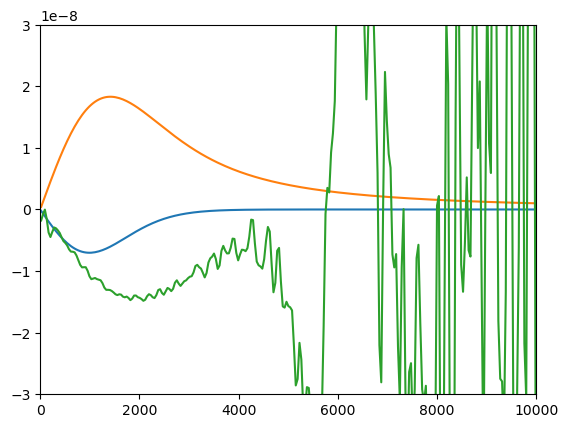

8501 709.9208169936039 0.06355157629086866 1.0001150526675062
8502 710.004327264983 0.06356205014606565 1.0001150169162591
8503 710.087837536362 0.06358243141186569 1.0001149779606529
8504 710.1713478077412 0.0636047460761114 1.000114939527226
8505 710.2548580791203 0.06361262395265047 1.0001149052335998
8506 710.3383683504993 0.06362754933642856 1.00011487025826
8507 710.4218786218785 0.06364999150233451 1.0001148336227723
8508 710.5053888932575 0.06366882953884137 1.0001148034578347
8509 710.5888991646366 0.06368070227910451 1.000114768287096
8510 710.6724094360156 0.06368664338838063 1.0001147436560083
8511 710.7559197073948 0.06369771295297517 1.0001147089102524
8512 710.8394299787739 0.06371556039730353 1.00011468508683
8513 710.9229402501529 0.0637360278689203 1.0001146559546383
8514 711.006450521532 0.0637395167029829 1.000114629875127
8515 711.0899607929111 0.06375004402600791 1.0001146030408268
8516 711.1734710642902 0.06377489434638804 1.0001145792188137
8517 711.256981335669

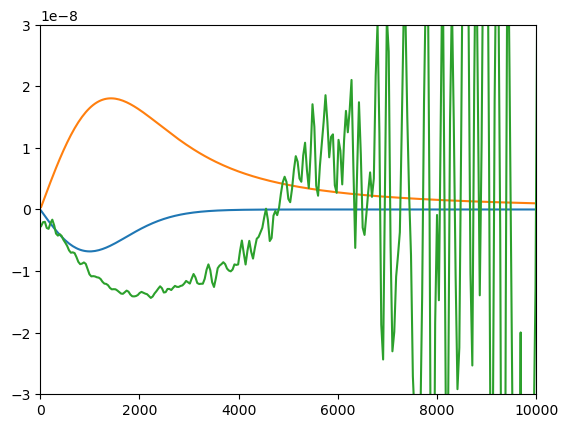

8601 718.2718441315125 0.06279441932892675 1.0001174003263498
8602 718.3553544028915 0.06275706725154358 1.0001174856895994
8603 718.4388646742706 0.06272623334270207 1.0001175657430565
8604 718.5223749456497 0.0626914918963713 1.0001176542031818
8605 718.6058852170288 0.06265039454277484 1.0001177358297884
8606 718.6893954884079 0.06260959188191399 1.0001178237470516
8607 718.7729057597869 0.06257583897051713 1.000117903229027
8608 718.8564160311661 0.06254283897298239 1.0001179920549816
8609 718.9399263025451 0.06250523565244345 1.0001180748000325
8610 719.0234365739242 0.062469742119099024 1.000118158007451
8611 719.1069468453032 0.062425349293433866 1.0001182434634772
8612 719.1904571166824 0.06238567440171619 1.0001183286030946
8613 719.2739673880615 0.062357520380772816 1.0001184132113157
8614 719.3574776594405 0.06232784492253269 1.0001184979716822
8615 719.4409879308197 0.06228990294357679 1.000118583632702
8616 719.5244982021987 0.06224773771625173 1.0001186674887919
8617 719.

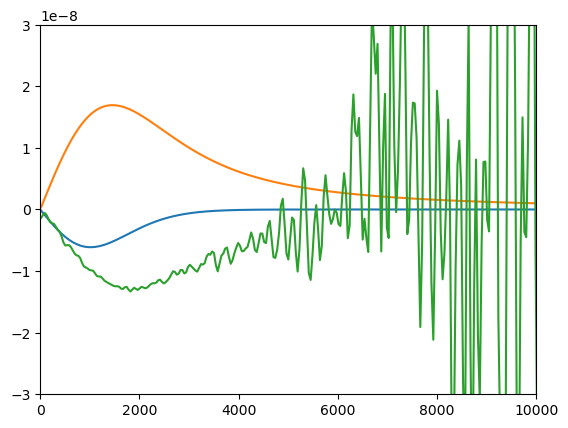

8701 726.622871269421 0.060241997097957925 1.0001246234198227
8702 726.7063815408001 0.060215031500749465 1.000124698922199
8703 726.7898918121791 0.06018742892394144 1.0001247740319572
8704 726.8734020835582 0.06016546565668175 1.0001248491070192
8705 726.9569123549373 0.06014056189684256 1.0001249286879483
8706 727.0404226263164 0.060112510663266255 1.0001250056654631
8707 727.1239328976955 0.06008761134876268 1.0001250880878323
8708 727.2074431690746 0.06005574256513103 1.0001251662651351
8709 727.2909534404537 0.0600220211820825 1.0001252527726017
8710 727.3744637118327 0.05999083202980699 1.0001253311704685
8711 727.4579739832118 0.05996239437094735 1.0001254187315
8712 727.541484254591 0.05993702876565284 1.0001254958176162
8713 727.62499452597 0.05990367194016006 1.0001255850305473
8714 727.7085047973491 0.059865492723231606 1.0001256643198697
8715 727.7920150687281 0.05983927893927956 1.000125752682916
8716 727.8755253401073 0.05981746493821846 1.0001258339874204
8717 727.95903

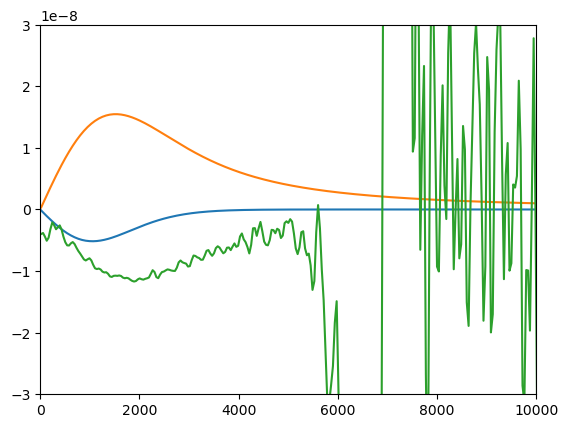

8801 734.9738984073294 0.05642578340798717 1.000134661731388
8802 735.0574086787086 0.056375268087461364 1.000134756809879
8803 735.1409189500877 0.056339135837185944 1.0001348595548893
8804 735.2244292214667 0.05630246630969668 1.0001349512376876
8805 735.3079394928459 0.05625961631210036 1.0001350550168666
8806 735.391449764225 0.056217069988793174 1.00013514810487
8807 735.474960035604 0.05617719038488741 1.0001352487430188
8808 735.558470306983 0.05613400631277651 1.0001353399581945
8809 735.6419805783622 0.05608651328089896 1.0001354401897202
8810 735.7254908497413 0.056048305486059456 1.000135531743828
8811 735.8090011211203 0.05601113653740365 1.000135627410078
8812 735.8925113924994 0.05597173093751557 1.0001357209132475
8813 735.9760216638786 0.05593606408247529 1.0001358153397761
8814 736.0595319352576 0.05589735439584751 1.0001359089236894
8815 736.1430422066367 0.05585086811149951 1.000135999736692
8816 736.2265524780158 0.055803988797578065 1.0001360946562154
8817 736.3100

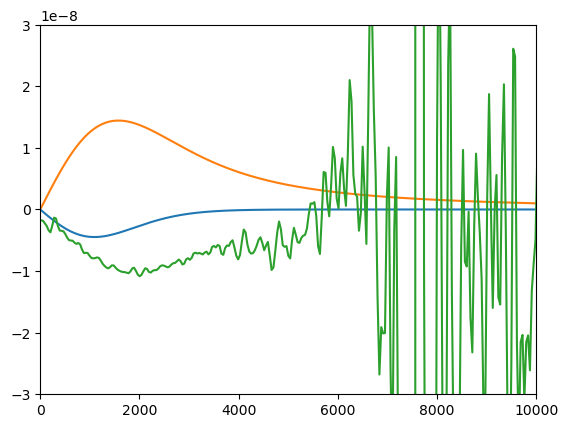

8901 743.324925545238 0.053556179871766064 1.0001408845109814
8902 743.4084358166172 0.05355602110141802 1.0001408982289708
8903 743.4919460879962 0.05355632266112715 1.0001409067346294
8904 743.5754563593753 0.05355218911779255 1.0001409212852774
8905 743.6589666307543 0.05354393433730607 1.0001409307760551
8906 743.7424769021335 0.05354012476414911 1.0001409474740024
8907 743.8259871735125 0.053541610893553394 1.0001409537838721
8908 743.9094974448916 0.053544486455346804 1.0001409660704028
8909 743.9930077162707 0.053537464152124695 1.0001409699691999
8910 744.0765179876498 0.05353057279086091 1.000140987203247
8911 744.1600282590289 0.05353936488040823 1.0001409849280303
8912 744.2435385304079 0.053536402731433765 1.0001409991568597
8913 744.3270488017871 0.05352600276787174 1.0001409989897052
8914 744.4105590731662 0.053523986565449884 1.0001410108472466
8915 744.4940693445452 0.05353357939835463 1.0001410093167504
8916 744.5775796159243 0.05353619078329116 1.000141021099323
8917 

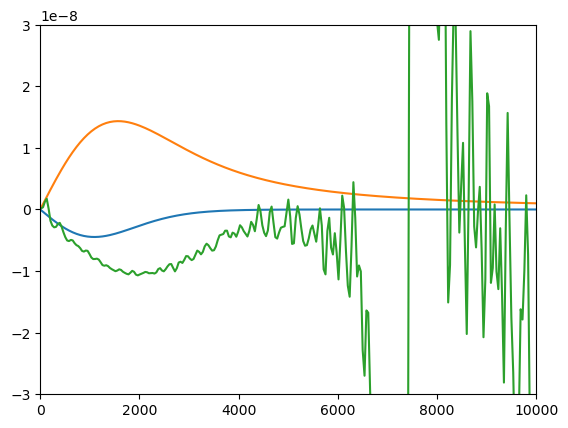

9001 751.6759526831465 0.05344836477114001 1.0001405781679382
9002 751.7594629545256 0.05345541968519079 1.0001405670448429
9003 751.8429732259048 0.05345953510706014 1.0001405456097658
9004 751.9264834972838 0.05347033437612849 1.0001405312443596
9005 752.0099937686629 0.053475171098421564 1.0001405068062963
9006 752.093504040042 0.053478713109639635 1.0001404940156613
9007 752.1770143114211 0.053489386174472124 1.0001404687579984
9008 752.2605245828001 0.053492778719961956 1.000140455103255
9009 752.3440348541792 0.053498405986610466 1.0001404335711115
9010 752.4275451255584 0.05350829119942314 1.0001404156909155
9011 752.5110553969374 0.053516258748631536 1.0001403936642108
9012 752.5945656683165 0.053527645858757945 1.0001403726156113
9013 752.6780759396955 0.053537753620953796 1.0001403479040758
9014 752.7615862110747 0.053547940407659235 1.000140324264086
9015 752.8450964824538 0.05356519225671022 1.000140301807406
9016 752.9286067538328 0.05358085581774249 1.0001402763422593
901

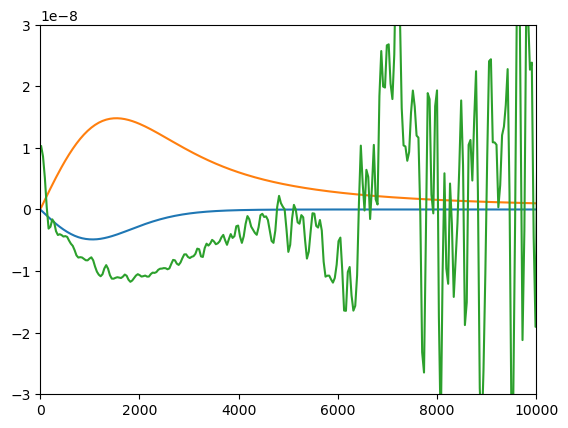

9101 760.0269798210551 0.05509531480997409 1.0001373419837167
9102 760.1104900924341 0.05510294967815715 1.0001373167834822
9103 760.1940003638133 0.055114496515264906 1.000137284425711
9104 760.2775106351924 0.05512556472260713 1.00013725795636
9105 760.3610209065714 0.055133834213504554 1.000137230069804
9106 760.4445311779505 0.05514642185877093 1.0001372006064655
9107 760.5280414493296 0.055155130790562217 1.0001371736756481
9108 760.6115517207087 0.05516452245777597 1.000137144231962
9109 760.6950619920877 0.05516522122058389 1.000137122978335
9110 760.7785722634668 0.05517599758075177 1.0001370941845753
9111 760.862082534846 0.0551866102936369 1.0001370719211344
9112 760.945592806225 0.055179872262165724 1.0001370431819783
9113 761.0291030776041 0.0551896201178644 1.0001370214982546
9114 761.1126133489831 0.055204530111965334 1.0001369901717494
9115 761.1961236203623 0.05520441486779579 1.0001369718127666
9116 761.2796338917414 0.05521053042632023 1.0001369427504792
9117 761.3631

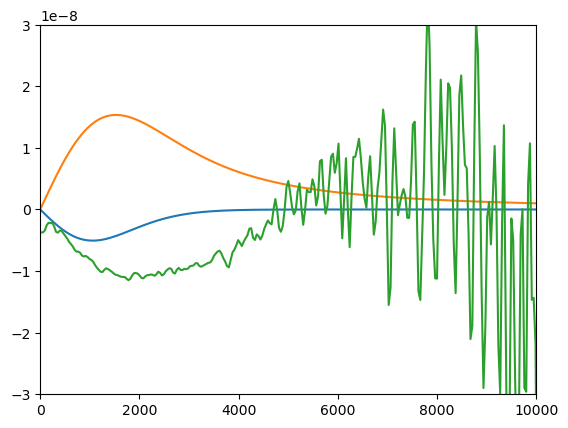

9201 768.3780069589636 0.05609956597626119 1.0001347256089095
9202 768.4615172303427 0.05611528486315337 1.0001346850079533
9203 768.5450275017217 0.056129979627022396 1.0001346500796537
9204 768.6285377731009 0.05613973473593385 1.0001346130462379
9205 768.71204804448 0.05615681561521627 1.0001345810071505
9206 768.795558315859 0.0561722580831276 1.0001345382293418
9207 768.8790685872381 0.05618378117488186 1.0001345068545846
9208 768.9625788586172 0.05619962386389419 1.0001344641346288
9209 769.0460891299963 0.056214980454012194 1.0001344343823935
9210 769.1295994013753 0.05623816571299476 1.000134389642169
9211 769.2131096727545 0.056263195643758125 1.0001343541069099
9212 769.2966199441336 0.05627537174939351 1.0001343095374993
9213 769.3801302155126 0.056279171417173805 1.0001342750237978
9214 769.4636404868917 0.05628769286661206 1.0001342305474346
9215 769.5471507582708 0.05630887473672646 1.0001341933831287
9216 769.6306610296499 0.056332025744448594 1.0001341491643363
9217 769

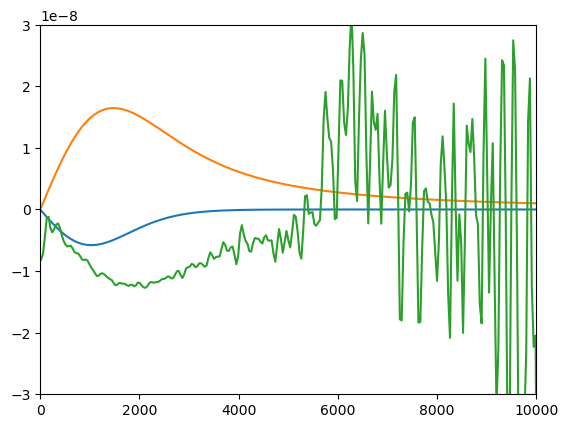

9301 776.7290340968722 0.05904391854336766 1.0001279031674193
9302 776.8125443682512 0.059091199663567906 1.0001278026233968
9303 776.8960546396303 0.059147156828430705 1.0001277102032688
9304 776.9795649110093 0.05919368683728779 1.000127610259963
9305 777.0630751823885 0.05923310574599775 1.000127519917487
9306 777.1465854537676 0.059278818172084094 1.000127421178033
9307 777.2300957251466 0.059321561260398586 1.000127329422516
9308 777.3136059965258 0.05935542836925395 1.0001272341201475
9309 777.3971162679048 0.059408330923467145 1.0001271397717646
9310 777.4806265392839 0.05945836218226709 1.0001270431906895
9311 777.564136810663 0.05948811599920127 1.0001269541406432
9312 777.6476470820421 0.05952240059877451 1.0001268620309711
9313 777.7311573534212 0.059568452334241406 1.000126769376203
9314 777.8146676248002 0.059616528828569514 1.0001266786937273
9315 777.8981778961793 0.05965206738370225 1.0001265865885243
9316 777.9816881675584 0.05968823208516418 1.0001264983899754
9317 77

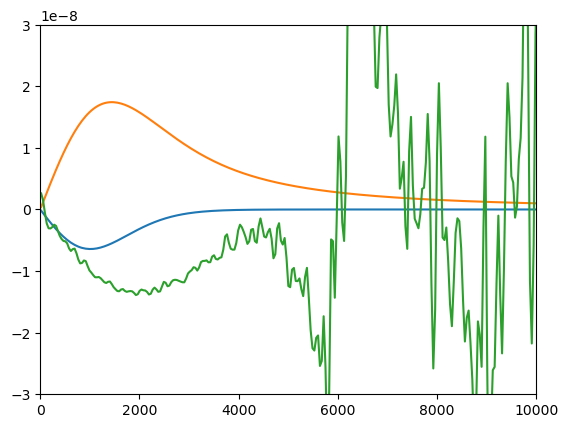

9401 785.0800612347807 0.06138254628806111 1.0001226078341894
9402 785.1635715061598 0.06137286610977861 1.0001226049728396
9403 785.2470817775388 0.061372124999127524 1.0001226061962185
9404 785.3305920489179 0.06137336617465508 1.0001226031461339
9405 785.414102320297 0.061365341559952526 1.000122603127503
9406 785.4976125916761 0.06136904316207058 1.0001226024652028
9407 785.5811228630552 0.06137342175028668 1.0001226002744914
9408 785.6646331344342 0.06136360464667766 1.0001226038244309
9409 785.7481434058134 0.06136804047595662 1.0001225989621942
9410 785.8316536771924 0.061381107512966 1.0001226022008727
9411 785.9151639485715 0.061376346831972045 1.0001225999714922
9412 785.9986742199505 0.06137146503722109 1.0001226053408805
9413 786.0821844913297 0.06136936520293771 1.0001225998444983
9414 786.1656947627088 0.06136321922503545 1.0001226087786186
9415 786.2492050340878 0.06136430729386072 1.0001226046571121
9416 786.332715305467 0.06136590091022436 1.00012261191401
9417 786.416

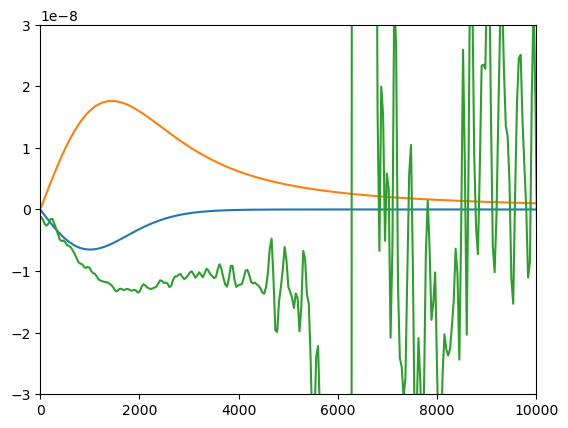

9501 793.4310883726891 0.061775705274974384 1.0001225986492104
9502 793.5145986440683 0.06177686084226676 1.0001226124888123
9503 793.5981089154474 0.061781349894468554 1.0001226118276154
9504 793.6816191868264 0.06177119182566493 1.0001226300101334
9505 793.7651294582055 0.06176722854157968 1.0001226330836197
9506 793.8486397295846 0.06177263771729948 1.0001226485123498
9507 793.9321500009637 0.061771997826566366 1.0001226519550157
9508 794.0156602723428 0.06176910816003088 1.000122668612993
9509 794.0991705437219 0.06176434369952186 1.0001226738633213
9510 794.182680815101 0.061760319192815376 1.000122690759015
9511 794.26619108648 0.061747690172568946 1.0001226986674094
9512 794.3497013578591 0.06173135421492824 1.0001227158447228
9513 794.4332116292383 0.061727114483673705 1.0001227249595335
9514 794.5167219006173 0.06172232297741007 1.000122740303022
9515 794.6002321719964 0.06170765401171077 1.0001227528198129
9516 794.6837424433754 0.06169810196171317 1.0001227668988668
9517 794

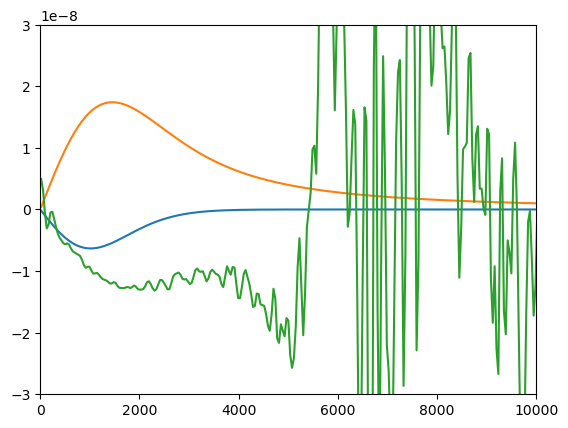

9601 801.7821155105977 0.06115681222922664 1.0001239609223793
9602 801.8656257819767 0.06115420758661678 1.0001239766918313
9603 801.9491360533559 0.06115366224698922 1.0001239867576517
9604 802.032646324735 0.061138963912229054 1.0001240018490347
9605 802.116156596114 0.061120883286184424 1.0001240160189107
9606 802.1996668674932 0.06111303897948627 1.0001240290795672
9607 802.2831771388722 0.0611031030671566 1.0001240441487018
9608 802.3666874102513 0.06110035936813595 1.0001240546119559
9609 802.4501976816304 0.061097152955678684 1.0001240681492298
9610 802.5337079530095 0.06108473337973227 1.0001240808822602
9611 802.6172182243886 0.06107920072357245 1.0001240961455504
9612 802.7007284957676 0.06107360663345097 1.0001241044616491
9613 802.7842387671467 0.06106019661602381 1.0001241228915732
9614 802.8677490385259 0.061052291546162714 1.0001241319308116
9615 802.9512593099049 0.06104519134103589 1.0001241474409728
9616 803.034769581284 0.061033155816404325 1.0001241576163373
9617 80

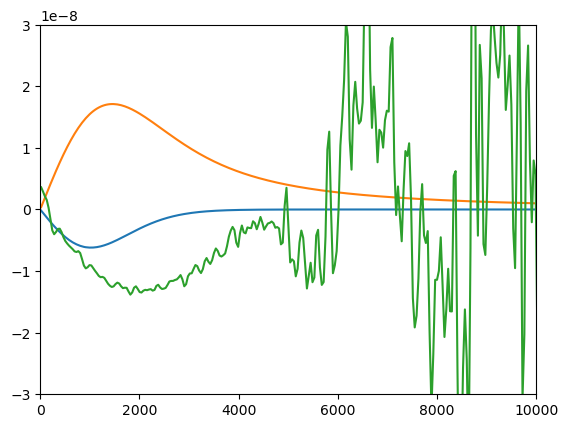

9701 810.1331426485062 0.06054206709920337 1.0001245988559737
9702 810.2166529198853 0.06053746137587177 1.0001246014024168
9703 810.3001631912645 0.060528187431979866 1.0001246072079089
9704 810.3836734626435 0.060528165256518565 1.000124608153766
9705 810.4671837340226 0.0605302464598127 1.000124612136856
9706 810.5506940054016 0.060519584618859 1.0001246149211487
9707 810.6342042767808 0.06051961024780524 1.0001246211961976
9708 810.7177145481598 0.06052364217256373 1.0001246215465949
9709 810.8012248195389 0.06051291062652268 1.0001246294148824
9710 810.884735090918 0.060503544311056194 1.0001246318033354
9711 810.9682453622971 0.060505368980877036 1.0001246384357032
9712 811.0517556336762 0.060513441513458395 1.000124639884945
9713 811.1352659050552 0.060511923537689916 1.0001246466135132
9714 811.2187761764344 0.06050313902311166 1.0001246515433917
9715 811.3022864478135 0.06049964031395786 1.00012465851864
9716 811.3857967191925 0.060503802918011114 1.0001246627049185
9717 811.4

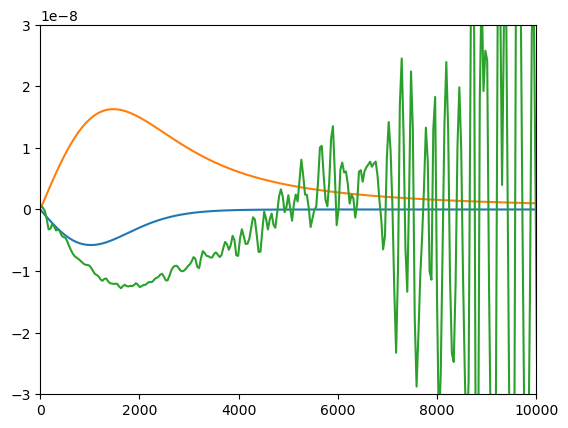

9801 818.4841697864148 0.05878848084404182 1.000128677756503
9802 818.5676800577938 0.05873999301860329 1.0001287716938512
9803 818.6511903291729 0.058691988732517304 1.0001288703833484
9804 818.7347006005521 0.05865208573214407 1.000128964156869
9805 818.8182108719311 0.05861403085480974 1.0001290636420057
9806 818.9017211433102 0.05857446280300126 1.0001291584071663
9807 818.9852314146893 0.05851885640967111 1.00012925958898
9808 819.0687416860684 0.058461601425537045 1.0001293575894952
9809 819.1522519574474 0.05841193551070055 1.000129458850737
9810 819.2357622288265 0.05835952027038449 1.0001295575676339
9811 819.3192725002057 0.05830558828250314 1.0001296578114414
9812 819.4027827715847 0.05824962819735387 1.0001297585214604
9813 819.4862930429638 0.058205432341104354 1.0001298595355474
9814 819.5698033143428 0.05816540577269159 1.000129958574152
9815 819.653313585722 0.05811066207302923 1.0001300601918552
9816 819.7368238571011 0.05805517870968951 1.000130161567095
9817 819.8203

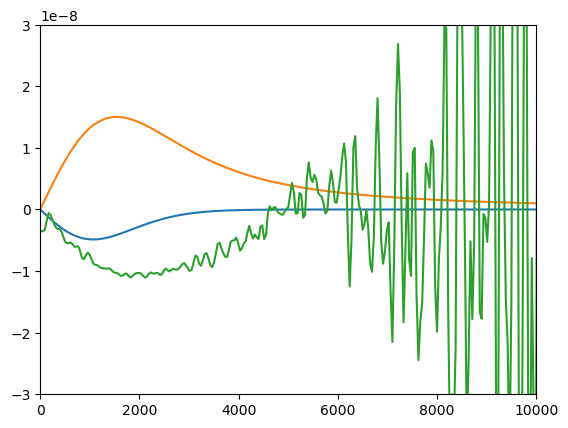

9901 826.8351969243233 0.055257419302706605 1.0001363944923178
9902 826.9187071957024 0.05524419695801437 1.0001364346418642
9903 827.0022174670814 0.055234640960753346 1.0001364768175898
9904 827.0857277384606 0.0552262162935949 1.0001365181446487
9905 827.1692380098397 0.05520827146316205 1.0001365570058818
9906 827.2527482812187 0.05518575333106841 1.0001365994015308
9907 827.3362585525978 0.055178611222944374 1.000136637538173
9908 827.4197688239769 0.055164969025397664 1.0001366769119724
9909 827.503279095356 0.055146099601819314 1.0001367158356376
9910 827.586789366735 0.05514425368462831 1.0001367548787843
9911 827.6702996381141 0.055136863544615604 1.0001367929050904
9912 827.7538099094933 0.055117683097669554 1.0001368336361738
9913 827.8373201808723 0.055104897918796567 1.000136873232026
9914 827.9208304522514 0.05508987510715173 1.0001369164147738
9915 828.0043407236305 0.05506679483549374 1.000136954844212
9916 828.0878509950096 0.05505857608121526 1.0001369921697985
9917 8

In [7]:
setupT()
setupQ()
setupV2Grav()
setupU1U2()

hello = []
hello2 = []
ts = []
oldGM = GM
newGM = GM*1.2
for t in range(bigT):
    #Pertubation
    if(t*dt<6.0):
        GM = newGM
    if(t*dt>=6.0):
        GM = oldGM

    setupT()
    setupQ()
    setupV2Grav()
    setupU1U2()
    psi = np.linalg.solve(U2, np.dot(U1,psi))

    normalization = scipy.integrate.simpson(4.0*np.pi*x*x*np.absolute(psi)*np.absolute(psi), x=x)
    #if(normalization >= 1.01):
    #    break
    print(t, t*dt, np.absolute(psi[0]), normalization)
    if(GM == oldGM):

        def findMass():
            for i in range(size):
                if(i != 0):
                    temp = scipy.integrate.simpson(4.0*np.pi*x[:i]*x[:i]*np.absolute(psi[:i])*np.absolute(psi[:i]), x=x[:i])
                    if(temp > 0.99):
                        return i
            return size-1
            
        hello2.append(findMass())

        hello.append(np.absolute(psi[0])*np.absolute(psi[0]))
        ts.append(t*dt)

    if t%100 == 0:
        hBarInCU = 1.1977151493389159e-76
        setupV2Grav()
        np.set_printoptions(threshold=np.inf)

        rhoTemp = np.absolute(psi)*np.absolute(psi)/Ra/Ra/Ra*totalMass*5.1550e96*0.001*1.619e-18
        pressure = 2.0*np.pi*aInCU*hBarInCU*hBarInCU/massInCU/massInCU/massInCU*rhoTemp*rhoTemp
        pressureGradients = np.gradient(pressure, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        gravitationalPotential = phi*Ra*Ra*omegaA*omegaA*1.616e-35*100*6.77193e-6*1.616e-35*100*6.77193e-6/5.391e-44/5.391e-44/2.03017e5/2.03017e5

        dRhodx = np.gradient(np.sqrt(rhoTemp), x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        d2Rhodx = np.gradient(dRhodx, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2)
        quantumPotential = -hBarCU*hBarCU/2.0/massInCU*(d2Rhodx + 2.0/(x*Ra*1.616e-35*100*6.77193e-6)*dRhodx)/np.sqrt(rhoTemp)

        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, pressureGradients/rhoTemp)
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(gravitationalPotential, x*Ra*1.616e-35*100*6.77193e-6, edge_order=2))
        plt.plot(x*Ra*1.616e-35*100*6.77193e-6, np.gradient(quantumPotential, x*Ra*1.616e-35*100*6.77193e-6)/massInCU)

        plt.xlim(0.0,10000.0)
        plt.ylim(-3e-8,3e-8)
        #print(np.gradient(quantumPotential[100:1500], x[100:1500]*Ra*1.616e-35*100*6.77193e-6)/massInCU)
        #print(x[100]*Ra*1.616e-35*100*6.77193e-6)
        plt.show()

        #plt.plot(x, np.absolute(psi)*np.absolute(psi))

#plt.xlabel(r"$r$ (dimensionless)")
#plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
#plt.show()

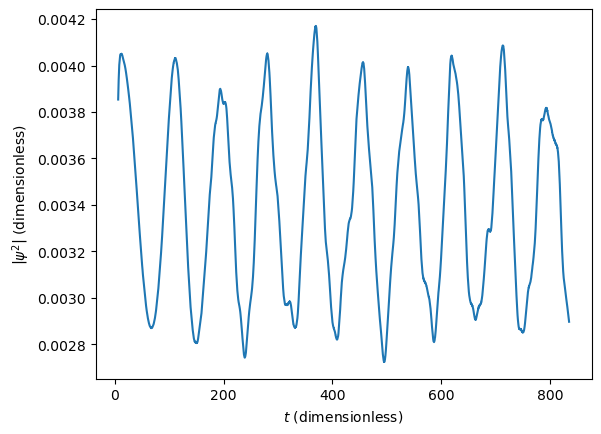

In [8]:
plt.plot(ts[:30000], hello[:30000])
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"$\left | \psi^2 \right |$ (dimensionless)")
plt.show()

Text(0.5, 0, 'f (1/s)')

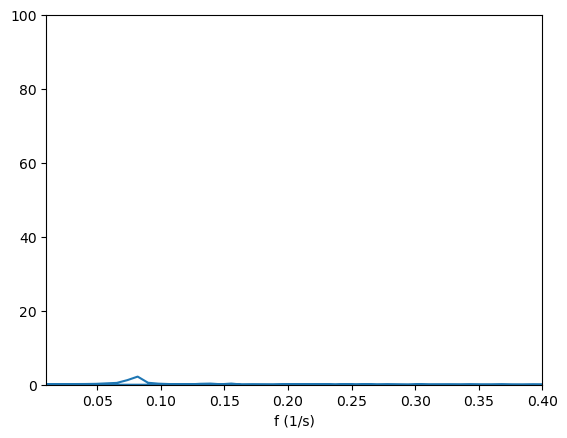

In [9]:
sp = np.fft.fft(hello)
freq = np.fft.fftfreq(len(hello), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100.0)
plt.xlabel("f (1/s)")

In [10]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 0.04 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.008179572925060436
0.08179572925060435 2.196201021108758
0.1390527397260274 0.30784482448416345
0.15541188557614827 0.3113413155192644
0.17177103142626915 0.06983291777413186
0.20448932312651089 0.16196302994114023
0.22902804190169218 0.14005052897349676
0.245387187751813 0.14702857928256705
0.26174633360193394 0.1328123903006222
0.2781054794520548 0.08402168090820217
0.3026441982272361 0.11574598841306313
0.3190033440773569 0.06997424410032621
0.3435420628525383 0.07924045265052927
0.36808078162771957 0.07953985362378872
0.3926195004029009 0.054640360949693816
0.4253377921031426 0.0608389031174343
0.4498765108783239 0.053640316774644085
0.4825948025785657 0.05824279298136262
0.5153130942788074 0.04525754657025207
0.5480313859790491 0.04247488290286807
0.580749677679291 0.045040004240846566


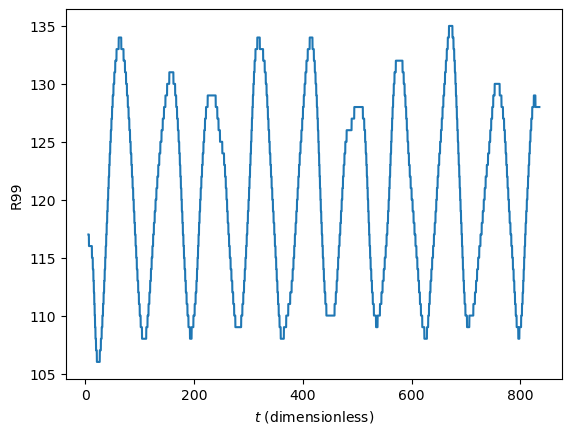

In [11]:
plt.plot(ts, hello2)
plt.xlabel(r"$t$ (dimensionless)")
plt.ylabel(r"R99")
plt.show()

Text(0.5, 0, 'f (1/s)')

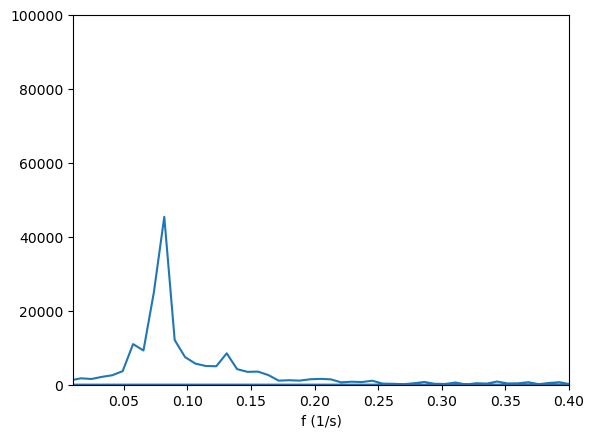

In [12]:
sp = np.fft.fft(hello2)
freq = np.fft.fftfreq(len(hello2), d=dt)*omegaA/5.391247e-44

plt.plot(freq, np.absolute(sp))
plt.xlim(0.01,0.4)
plt.ylim(0.0,100000)
plt.xlabel("f (1/s)")

In [13]:
print(freq[1]-freq[0])
for i in range(len(freq)-1):
    if(freq[i] > 0.0 and np.absolute(sp[i]) > 5000 and np.absolute(sp[i])>np.absolute(sp[i+1]) and np.absolute(sp[i])>np.absolute(sp[i-1])):
        print(freq[i], np.absolute(sp[i]))

0.008179572925060436
0.057257010475423045 10989.620032866875
0.08179572925060435 45421.96572602573
0.13087316680096697 8494.725242977816


[5.38250248e-02 5.37935152e-02 5.37306796e-02 5.36369011e-02
 5.35121485e-02 5.33572774e-02 5.31731292e-02 5.29601330e-02
 5.27180583e-02 5.24471686e-02 5.21477383e-02 5.18204051e-02
 5.14659448e-02 5.10851798e-02 5.06789130e-02 5.02480326e-02
 4.97934931e-02 4.93158879e-02 4.88159548e-02 4.82945258e-02
 4.77526726e-02 4.71913934e-02 4.66118326e-02 4.60151232e-02
 4.54023290e-02 4.47744396e-02 4.41324226e-02 4.34774293e-02
 4.28105568e-02 4.21328747e-02 4.14453480e-02 4.07490234e-02
 4.00449189e-02 3.93341208e-02 3.86177654e-02 3.78968606e-02
 3.71723545e-02 3.64451648e-02 3.57162015e-02 3.49862661e-02
 3.42562704e-02 3.35271333e-02 3.27996263e-02 3.20745274e-02
 3.13526379e-02 3.06347282e-02 2.99214413e-02 2.92135223e-02
 2.85115686e-02 2.78160539e-02 2.71274748e-02 2.64463834e-02
 2.57733142e-02 2.51087323e-02 2.44531594e-02 2.38068868e-02
 2.31702445e-02 2.25435571e-02 2.19272014e-02 2.13213772e-02
 2.07262540e-02 2.01419808e-02 1.95686546e-02 1.90064738e-02
 1.84555523e-02 1.791603

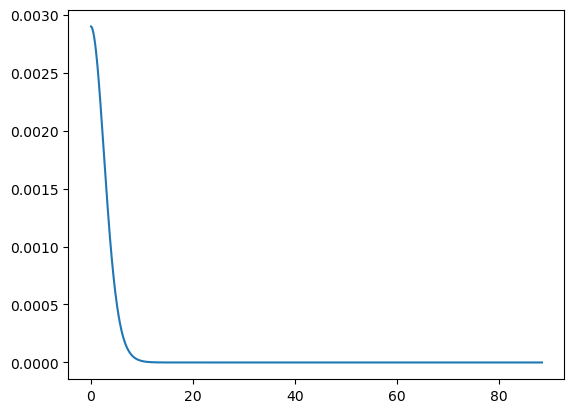

In [14]:
plt.plot(x, np.absolute(psi)*np.absolute(psi))
print(np.absolute(psi))

Middle
0.071-0.081			M1 (M2: 0.142-0.162, M3: 0.213-0.243, M4: 0.284-0.324, M5: 0.355-0.405)
0.132-0.137			M1?
0.158-0.163			M2
0.193-0.204			M1?
0.239-0.249			M3
0.295-0.305			M4
0.361-0.371			M5

0.076-0.086			M1
0.132-0.142			M1?
0.158-0.168			M2

Small
0.097-0.107		M1
0.163-0.173		M1?
0.214-0.224		M2
0.270-0.280		M1?
0.341-0.351		M3
0.432-0.443		M4
0.534-0.544		M5
0.651-0.661		M6

Heavy
0.031-0.037		M1
0.058-0.065		M2
0.072-0.078		M?
0.082-0.089		M?
0.099-0.167 	M3
0.116-0.123		M4
0.140-0.147		M5
0.167-0.173		M6?
0.194-0.201 	M7?